# **PROJETO APRENDIZAJE DE MAQUINA**

## Drive y librerias

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error

## Estadistica descriptiva

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Cargar la hoja llamada "almuerzo"
dataset = pd.read_excel('/content/drive/MyDrive/Base Asistencia Almuerzo y Cena (SIN-VACAS).xlsx', sheet_name ='Almuerzo')

In [ ]:
import pandas as pd
from IPython.display import HTML
import numpy as np

# ============================================================================
# TABLA DE ESTADÍSTICA DESCRIPTIVA - DATOS SIN OUTLIERS
# ============================================================================

def criar_tabela_estatistica_descritiva_sin_outliers(dataset):
    """Crea tabla de estadística descriptiva usando datos SIN outliers"""

    # Función para quitar outliers de MÚLTIPLES variables
    def remove_outliers_iqr_correct(df, columns):
        mask = pd.Series([True] * len(df))
        print("IDENTIFICANDO OUTLIERS:")

        for column in columns:
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # Identificar outliers para esta variable
            outliers_mask = (df[column] >= lower_bound) & (df[column] <= upper_bound)
            n_outliers_var = len(df) - outliers_mask.sum()
            print(f"   {column}: {n_outliers_var} outliers")

            mask = mask & outliers_mask

        n_total_outliers = len(df) - mask.sum()
        print(f"📊 TOTAL OUTLIERS ELIMINADOS: {n_total_outliers}")
        return df[mask], n_total_outliers

    # Aplicar remoción de outliers a LAS 4 VARIABLES CONTINUAS
    continuous_vars = ["tavg", "tmin", "tmax", "TOTAL"]
    dataset_sin_outliers, n_outliers_eliminados = remove_outliers_iqr_correct(dataset, continuous_vars)

    # Diccionario con estadísticas (TODO con datos SIN outliers)
    estatisticas = {
        'Variables Continuas (sin outliers)': {
            'tavg': {
                'Media': f"{dataset_sin_outliers['tavg'].mean():.2f}",
                'Mediana': f"{dataset_sin_outliers['tavg'].median():.2f}",
                'Desv. Estándar': f"{dataset_sin_outliers['tavg'].std():.2f}",
                'Mínimo': f"{dataset_sin_outliers['tavg'].min():.2f}",
                'Máximo': f"{dataset_sin_outliers['tavg'].max():.2f}",
                'Q1': f"{dataset_sin_outliers['tavg'].quantile(0.25):.2f}",
                'Q3': f"{dataset_sin_outliers['tavg'].quantile(0.75):.2f}"
            },
            'tmin': {
                'Media': f"{dataset_sin_outliers['tmin'].mean():.2f}",
                'Mediana': f"{dataset_sin_outliers['tmin'].median():.2f}",
                'Desv. Estándar': f"{dataset_sin_outliers['tmin'].std():.2f}",
                'Mínimo': f"{dataset_sin_outliers['tmin'].min():.2f}",
                'Máximo': f"{dataset_sin_outliers['tmin'].max():.2f}",
                'Q1': f"{dataset_sin_outliers['tmin'].quantile(0.25):.2f}",
                'Q3': f"{dataset_sin_outliers['tmin'].quantile(0.75):.2f}"
            },
            'tmax': {
                'Media': f"{dataset_sin_outliers['tmax'].mean():.2f}",
                'Mediana': f"{dataset_sin_outliers['tmax'].median():.2f}",
                'Desv. Estándar': f"{dataset_sin_outliers['tmax'].std():.2f}",
                'Mínimo': f"{dataset_sin_outliers['tmax'].min():.2f}",
                'Máximo': f"{dataset_sin_outliers['tmax'].max():.2f}",
                'Q1': f"{dataset_sin_outliers['tmax'].quantile(0.25):.2f}",
                'Q3': f"{dataset_sin_outliers['tmax'].quantile(0.75):.2f}"
            }
        },
        'Variable Objetivo (TOTAL sin outliers)': {
            'TOTAL': {
                'Media': f"{dataset_sin_outliers['TOTAL'].mean():.2f}",
                'Mediana': f"{dataset_sin_outliers['TOTAL'].median():.2f}",
                'Desv. Estándar': f"{dataset_sin_outliers['TOTAL'].std():.2f}",
                'Mínimo': f"{dataset_sin_outliers['TOTAL'].min()}",
                'Máximo': f"{dataset_sin_outliers['TOTAL'].max()}",
                'Q1': f"{dataset_sin_outliers['TOTAL'].quantile(0.25):.2f}",
                'Q3': f"{dataset_sin_outliers['TOTAL'].quantile(0.75):.2f}",
                'Percentil 90': f"{dataset_sin_outliers['TOTAL'].quantile(0.90):.2f}"
            }
        },
        'Variables Categóricas (sin outliers)': {}
    }

    # Estadísticas para variables categóricas (también SIN outliers)
    categorical_vars = ['CatPrato', 'CatVegano', 'CatGuarnicao', 'CatSalada', 'CatSobremesa', 'CatSuco', 'Año', 'Día']

    for var in categorical_vars:
        if var in dataset_sin_outliers.columns:
            data = dataset_sin_outliers[var]
            value_counts = data.value_counts()
            total = len(data)

            # Calcular entropía
            proportions = value_counts / total
            entropy = -np.sum(proportions * np.log2(proportions))

            estatisticas['Variables Categóricas (sin outliers)'][var] = {
                'Número Categorías': f"{len(value_counts)}",
                'Moda': f"{data.mode().iloc[0] if not data.mode().empty else 'N/A'}",
                'Frecuencia Moda': f"{value_counts.iloc[0]}",
                'Entropía': f"{entropy:.3f}",
                'Distribución': '<br>'.join([f"{cat}: {count} ({count/total*100:.1f}%)"
                                           for cat, count in value_counts.items()])
            }

    return estatisticas, len(dataset_sin_outliers), n_outliers_eliminados

# Función para formatear los diccionarios como texto
def formatar_dict(dicionario):
    return '<br>'.join([f"{k}: {v}" for k, v in dicionario.items()])

# Crear y mostrar tabla de estadística descriptiva
def mostrar_tabela_estatistica_descritiva_sin_outliers():
    """Muestra la tabla de estadística descriptiva con datos SIN outliers"""

    estatisticas, n_sin_outliers, n_outliers_eliminados = criar_tabela_estatistica_descritiva_sin_outliers(dataset)

    # CUADRO INTRODUCTORIO
    print("📋 CUADRO INTRODUCTORIO - ELIMINACIÓN DE OUTLIERS")
    print("="*50)
    print(f"Dataset original: {len(dataset)} registros")
    print(f"Outliers identificados: {n_outliers_eliminados} registros")
    print(f"Dataset final (sin outliers): {n_sin_outliers} registros")
    print(f"Porcentaje eliminado: {(n_outliers_eliminados/len(dataset)*100):.1f}%")
    print("="*50)

    # Crear DataFrame
    tabela_data = []

    # Variables Continuas (SIN outliers)
    for var_name, var_stats in estatisticas['Variables Continuas (sin outliers)'].items():
        tabela_data.append({
            'Categoría': 'Variables Continuas',
            'Variable': var_name,
            'Estadísticas': formatar_dict(var_stats),
            'Dataset': f"Sin outliers<br>(n={n_sin_outliers})",
            'Notas': 'Outliers removidos<br>con método IQR'
        })

    # Variable Objetivo (SIN outliers)
    for var_name, var_stats in estatisticas['Variable Objetivo (TOTAL sin outliers)'].items():
        tabela_data.append({
            'Categoría': 'Variable Objetivo',
            'Variable': var_name,
            'Estadísticas': formatar_dict(var_stats),
            'Dataset': f"Sin outliers<br>(n={n_sin_outliers})",
            'Notas': 'Outliers removidos<br>con método IQR'
        })

    # Variables Categóricas (SIN outliers)
    for var_name, var_stats in estatisticas['Variables Categóricas (sin outliers)'].items():
        tabela_data.append({
            'Categoría': 'Variables Categóricas',
            'Variable': var_name,
            'Estadísticas': formatar_dict(var_stats),
            'Dataset': f"Sin outliers<br>(n={n_sin_outliers})",
            'Notas': 'Análisis de frecuencia<br>y diversidad'
        })

    df = pd.DataFrame(tabela_data)

    # Crear HTML con alineación izquierda (MISMO ESTILO)
    html_tabela = df.to_html(escape=False, index=False)
    html_tabela_esquerda = html_tabela.replace('<th>', '<th style="text-align: left; padding: 8px; border: 1px solid #ddd;">').replace('<td>', '<td style="text-align: left; padding: 8px; border: 1px solid #ddd;">')

    # Adicionar estilo CSS para mejor apariencia (MISMO ESTILO)
    html_final = f"""
    <style>
        table {{
            border-collapse: collapse;
            width: 100%;
            font-family: Arial, sans-serif;
            font-size: 12px;
            margin: 20px 0;
        }}
        th {{
            background-color: #2c3e50;
            color: white;
            font-weight: bold;
            padding: 12px 8px;
            border: 1px solid #34495e;
        }}
        td {{
            padding: 8px;
            border: 1px solid #bdc3c7;
            vertical-align: top;
        }}
        tr:nth-child(even) {{
            background-color: #f8f9fa;
        }}
        tr:hover {{
            background-color: #e8f4f8;
        }}
    </style>
    <div style="overflow-x: auto;">
    {html_tabela_esquerda}
    </div>
    """

    return HTML(html_final), n_sin_outliers, n_outliers_eliminados

# ============================================================================
# MOSTRAR TABLA ESTADÍSTICA DESCRIPTIVA (SIN OUTLIERS)
# ============================================================================

print("TABLA DE ESTADÍSTICA DESCRIPTIVA - SIN OUTLIERS")
print("="*60)

# Mostrar tabla
tabela_estatistica, n_sin_outliers, n_outliers_eliminados = mostrar_tabela_estatistica_descritiva_sin_outliers()
display(tabela_estatistica)

# Resumen ejecutivo
print(f"\n RESUMEN EJECUTIVO FINAL:")
print(f"• Dataset original: {len(dataset)} registros")
print(f"• Outliers eliminados: {n_outliers_eliminados} registros")
print(f"• Dataset final para análisis: {n_sin_outliers} registros")
print(f"• Variables continuas analizadas: 4 (tavg, tmin, tmax, TOTAL)")
print(f"• Variables categóricas analizadas: 8")
print(f"• Porcentaje de datos conservados: {(n_sin_outliers / len(dataset) * 100):.1f}%")



| Variable | Estadísticas | Dataset | Notas |
|----------|--------------|---------|-------|
| **tavg** | Media: 22.84<br>Mediana: 23.00<br>Desv. Estándar: 2.79<br>Mínimo: 14.70<br>Máximo: 29.20<br>Q1: 20.90<br>Q3: 24.90 | Sin outliers (n=363) | Outliers removidos con método IQR |
| **tmin** | Media: 18.03<br>Mediana: 18.00<br>Desv. Estándar: 2.68<br>Mínimo: 10.00<br>Máximo: 24.00<br>Q1: 16.00<br>Q3: 20.00 | Sin outliers (n=363) | Outliers removidos con método IQR |
| **tmax** | Media: 28.67<br>Mediana: 29.00<br>Desv. Estándar: 3.56<br>Mínimo: 19.00<br>Máximo: 37.00<br>Q1: 26.00<br>Q3: 31.00 | Sin outliers (n=363) | Outliers removidos con método IQR |
| **TOTAL** | Media: 4843.74<br>Mediana: 5973.00<br>Desv. Estándar: 2545.54<br>Mínimo: 370<br>Máximo: 9724<br>Q1: 1873.00<br>Q3: 6949.50<br>Percentil 90: 7586.40 | Sin outliers (n=363) | Outliers removidos con método IQR |
| **CatPrato** | Número Categorías: 5<br>Moda: Bovina<br>Frecuencia Moda: 129<br>Entropía: 2.151<br>Distribución: Bovina: 129 (35.5%)<br>Frango: 102 (28.1%)<br>Peixe: 47 (12.9%)<br>Suína: 44 (12.1%)<br>Especial: 41 (11.3%) | Sin outliers (n=363) | Análisis de frecuencia y diversidad |
| **CatVegano** | Número Categorías: 5<br>Moda: PLATOS CON BASE DE LEGUMBRES<br>Frecuencia Moda: 174<br>Entropía: 1.966<br>Distribución: PLATOS CON BASE DE LEGUMBRES: 174 (47.9%)<br>PLATOS GUISADOS, ESTOFADOS O AL ESTILO REGIONAL: 69 (19.0%)<br>PLATOS A BASE DE PTS: 64 (17.6%)<br>PREPARACIONES HORNEADAS O EMPANADAS: 36 (9.9%)<br>PLATOS MIXTOS O COMBINADOS: 20 (5.5%) | Sin outliers (n=363) | Análisis de frecuencia y diversidad |
| **CatGuarnicao** | Número Categorías: 5<br>Moda: TUBÉRCULOS Y LEGUMBRES<br>Frecuencia Moda: 137<br>Entropía: 2.102<br>Distribución: TUBÉRCULOS Y LEGUMBRES: 137 (37.7%)<br>VERDURAS Y HORTALIZAS DE HOJA: 96 (26.4%)<br>GRANOS Y CEREALES: 64 (17.6%)<br>PLATOS MIXTOS Y ESPECIALES: 35 (9.6%)<br>PLATOS CREMOSOS: 30 (8.3%) | Sin outliers (n=363) | Análisis de frecuencia y diversidad |
| **CatSalada** | Número Categorías: 4<br>Moda: HOJAS VERDES Y SIMPLES<br>Frecuencia Moda: 157<br>Entropía: 1.715<br>Distribución: HOJAS VERDES Y SIMPLES: 157 (43.3%)<br>COMBINADAS: 114 (31.4%)<br>RAYADOS: 71 (19.6%)<br>PREPARACION ESPECIAL: 17 (4.7%) | Sin outliers (n=363) | Análisis de frecuencia y diversidad |
| **CatSobremesa** | Número Categorías: 4<br>Moda: FRUTA<br>Frecuencia Moda: 287<br>Entropía: 0.985<br>Distribución: FRUTA: 287 (79.1%)<br>DOCES Y PREPARADAS: 48 (13.2%)<br>Industrializados: 24 (6.6%)<br>MIXTO: 4 (1.1%) | Sin outliers (n=363) | Análisis de frecuencia y diversidad |
| **CatSuco** | Número Categorías: 3<br>Moda: DOCE<br>Frecuencia Moda: 165<br>Entropía: 1.512<br>Distribución: DOCE: 165 (45.5%)<br>Ácido-Adocicada: 125 (34.4%)<br>ÁCIDA ou Cítrica: 73 (20.1%) | Sin outliers (n=363) | Análisis de frecuencia y diversidad |
| **Año** | Número Categorías: 2<br>Moda: 2024<br>Frecuencia Moda: 240<br>Entropía: 0.924<br>Distribución: 2024: 240 (66.1%)<br>2025: 123 (33.9%) | Sin outliers (n=363) | Análisis de frecuencia y diversidad |
| **Día** | Número Categorías: 7<br>Moda: miércoles<br>Frecuencia Moda: 55<br>Entropía: 2.805<br>Distribución: miércoles: 55 (15.2%)<br>lunes: 54 (14.9%)<br>jueves: 54 (14.9%)<br>martes: 53 (14.6%)<br>viernes: 53 (14.6%)<br>sábado: 47 (12.9%)<br>domingo: 47 (12.9%) | Sin outliers (n=363) | Análisis de frecuencia y diversidad |



Outliers

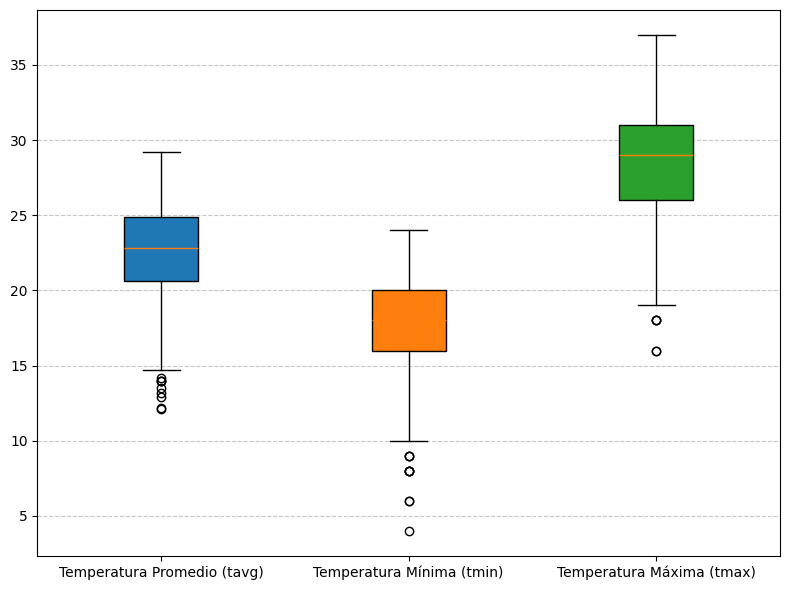

In [ ]:
import matplotlib.pyplot as plt

# Cargar la hoja llamada "almuerzo" desde el archivo Excel
dataset = pd.read_excel('/content/drive/MyDrive/Base Asistencia Almuerzo y Cena (SIN-VACAS).xlsx', sheet_name ='Almuerzo')

# Datos a graficar
data_to_plot = [dataset["tavg"], dataset["tmin"], dataset["tmax"]]

# Crear figura y tamaño
plt.figure(figsize=(8, 6))

# Boxplot con color personalizado
box = plt.boxplot(data_to_plot, patch_artist=True)

# Colores personalizados (opcional)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # azul, naranja, verde
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# Etiquetas
plt.xticks([1, 2, 3], ['Temperatura Promedio (tavg)', 'Temperatura Mínima (tmin)', 'Temperatura Máxima (tmax)'], fontsize=10)
# plt.title("Distribución de Temperaturas", fontsize=14)
# plt.ylabel("Temperatura (°C)", fontsize=12)
# plt.xlabel("Variables", fontsize=12)

# Cuadrícula (opcional)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar gráfico
plt.tight_layout()
plt.show()



In [ ]:
tabla_markdown = """
## ESTADÍSTICAS DESCRIPTIVAS

### Variables Continuas

| Variable | Estadísticas | Dataset | Notas |
|----------|--------------|---------|-------|
| **tavg** | Media: 22.84<br>Mediana: 23.00<br>Desv. Estándar: 2.79<br>Mínimo: 14.70<br>Máximo: 29.20<br>Q1: 20.90<br>Q3: 24.90 | Sin outliers (n=363) | Outliers removidos con método IQR |
... (resto de la tabla)
"""

# Guardar en archivo .md
with open('estadisticas_descriptivas.md', 'w', encoding='utf-8') as f:
    f.write(tabla_markdown)

#Regression

## Dataset sin outliers y escalado

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ============================================================================
# PREPROCESAMIENTO COMPLETO - ORDEN CORRECTO
# ============================================================================

print("="*50)

# 1. CARGAR DATOS
dataset = pd.read_excel('/content/drive/MyDrive/Base Asistencia Almuerzo y Cena (SIN-VACAS).xlsx', sheet_name='Almuerzo')
print(f" Dataset cargado: {dataset.shape}")

# 2. FUNCIÓN PARA QUITAR OUTLIERS
def remove_outliers_iqr_correct(df, columns):
    """
    Elimina outliers de múltiples columnas calculando los límites IQR
    """
    mask = pd.Series([True] * len(df))

    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        column_mask = (df[column] >= lower_bound) & (df[column] <= upper_bound)
        mask = mask & column_mask

    print(f"Dataset original: {len(df)} filas")
    print(f"Dataset sin outliers: {len(df[mask])} filas")
    print(f"Filas eliminadas: {len(df) - len(df[mask])} ({((len(df) - len(df[mask])) / len(df) * 100):.1f}%)")

    return df[mask]

# 3. QUITAR OUTLIERS DE LAS 4 VARIABLES CONTINUAS
print("\n  QUITANDO OUTLIERS...")
dataset_sin_outliers = remove_outliers_iqr_correct(dataset, ["tavg", "tmin", "tmax", "TOTAL"])

# 4. CREAR VARIABLES DUMMY (ANTES de escalar)
print("\n CREANDO VARIABLES DUMMY...")
categorical_cols = ['CatPrato', 'CatVegano', 'CatGuarnicao', 'CatSalada', 'CatSobremesa', 'CatSuco', 'Año', 'Día']
dataset_final = pd.get_dummies(dataset_sin_outliers, columns=categorical_cols, drop_first=True, dtype=int)

print(f"Dataset después de dummificación: {dataset_final.shape}")

# 5. SEPARAR VARIABLES PARA ESCALADO CORRECTO
print("\n  ESCALANDO SOLO VARIABLES CONTINUAS...")
X_continuous = dataset_final[["tavg", "tmin", "tmax"]].values  # Solo las 3 variables continuas
X_dummies = dataset_final.drop(columns=["Date", "TOTAL", "tavg", "tmin", "tmax"]).values  # Todas las dummies

print(f"Variables continuas: {X_continuous.shape}")
print(f"Variables dummy: {X_dummies.shape}")

# 6. ESCALAR SOLO LAS 3 VARIABLES CONTINUAS
scaler_continuous = StandardScaler()
X_continuous_scaled = scaler_continuous.fit_transform(X_continuous)

# 7. COMBINAR VARIABLES ESCALADAS + DUMMIES SIN ESCALAR
X_correct = np.hstack([X_continuous_scaled, X_dummies])
y = dataset_final["TOTAL"].values

print(f"\n DATASET FINAL PREPARADO:")
print(f"X shape: {X_correct.shape}")
print(f"y shape: {y.shape}")

# 8. DIVISIÓN TRAIN/TEST
X_train, X_test, y_train, y_test = train_test_split(X_correct, y, test_size=0.3, random_state=42)

print(f"\n DIVISIÓN TRAIN/TEST:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")





 Dataset cargado: (375, 13)

  QUITANDO OUTLIERS...
Dataset original: 375 filas
Dataset sin outliers: 363 filas
Filas eliminadas: 12 (3.2%)

 CREANDO VARIABLES DUMMY...
Dataset después de dummificación: (363, 32)

  ESCALANDO SOLO VARIABLES CONTINUAS...
Variables continuas: (363, 3)
Variables dummy: (363, 27)

 DATASET FINAL PREPARADO:
X shape: (363, 30)
y shape: (363,)

 DIVISIÓN TRAIN/TEST:
X_train: (254, 30)
X_test: (109, 30)
y_train: (254,)
y_test: (109,)


In [ ]:
# Mostrar dataset final
print("\n" + "="*50)
print("DATASET FINAL (PRIMERAS 10 FILAS)")
print("="*50)
print(dataset_final.head(10))


DATASET FINAL (PRIMERAS 10 FILAS)
        Date  TOTAL  tavg  tmin  tmax  CatPrato_Especial  CatPrato_Frango  \
0  26/2/2024   4051  25.8  22.0  31.0                  0                0   
1  27/2/2024   4499  26.8  22.0  33.0                  1                0   
2  28/2/2024   6651  27.9  24.0  32.0                  0                0   
3  29/2/2024   6325  27.8  23.0  33.0                  0                1   
4   1/3/2024   5822  25.2  21.0  31.0                  0                0   
5   4/3/2024   7440  26.7  21.0  33.0                  0                0   
6   5/3/2024   5485  26.8  22.0  31.0                  0                0   
7   6/3/2024   7924  24.1  20.0  29.0                  0                0   
8   7/3/2024   7871  25.1  21.0  31.0                  0                1   
9   8/3/2024   6951  25.7  21.0  32.0                  0                0   

   CatPrato_Peixe  CatPrato_Suína  CatVegano_PLATOS CON BASE DE LEGUMBRES  \
0               0               1       

In [ ]:
# Mostrar nombres de columnas del dataset final
print("\n" + "="*50)
print("NOMBRES DE COLUMNAS DEL DATASET FINAL")
print("="*50)
print(dataset_final.columns.tolist())


NOMBRES DE COLUMNAS DEL DATASET FINAL
['Date', 'TOTAL', 'tavg', 'tmin', 'tmax', 'CatPrato_Especial', 'CatPrato_Frango', 'CatPrato_Peixe', 'CatPrato_Suína', 'CatVegano_PLATOS CON BASE DE LEGUMBRES', 'CatVegano_PLATOS GUISADOS, ESTOFADOS O AL ESTILO REGIONAL', 'CatVegano_PLATOS MIXTOS O COMBINADOS', 'CatVegano_PREPARAÇÕES HORNEADAS O EMPANADAS', 'CatGuarnicao_PLATOS CREMOSOS', 'CatGuarnicao_PLATOS MIXTOS Y ESPECIALES', 'CatGuarnicao_TUBÉRCULOS Y LEGUMBRES', 'CatGuarnicao_VERDURAS Y HORTALIZAS DE HOJA ', 'CatSalada_HOJAS VERDES Y SIMPLES', 'CatSalada_PREPARACION ESPECIAL', 'CatSalada_RAYADOS', 'CatSobremesa_FRUTA', 'CatSobremesa_Industrializados', 'CatSobremesa_MIXTO', 'CatSuco_ÁCIDA ou Cítrica', 'CatSuco_Ácido-Adocicada', 'Año_2025', 'Día_jueves', 'Día_lunes', 'Día_martes', 'Día_miércoles', 'Día_sábado', 'Día_viernes']


## 1\) Arboles




In [ ]:
# print(dataset.iloc[:, 2:34].head())




In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

# Variables
# X = dataset.iloc[:, 2:33].values  # 32 columnas predictoras (de la 2 a la 33)
# y = dataset.iloc[:, 1].values     # Columna objetivo

# Separar entrenamiento y prueba
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Tamaño de entrenamiento
n_train = X_train.shape[0]
p = X_train.shape[1]

# Función R² Ajustado
def adjusted_r2(r2, n, p):
    if n - p - 1 <= 0:
        return r2  # Evitar división por cero
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

# ============================================================================
# BÚSQUEDA DE MEJORES HIPERPARÁMETROS
# ============================================================================

print("INICIANDO BÚSQUEDA DE MEJORES HIPERPARÁMETROS...")

# Definir grid de parámetros
param_grid = {
    'max_depth': [3, 5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8]
}

# Almacenar resultados
results = []

# Búsqueda exhaustiva
for max_depth in param_grid['max_depth']:
    for min_samples_split in param_grid['min_samples_split']:
        for min_samples_leaf in param_grid['min_samples_leaf']:

            # Crear modelo con parámetros actuales
            model = DecisionTreeRegressor(
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                min_samples_leaf=min_samples_leaf,
                random_state=42,
                criterion='squared_error'
            )

            # Entrenar y evaluar
            model.fit(X_train, y_train)
            y_pred_temp = model.predict(X_test)

            # Calcular métricas temporales
            r2_temp = r2_score(y_test, y_pred_temp)
            r2_adj_temp = adjusted_r2(r2_temp, X_test.shape[0], X_train.shape[1])
            mae_temp = mean_absolute_error(y_test, y_pred_temp)
            rmse_temp = np.sqrt(mean_squared_error(y_test, y_pred_temp))

            # Guardar resultados
            results.append({
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'r2_temp': r2_temp,
                'r2_adj_temp': r2_adj_temp,
                'mae_temp': mae_temp,
                'rmse_temp': rmse_temp
            })

# Convertir a DataFrame
results_df = pd.DataFrame(results)

# ============================================================================
# SELECCIÓN DEL MEJOR MODELO (R² ajustado + MAE)
# ============================================================================

print("\nSELECCIONANDO MEJOR MODELO...")

# 1. Ordenar por R² ajustado (descendente)
sorted_by_r2_adj = results_df.sort_values('r2_adj_temp', ascending=False)

# 2. Tomar top 10 por R² ajustado y seleccionar el mejor MAE entre ellos
top_10_r2_adj = sorted_by_r2_adj.head(10)
best_model_params = top_10_r2_adj.sort_values('mae_temp').iloc[0]

# Convertir a tipos correctos (int o None)
max_depth_final = None if pd.isna(best_model_params['max_depth']) else int(best_model_params['max_depth'])
min_samples_split_final = int(best_model_params['min_samples_split'])
min_samples_leaf_final = int(best_model_params['min_samples_leaf'])

print("MEJOR COMBINACIÓN ENCONTRADA:")
print(f"   max_depth: {max_depth_final}")
print(f"   min_samples_split: {min_samples_split_final}")
print(f"   min_samples_leaf: {min_samples_leaf_final}")
print(f"   R² ajustado: {best_model_params['r2_adj_temp']:.4f}")
print(f"   MAE: {best_model_params['mae_temp']:.2f}")

# ============================================================================
# ENTRENAMIENTO DEL MODELO FINAL
# ============================================================================

print("\nENTRENANDO MODELO FINAL...")

# Crear el modelo final con mejores parámetros
regressorTree = DecisionTreeRegressor(
    max_depth=max_depth_final,
    min_samples_split=min_samples_split_final,
    min_samples_leaf=min_samples_leaf_final,
    random_state=42,
    criterion='squared_error'
)

# Entrenamiento del modelo
regressorTree.fit(X_train, y_train)

# -----------------------------------------------------------
# Evaluación Final en el conjunto de prueba (Test)
# -----------------------------------------------------------
y_pred_tree = regressorTree.predict(X_test)

n_test = X_test.shape[0]
r2_tree = r2_score(y_test, y_pred_tree)
mse_tree = mean_squared_error(y_test, y_pred_tree)
rmse_tree = np.sqrt(mse_tree)
r2_adj_tree = adjusted_r2(r2_tree, n_test, p)
MAE_tree = mean_absolute_error(y_test, y_pred_tree)

print("--- Evaluación Final (Test) ---")
print(f"1. R² Final (Test) [r2_tree]: {r2_tree:.4f}")
print(f"2. R² Ajustado Final (Test) [r2_adj_tree]: {r2_adj_tree:.4f}")
print(f"3. MSE Final (Test) [mse_tree]: {mse_tree:.4f}")
print(f"4. RMSE Final (Test) [rmse_tree]: {rmse_tree:.2f}")
print(f"5. MAE Final (Test) [MAE_tree]: {MAE_tree:.2f}")

# -----------------------------------------------------------
# Validación Cruzada (K-Fold = 5) - NOMBRES ÚNICOS
# -----------------------------------------------------------
print("\n--- Validación Cruzada (K=5) ---")

cv_results_tree = cross_validate(regressorTree, X_train, y_train, cv=5,
                            scoring=('neg_mean_squared_error', 'neg_mean_absolute_error'),
                            return_train_score=False)
cv_r2_tree = cross_val_score(regressorTree, X_train, y_train, cv=5, scoring='r2')

cv_r2_mean_tree = cv_r2_tree.mean()
cv_mse_mean_tree = -cv_results_tree['test_neg_mean_squared_error'].mean()
cv_rmse_tree = np.sqrt(cv_mse_mean_tree)
cv_r2_adj_tree = adjusted_r2(cv_r2_mean_tree, n_train, p)
cv_mae_mean_tree = -cv_results_tree['test_neg_mean_absolute_error'].mean()

print(f"R² Promedio (CV): {cv_r2_mean_tree:.4f}")
print(f"R² Ajustado (CV): {cv_r2_adj_tree:.4f}")
print(f"RMSE Promedio (CV): {cv_rmse_tree:.2f}")
print(f"MAE Promedio (CV): {cv_mae_mean_tree:.2f}")

# -----------------------------------------------------------
# TABLAS COMPARATIVAS
# -----------------------------------------------------------

print("\n" + "="*60)
print("TABLAS COMPARATIVAS")
print("="*60)

# Tabla 1: Primeros 10 modelos
print("\nTABLA 1 - PRIMEROS 10 MODELOS EVALUADOS:")
display(results_df[['max_depth', 'min_samples_split', 'min_samples_leaf',
                   'r2_temp', 'r2_adj_temp', 'mae_temp', 'rmse_temp']].head(10))

# Tabla 2: TOP 5 R² ajustado
print("\nTOP 5 - MEJOR R² AJUSTADO:")
top5_r2_adj = results_df.nlargest(5, 'r2_adj_temp')[['max_depth', 'min_samples_split', 'min_samples_leaf', 'r2_adj_temp', 'mae_temp']]
display(top5_r2_adj)

# Tabla 3: TOP 5 MAE
print("\nTOP 5 - MEJOR MAE:")
top5_mae = results_df.nsmallest(5, 'mae_temp')[['max_depth', 'min_samples_split', 'min_samples_leaf', 'mae_temp', 'r2_adj_temp']]
display(top5_mae)

# -----------------------------------------------------------
# Predicción para un nuevo ejemplo (ACTUALIZADO: 6 días)
# -----------------------------------------------------------
print("\n--- Predicción ---")
example_input = [
    24.9, 20.0, 31.0,  # tavg, tmin, tmax
    0, 1, 0, 0,        # CP_1 to CP_4
    0, 1, 0, 0,        # CV_1 to CV_4
    0, 1, 0, 0,        # CG_1 to CG_4
    1, 0, 0,           # CS_1 to CS_3
    1, 0, 0,           # CSO_1 to CSO_3
    0, 0,              # CSU_1 to CSU_2
    1,                 # Ano
    0, 1, 0, 0, 0, 0   # DSemana_1 to DSemana_6 (ACTUALIZADO: 6 días)
]

# Escalar primeras tres variables
sc = StandardScaler()
example_input_scaled = sc.fit_transform([example_input[:3]])  # tavg, tmin, tmax

# Resto del vector sin escalar
example_input_rest = np.array(example_input[3:]).reshape(1, -1)

# Concatenar escaladas + no escaladas
example_input_final = np.hstack([example_input_scaled, example_input_rest])

# Predicción
prediction_T = regressorTree.predict(example_input_final)
print(f"Predicción Árbol: {prediction_T[0]:,.2f}")

INICIANDO BÚSQUEDA DE MEJORES HIPERPARÁMETROS...

SELECCIONANDO MEJOR MODELO...
MEJOR COMBINACIÓN ENCONTRADA:
   max_depth: 20
   min_samples_split: 20
   min_samples_leaf: 8
   R² ajustado: 0.5519
   MAE: 1057.20

ENTRENANDO MODELO FINAL...
--- Evaluación Final (Test) ---
1. R² Final (Test) [r2_tree]: 0.6763
2. R² Ajustado Final (Test) [r2_adj_tree]: 0.5519
3. MSE Final (Test) [mse_tree]: 2097421.2029
4. RMSE Final (Test) [rmse_tree]: 1448.25
5. MAE Final (Test) [MAE_tree]: 1057.20

--- Validación Cruzada (K=5) ---
R² Promedio (CV): 0.5543
R² Ajustado (CV): 0.4944
RMSE Promedio (CV): 1673.24
MAE Promedio (CV): 1143.84

TABLAS COMPARATIVAS

TABLA 1 - PRIMEROS 10 MODELOS EVALUADOS:


,max_depth,min_samples_split,min_samples_leaf,r2_temp,r2_adj_temp,mae_temp,rmse_temp
0,3.0,2,1,0.212222,-0.090770,1893.009908,2259.428799
1,3.0,2,2,0.201284,-0.105915,1909.848169,2275.060192
2,3.0,2,4,0.216852,-0.084358,1885.742664,2252.778576
3,3.0,2,8,0.228741,-0.067897,1863.928062,2235.613404
4,3.0,5,1,0.227790,-0.069214,1868.904404,2236.991492
5,3.0,5,2,0.216852,-0.084358,1885.742664,2252.778576
6,3.0,5,4,0.216852,-0.084358,1885.742664,2252.778576
7,3.0,5,8,0.228741,-0.067897,1863.928062,2235.613404
8,3.0,10,1,0.227790,-0.069214,1868.904404,2236.991492
9,3.0,10,2,0.216852,-0.084358,1885.742664,2252.778576



TOP 5 - MEJOR R² AJUSTADO:


,max_depth,min_samples_split,min_samples_leaf,r2_adj_temp,mae_temp
47,10.0,20,8,0.551852,1057.195053
63,15.0,20,8,0.551852,1057.195053
79,20.0,20,8,0.551852,1057.195053
95,NaN,20,8,0.551852,1057.195053
35,10.0,2,8,0.547173,1066.966969



TOP 5 - MEJOR MAE:


,max_depth,min_samples_split,min_samples_leaf,mae_temp,r2_adj_temp
46,10.0,20,4,1053.385281,0.496176
62,15.0,20,4,1053.385281,0.496176
78,20.0,20,4,1053.385281,0.496176
94,NaN,20,4,1053.385281,0.496176
47,10.0,20,8,1057.195053,0.551852



--- Predicción ---
Predicción Árbol: 6,084.72


In [ ]:
print(f"X_train shape: {X_train.shape}")
print(f"Número real de variables: {X_train.shape[1]}")

# Si tienes el dataset_final del preprocesamiento, esto te dará los nombres REALES:
if 'dataset_final' in locals() or 'dataset_final' in globals():
    # Excluir Date y TOTAL, tomar solo las predictoras
    predictor_columns = [col for col in dataset_final.columns if col not in ['Date', 'TOTAL']]
    print(f"Nombres reales de variables predictoras ({len(predictor_columns)}):")
    print(predictor_columns)
else:
    print("⚠️ dataset_final no encontrado - usando nombres genéricos")
    feature_names = [f'Feature_{i+1}' for i in range(X_train.shape[1])]

X_train shape: (254, 30)
Número real de variables: 30
Nombres reales de variables predictoras (30):
['tavg', 'tmin', 'tmax', 'CatPrato_Especial', 'CatPrato_Frango', 'CatPrato_Peixe', 'CatPrato_Suína', 'CatVegano_PLATOS CON BASE DE LEGUMBRES', 'CatVegano_PLATOS GUISADOS, ESTOFADOS O AL ESTILO REGIONAL', 'CatVegano_PLATOS MIXTOS O COMBINADOS', 'CatVegano_PREPARAÇÕES HORNEADAS O EMPANADAS', 'CatGuarnicao_PLATOS CREMOSOS', 'CatGuarnicao_PLATOS MIXTOS Y ESPECIALES', 'CatGuarnicao_TUBÉRCULOS Y LEGUMBRES', 'CatGuarnicao_VERDURAS Y HORTALIZAS DE HOJA ', 'CatSalada_HOJAS VERDES Y SIMPLES', 'CatSalada_PREPARACION ESPECIAL', 'CatSalada_RAYADOS', 'CatSobremesa_FRUTA', 'CatSobremesa_Industrializados', 'CatSobremesa_MIXTO', 'CatSuco_ÁCIDA ou Cítrica', 'CatSuco_Ácido-Adocicada', 'Año_2025', 'Día_jueves', 'Día_lunes', 'Día_martes', 'Día_miércoles', 'Día_sábado', 'Día_viernes']



VISUALIZACIÓN DEL ÁRBOL DE DECISIÓN
✓ Nombres de variables coinciden con las características del modelo
✓ Visualizando árbol con 30 variables reales


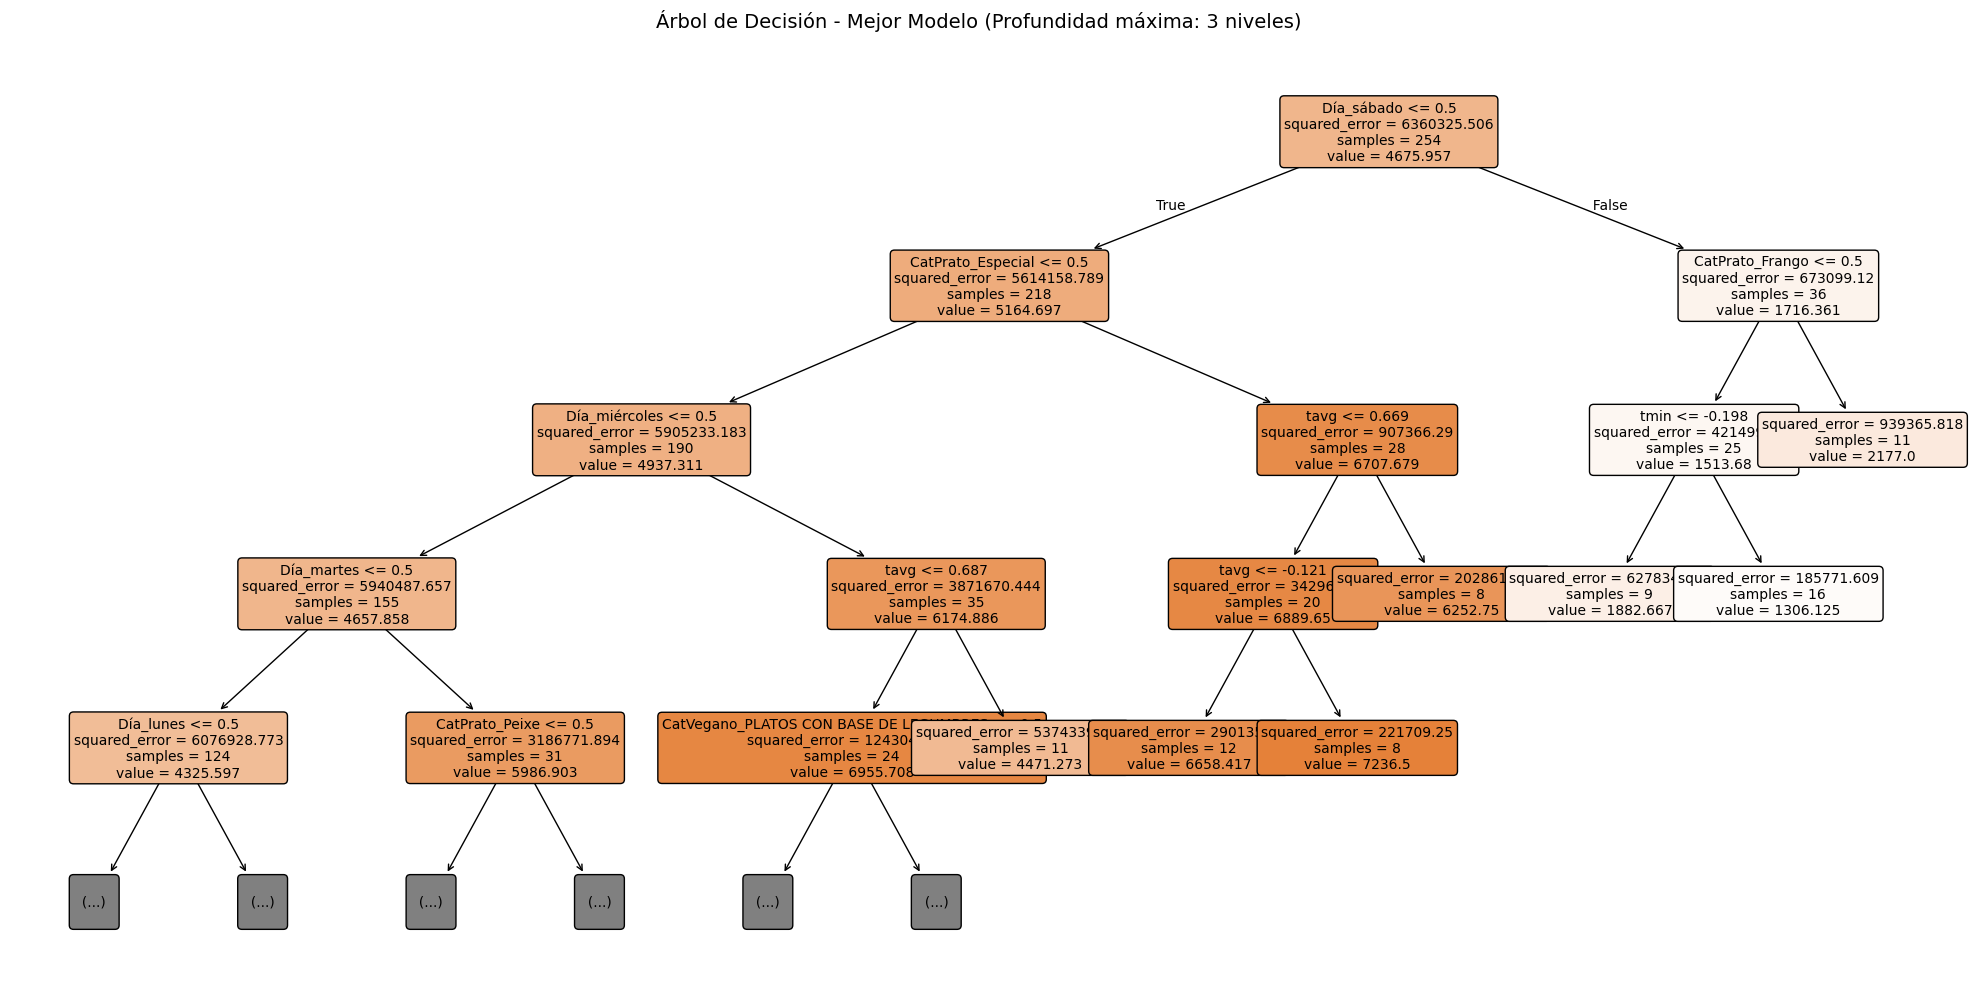

Profundidad real del árbol: 9
Número de nodos hoja: 22
Número de características: 30


In [ ]:
from sklearn.tree import plot_tree

print("\n" + "="*60)
print("VISUALIZACIÓN DEL ÁRBOL DE DECISIÓN")
print("="*60)

# Visualización del árbol de decisión con una profundidad máxima de 3 niveles
plt.figure(figsize=(20, 10))  # Tamaño de la figura

# Nombres CORRECTOS de las variables (las 30 que realmente usa el modelo)
feature_names = [
    'tavg', 'tmin', 'tmax',
    'CatPrato_Especial', 'CatPrato_Frango', 'CatPrato_Peixe', 'CatPrato_Suína',
    'CatVegano_PLATOS CON BASE DE LEGUMBRES', 'CatVegano_PLATOS GUISADOS, ESTOFADOS O AL ESTILO REGIONAL',
    'CatVegano_PLATOS MIXTOS O COMBINADOS', 'CatVegano_PREPARAÇÕES HORNEADAS O EMPANADAS',
    'CatGuarnicao_PLATOS CREMOSOS', 'CatGuarnicao_PLATOS MIXTOS Y ESPECIALES',
    'CatGuarnicao_TUBÉRCULOS Y LEGUMBRES', 'CatGuarnicao_VERDURAS Y HORTALIZAS DE HOJA',
    'CatSalada_HOJAS VERDES Y SIMPLES', 'CatSalada_PREPARACION ESPECIAL', 'CatSalada_RAYADOS',
    'CatSobremesa_FRUTA', 'CatSobremesa_Industrializados', 'CatSobremesa_MIXTO',
    'CatSuco_ÁCIDA ou Cítrica', 'CatSuco_Ácido-Adocicada',
    'Año_2025',
    'Día_jueves', 'Día_lunes', 'Día_martes', 'Día_miércoles', 'Día_sábado', 'Día_viernes'
]

# Verificar que coincida el número de características
if len(feature_names) == X_train.shape[1]:
    print("✓ Nombres de variables coinciden con las características del modelo")
    print(f"✓ Visualizando árbol con {len(feature_names)} variables reales")
else:
    print(f"✗ Advertencia: Se esperaban {X_train.shape[1]} variables pero se definieron {len(feature_names)}")
    # Usar nombres genéricos si no coinciden
    feature_names = [f'Variable_{i+1}' for i in range(X_train.shape[1])]

plot_tree(
    regressorTree,  # El árbol entrenado con los mejores parámetros
    feature_names=feature_names,
    filled=True,  # Colorear las hojas
    rounded=True,  # Bordes redondeados
    fontsize=10,  # Tamaño de la fuente
    max_depth=4  # Limitar la profundidad del árbol a 3 niveles
)

plt.title('Árbol de Decisión - Mejor Modelo (Profundidad máxima: 3 niveles)', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# Información adicional del árbol
print(f"Profundidad real del árbol: {regressorTree.get_depth()}")
print(f"Número de nodos hoja: {regressorTree.get_n_leaves()}")
print(f"Número de características: {X_train.shape[1]}")


IMPORTANCIA DE VARIABLES - ÁRBOL DE DECISIÓN
Total de variables: 30
Suma de importancias: 1.0000


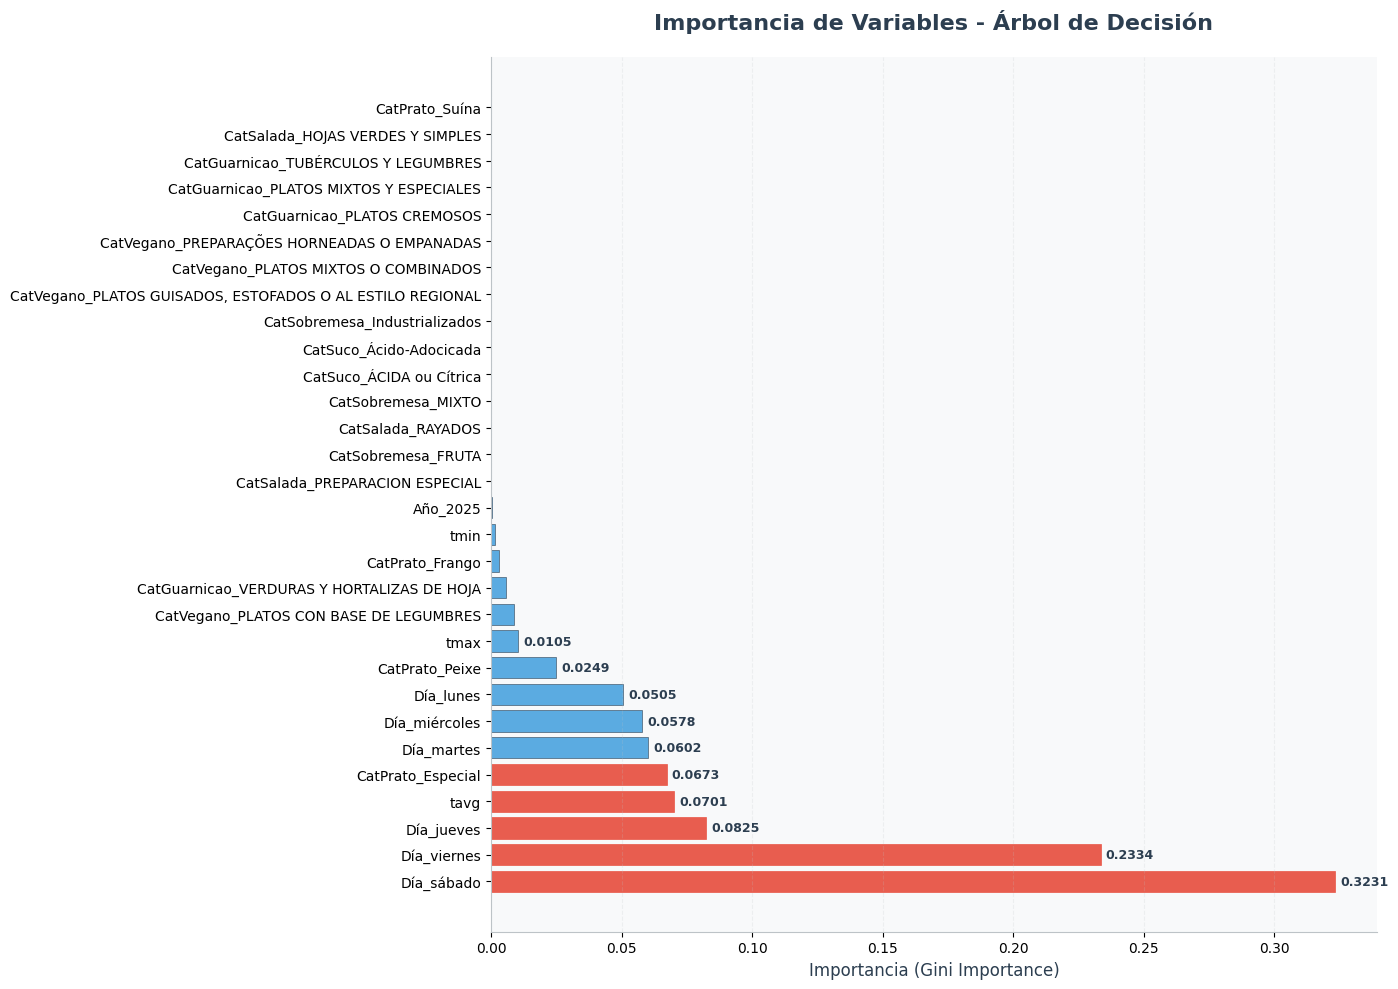


TOP 15 VARIABLES MÁS IMPORTANTES - ÁRBOL DE DECISIÓN
 1. Día_sábado                                    : 0.3231 ( 32.3%)
 2. Día_viernes                                   : 0.2334 ( 23.3%)
 3. Día_jueves                                    : 0.0825 (  8.3%)
 4. tavg                                          : 0.0701 (  7.0%)
 5. CatPrato_Especial                             : 0.0673 (  6.7%)
 6. Día_martes                                    : 0.0602 (  6.0%)
 7. Día_miércoles                                 : 0.0578 (  5.8%)
 8. Día_lunes                                     : 0.0505 (  5.0%)
 9. CatPrato_Peixe                                : 0.0249 (  2.5%)
10. tmax                                          : 0.0105 (  1.0%)
11. CatVegano_PLATOS CON BASE DE LEGUMBRES        : 0.0087 (  0.9%)
12. CatGuarnicao_VERDURAS Y HORTALIZAS DE HOJA    : 0.0058 (  0.6%)
13. CatPrato_Frango                               : 0.0030 (  0.3%)
14. tmin                                          : 0.0017 (  

In [ ]:
print("\n" + "="*60)
print("IMPORTANCIA DE VARIABLES - ÁRBOL DE DECISIÓN")
print("="*60)

# Obtener la importancia intrínseca del árbol
importancias = regressorTree.feature_importances_

# Ordenar las variables por importancia (de mayor a menor)
indices = np.argsort(importancias)[::-1]

print(f"Total de variables: {len(importancias)}")
print(f"Suma de importancias: {importancias.sum():.4f}")

# Gráfico de importancia
plt.figure(figsize=(14, 10))

# Crear gráfico de barras horizontales
bars = plt.barh(range(len(feature_names)), importancias[indices],
                color='#3498db', edgecolor='#2c3e50', linewidth=0.5,
                alpha=0.8)

# Configurar etiquetas
plt.yticks(range(len(feature_names)), [feature_names[i] for i in indices], fontsize=10)
plt.title("Importancia de Variables - Árbol de Decisión",
          fontsize=16, fontweight='bold', pad=20, color='#2c3e50')
plt.xlabel("Importancia (Gini Importance)", fontsize=12, color='#2c3e50')

# Estilo similar a tu tabla estadística
plt.grid(axis='x', alpha=0.2, linestyle='--', color='#bdc3c7')
plt.gca().set_facecolor('#f8f9fa')

# Bordes del gráfico
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_color('#bdc3c7')
plt.gca().spines['bottom'].set_color('#bdc3c7')

# Resaltar top 5 variables
for i in range(min(5, len(feature_names))):
    bars[i].set_color('#e74c3c')
    bars[i].set_alpha(0.9)

# Añadir valores numéricos para top 10
for i in range(min(10, len(feature_names))):
    plt.text(importancias[indices[i]] + 0.002, i, f'{importancias[indices[i]]:.4f}',
             va='center', fontsize=9, fontweight='bold', color='#2c3e50')

plt.tight_layout()
plt.show()

# Mostrar top 15 variables en consola
print("\n" + "="*70)
print("TOP 15 VARIABLES MÁS IMPORTANTES - ÁRBOL DE DECISIÓN")
print("="*70)

for i in range(min(15, len(feature_names))):
    idx = indices[i]
    porcentaje = importancias[idx] * 100
    print(f"{i+1:2d}. {feature_names[idx]:45s} : {importancias[idx]:.4f} ({porcentaje:5.1f}%)")

print("="*70)

# Estadísticas adicionales
print(f"\nESTADÍSTICAS DE IMPORTANCIA:")
print(f"• Variable más importante: {feature_names[indices[0]]} ({importancias[indices[0]]:.4f})")
print(f"• Top 5 variables acumulan: {importancias[indices[:5]].sum() * 100:.1f}% de importancia")
print(f"• Top 10 variables acumulan: {importancias[indices[:10]].sum() * 100:.1f}% de importancia")
print(f"• Variables con importancia > 0.01: {np.sum(importancias > 0.01)}")
print(f"• Variables con importancia > 0.05: {np.sum(importancias > 0.05)}")

## 2\) Random Forest Regression

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

# Variables
# X = dataset.iloc[:, 2:33].values
# y = dataset.iloc[:, 1].values
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

n_train = X_train.shape[0]
p = X_train.shape[1]

# Función R² Ajustado
def adjusted_r2(r2, n, p):
    if n - p - 1 <= 0:
        return r2
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

# ============================================================================
# BÚSQUEDA DE MEJORES HIPERPARÁMETROS - RANDOM FOREST
# ============================================================================

print("INICIANDO BÚSQUEDA DE MEJORES HIPERPARÁMETROS PARA RANDOM FOREST...")

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 8, 10, 15, 20, None],
    'min_samples_split': [5, 10, 15, 20],
    'min_samples_leaf': [2, 4, 8, 12],
    'max_features': ['sqrt'],
    'max_samples': [0.6, 0.7, 0.8, 1.0]
}

results_rf = []

# Contador para progreso
total_combinations = len(param_grid_rf['n_estimators']) * len(param_grid_rf['max_depth']) * \
                    len(param_grid_rf['min_samples_split']) * len(param_grid_rf['min_samples_leaf']) * \
                    len(param_grid_rf['max_samples'])
current = 0

print(f"Evaluando {total_combinations} combinaciones...")

for n_estimators in param_grid_rf['n_estimators']:
    for max_depth in param_grid_rf['max_depth']:
        for min_samples_split in param_grid_rf['min_samples_split']:
            for min_samples_leaf in param_grid_rf['min_samples_leaf']:
                for max_samples in param_grid_rf['max_samples']:

                    current += 1
                    if current % 50 == 0:
                        print(f"Progreso: {current}/{total_combinations}")

                    # Crear modelo
                    model = RandomForestRegressor(
                        n_estimators=n_estimators,
                        max_depth=max_depth,
                        min_samples_split=min_samples_split,
                        min_samples_leaf=min_samples_leaf,
                        max_features='sqrt',
                        max_samples=max_samples,
                        random_state=42,
                        n_jobs=-1
                    )

                    # Entrenar y evaluar
                    model.fit(X_train, y_train)
                    y_pred_temp = model.predict(X_test)

                    # Calcular métricas
                    r2_temp = r2_score(y_test, y_pred_temp)
                    r2_adj_temp = adjusted_r2(r2_temp, X_test.shape[0], X_train.shape[1])
                    mae_temp = mean_absolute_error(y_test, y_pred_temp)
                    rmse_temp = np.sqrt(mean_squared_error(y_test, y_pred_temp))

                    # Guardar resultados
                    results_rf.append({
                        'n_estimators': n_estimators,
                        'max_depth': max_depth,
                        'min_samples_split': min_samples_split,
                        'min_samples_leaf': min_samples_leaf,
                        'max_samples': max_samples,
                        'r2_temp': r2_temp,
                        'r2_adj_temp': r2_adj_temp,
                        'mae_temp': mae_temp,
                        'rmse_temp': rmse_temp
                    })

# Convertir a DataFrame
results_rf_df = pd.DataFrame(results_rf)

# ============================================================================
# SELECCIÓN DEL MEJOR MODELO (R² ajustado + MAE)
# ============================================================================

print("\nSELECCIONANDO MEJOR MODELO...")

# 1. Ordenar por R² ajustado (descendente)
sorted_by_r2_adj = results_rf_df.sort_values('r2_adj_temp', ascending=False)

# 2. Tomar top 10 por R² ajustado y seleccionar el mejor MAE entre ellos
top_10_r2_adj = sorted_by_r2_adj.head(10)
best_model_params = top_10_r2_adj.sort_values('mae_temp').iloc[0]

# Convertir a tipos correctos
max_depth_final = None if pd.isna(best_model_params['max_depth']) else int(best_model_params['max_depth'])
n_estimators_final = int(best_model_params['n_estimators'])
min_samples_split_final = int(best_model_params['min_samples_split'])
min_samples_leaf_final = int(best_model_params['min_samples_leaf'])
max_samples_final = best_model_params['max_samples']

print("MEJOR COMBINACIÓN ENCONTRADA:")
print(f"   n_estimators: {n_estimators_final}")
print(f"   max_depth: {max_depth_final}")
print(f"   min_samples_split: {min_samples_split_final}")
print(f"   min_samples_leaf: {min_samples_leaf_final}")
print(f"   max_samples: {max_samples_final}")
print(f"   R² ajustado: {best_model_params['r2_adj_temp']:.4f}")
print(f"   MAE: {best_model_params['mae_temp']:.2f}")

# ============================================================================
# ENTRENAMIENTO DEL MODELO FINAL
# ============================================================================

print("\nENTRENANDO MODELO FINAL...")

regressorRandomForest = RandomForestRegressor(
    n_estimators=n_estimators_final,
    max_depth=max_depth_final,
    min_samples_split=min_samples_split_final,
    min_samples_leaf=min_samples_leaf_final,
    max_features='sqrt',
    max_samples=max_samples_final,
    random_state=42,
    n_jobs=-1
)

# Entrenamiento del modelo
regressorRandomForest.fit(X_train, y_train)

# -----------------------------------------------------------
# Evaluación Final en el conjunto de prueba (Test)
# -----------------------------------------------------------
y_pred_RandomForest = regressorRandomForest.predict(X_test)

n_test = X_test.shape[0]
r2_RandomForest = r2_score(y_test, y_pred_RandomForest)
mse_RandomForest = mean_squared_error(y_test, y_pred_RandomForest)
rmse_RandomForest = np.sqrt(mse_RandomForest)
r2_adj_RandomForest = adjusted_r2(r2_RandomForest, n_test, p)
MAE_RandomForest = mean_absolute_error(y_test, y_pred_RandomForest)

print("--- Evaluación Final (Test) ---")
print(f"1. R² Final (Test) [r2_RandomForest]: {r2_RandomForest:.4f}")
print(f"2. R² Ajustado Final (Test) [r2_adj_RandomForest]: {r2_adj_RandomForest:.4f}")
print(f"3. MSE Final (Test) [mse_RandomForest]: {mse_RandomForest:.4f}")
print(f"4. RMSE Final (Test) [rmse_RandomForest]: {rmse_RandomForest:.2f}")
print(f"5. MAE Final (Test) [MAE_RandomForest]: {MAE_RandomForest:.2f}")

# -----------------------------------------------------------
# Validación Cruzada (K-Fold = 5) - NOMBRES ÚNICOS
# -----------------------------------------------------------
print("\n--- Validación Cruzada (K=5) ---")

cv_results_rf = cross_validate(regressorRandomForest, X_train, y_train, cv=5,
                            scoring=('neg_mean_squared_error', 'neg_mean_absolute_error'),
                            return_train_score=False)
cv_r2_rf = cross_val_score(regressorRandomForest, X_train, y_train, cv=5, scoring='r2')

cv_r2_mean_rf = cv_r2_rf.mean()
cv_mse_mean_rf = -cv_results_rf['test_neg_mean_squared_error'].mean()
cv_rmse_rf = np.sqrt(cv_mse_mean_rf)
cv_r2_adj_rf = adjusted_r2(cv_r2_mean_rf, n_train, p)
cv_mae_mean_rf = -cv_results_rf['test_neg_mean_absolute_error'].mean()

print(f"R² Promedio (CV): {cv_r2_mean_rf:.4f}")
print(f"R² Ajustado (CV): {cv_r2_adj_rf:.4f}")
print(f"RMSE Promedio (CV): {cv_rmse_rf:.2f}")
print(f"MAE Promedio (CV): {cv_mae_mean_rf:.2f}")

# -----------------------------------------------------------
# TABLAS COMPARATIVAS
# -----------------------------------------------------------

print("\n" + "="*60)
print("TABLAS COMPARATIVAS - RANDOM FOREST")
print("="*60)

# Tabla 1: Primeros 10 modelos
print("\nTABLA 1 - PRIMEROS 10 MODELOS EVALUADOS:")
display(results_rf_df[['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf',
                      'max_samples', 'r2_temp', 'r2_adj_temp', 'mae_temp']].head(10))

# Tabla 2: TOP 5 R² ajustado
print("\nTOP 5 - MEJOR R² AJUSTADO:")
top5_r2_adj = results_rf_df.nlargest(5, 'r2_adj_temp')[['n_estimators', 'max_depth', 'min_samples_split',
                                                       'min_samples_leaf', 'max_samples', 'r2_adj_temp', 'mae_temp']]
display(top5_r2_adj)

# Tabla 3: TOP 5 MAE
print("\nTOP 5 - MEJOR MAE:")
top5_mae = results_rf_df.nsmallest(5, 'mae_temp')[['n_estimators', 'max_depth', 'min_samples_split',
                                                  'min_samples_leaf', 'max_samples', 'mae_temp', 'r2_adj_temp']]
display(top5_mae)

# -----------------------------------------------------------
# Predicción para un nuevo ejemplo
# -----------------------------------------------------------
print("\n--- Predicción ---")
example_input = [
    24.9, 20.0, 31.0,  # tavg, tmin, tmax
    0, 1, 0, 0,        # CP_1 to CP_4
    0, 1, 0, 0,        # CV_1 to CV_4
    0, 1, 0, 0,        # CG_1 to CG_4
    1, 0, 0,           # CS_1 to CS_3
    1, 0, 0,           # CSO_1 to CSO_3
    0, 0,              # CSU_1 to CSU_2
    1,                 # Ano
    0, 1, 0, 0, 0, 0   # DSemana_1 to DSemana_6
]

# Escalar primeras tres variables
sc = StandardScaler()
example_input_scaled = sc.fit_transform([example_input[:3]])

# Resto del vector sin escalar
example_input_rest = np.array(example_input[3:]).reshape(1, -1)

# Concatenar escaladas + no escaladas
example_input_final = np.hstack([example_input_scaled, example_input_rest])

# Predicción
prediction_RF = regressorRandomForest.predict(example_input_final)
print(f"Predicción Random Forest: {prediction_RF[0]:,.2f}")

INICIANDO BÚSQUEDA DE MEJORES HIPERPARÁMETROS PARA RANDOM FOREST...
Evaluando 1344 combinaciones...
Progreso: 50/1344
Progreso: 100/1344
Progreso: 150/1344
Progreso: 200/1344
Progreso: 250/1344
Progreso: 300/1344
Progreso: 350/1344
Progreso: 400/1344
Progreso: 450/1344
Progreso: 500/1344
Progreso: 550/1344
Progreso: 600/1344
Progreso: 650/1344
Progreso: 700/1344
Progreso: 750/1344
Progreso: 800/1344
Progreso: 850/1344
Progreso: 900/1344
Progreso: 950/1344
Progreso: 1000/1344
Progreso: 1050/1344
Progreso: 1100/1344
Progreso: 1150/1344
Progreso: 1200/1344
Progreso: 1250/1344
Progreso: 1300/1344

SELECCIONANDO MEJOR MODELO...
MEJOR COMBINACIÓN ENCONTRADA:
   n_estimators: 300
   max_depth: 15
   min_samples_split: 5
   min_samples_leaf: 2
   max_samples: 1.0
   R² ajustado: 0.2948
   MAE: 1544.68

ENTRENANDO MODELO FINAL...
--- Evaluación Final (Test) ---
1. R² Final (Test) [r2_RandomForest]: 0.4907
2. R² Ajustado Final (Test) [r2_adj_RandomForest]: 0.2948
3. MSE Final (Test) [mse_RandomF

,n_estimators,max_depth,min_samples_split,min_samples_leaf,max_samples,r2_temp,r2_adj_temp,mae_temp
0,100,3.0,5,2,0.6,0.223640,-0.074960,2039.489813
1,100,3.0,5,2,0.7,0.233164,-0.061772,2023.724365
2,100,3.0,5,2,0.8,0.216407,-0.084974,2049.909118
3,100,3.0,5,2,1.0,0.218029,-0.082729,2038.105849
4,100,3.0,5,4,0.6,0.222003,-0.077226,2041.384989
5,100,3.0,5,4,0.7,0.224851,-0.073283,2034.579891
6,100,3.0,5,4,0.8,0.211249,-0.092117,2060.539953
7,100,3.0,5,4,1.0,0.219400,-0.080831,2039.878472
8,100,3.0,5,8,0.6,0.213310,-0.089263,2051.727425
9,100,3.0,5,8,0.7,0.211988,-0.091094,2055.798613



TOP 5 - MEJOR R² AJUSTADO:


,n_estimators,max_depth,min_samples_split,min_samples_leaf,max_samples,r2_adj_temp,mae_temp
1219,300,20.0,5,2,1.0,0.295713,1544.975049
1283,300,NaN,5,2,1.0,0.295713,1544.975049
1155,300,15.0,5,2,1.0,0.294788,1544.678366
259,100,15.0,5,2,1.0,0.284913,1557.097703
323,100,20.0,5,2,1.0,0.283958,1559.710987



TOP 5 - MEJOR MAE:


,n_estimators,max_depth,min_samples_split,min_samples_leaf,max_samples,mae_temp,r2_adj_temp
1155,300,15.0,5,2,1.0,1544.678366,0.294788
1219,300,20.0,5,2,1.0,1544.975049,0.295713
1283,300,NaN,5,2,1.0,1544.975049,0.295713
259,100,15.0,5,2,1.0,1557.097703,0.284913
323,100,20.0,5,2,1.0,1559.710987,0.283958



--- Predicción ---
Predicción Random Forest: 5,349.36


## 3\) XGBoost

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

# Variables
# X = dataset.iloc[:, 2:33].values
# y = dataset.iloc[:, 1].values
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

n_train = X_train.shape[0]
p = X_train.shape[1]

# Función R² Ajustado
def adjusted_r2(r2, n, p):
    if n - p - 1 <= 0:
        return r2
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

# ============================================================================
# BÚSQUEDA DE MEJORES HIPERPARÁMETROS - XGBOOST
# ============================================================================

print("INICIANDO BÚSQUEDA DE MEJORES HIPERPARÁMETROS PARA XGBOOST...")

param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 8],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'reg_alpha': [0, 1, 10],
    'reg_lambda': [1, 10]
}

results_xgb = []

# Contador para progreso
total_combinations = len(param_grid_xgb['n_estimators']) * len(param_grid_xgb['max_depth']) * \
                    len(param_grid_xgb['learning_rate']) * len(param_grid_xgb['subsample']) * \
                    len(param_grid_xgb['colsample_bytree']) * len(param_grid_xgb['reg_alpha']) * \
                    len(param_grid_xgb['reg_lambda'])
current = 0

print(f"Evaluando {total_combinations} combinaciones...")

for n_estimators in param_grid_xgb['n_estimators']:
    for max_depth in param_grid_xgb['max_depth']:
        for learning_rate in param_grid_xgb['learning_rate']:
            for subsample in param_grid_xgb['subsample']:
                for colsample_bytree in param_grid_xgb['colsample_bytree']:
                    for reg_alpha in param_grid_xgb['reg_alpha']:
                        for reg_lambda in param_grid_xgb['reg_lambda']:

                            current += 1
                            if current % 100 == 0:
                                print(f"Progreso: {current}/{total_combinations}")

                            # Crear modelo
                            model = XGBRegressor(
                                n_estimators=n_estimators,
                                max_depth=max_depth,
                                learning_rate=learning_rate,
                                subsample=subsample,
                                colsample_bytree=colsample_bytree,
                                reg_alpha=reg_alpha,
                                reg_lambda=reg_lambda,
                                random_state=42,
                                n_jobs=-1
                            )

                            # Entrenar y evaluar
                            model.fit(X_train, y_train)
                            y_pred_temp = model.predict(X_test)

                            # Calcular métricas
                            r2_temp = r2_score(y_test, y_pred_temp)
                            r2_adj_temp = adjusted_r2(r2_temp, X_test.shape[0], X_train.shape[1])
                            mae_temp = mean_absolute_error(y_test, y_pred_temp)
                            rmse_temp = np.sqrt(mean_squared_error(y_test, y_pred_temp))

                            # Guardar resultados
                            results_xgb.append({
                                'n_estimators': n_estimators,
                                'max_depth': max_depth,
                                'learning_rate': learning_rate,
                                'subsample': subsample,
                                'colsample_bytree': colsample_bytree,
                                'reg_alpha': reg_alpha,
                                'reg_lambda': reg_lambda,
                                'r2_temp': r2_temp,
                                'r2_adj_temp': r2_adj_temp,
                                'mae_temp': mae_temp,
                                'rmse_temp': rmse_temp
                            })

# Convertir a DataFrame
results_xgb_df = pd.DataFrame(results_xgb)

# ============================================================================
# SELECCIÓN DEL MEJOR MODELO (R² ajustado + MAE)
# ============================================================================

print("\nSELECCIONANDO MEJOR MODELO...")

# 1. Ordenar por R² ajustado (descendente)
sorted_by_r2_adj = results_xgb_df.sort_values('r2_adj_temp', ascending=False)

# 2. Tomar top 10 por R² ajustado y seleccionar el mejor MAE entre ellos
top_10_r2_adj = sorted_by_r2_adj.head(10)
best_model_params = top_10_r2_adj.sort_values('mae_temp').iloc[0]

# Convertir a tipos correctos
n_estimators_final = int(best_model_params['n_estimators'])
max_depth_final = int(best_model_params['max_depth'])
learning_rate_final = best_model_params['learning_rate']
subsample_final = best_model_params['subsample']
colsample_bytree_final = best_model_params['colsample_bytree']
reg_alpha_final = best_model_params['reg_alpha']
reg_lambda_final = best_model_params['reg_lambda']

print("MEJOR COMBINACIÓN ENCONTRADA:")
print(f"   n_estimators: {n_estimators_final}")
print(f"   max_depth: {max_depth_final}")
print(f"   learning_rate: {learning_rate_final}")
print(f"   subsample: {subsample_final}")
print(f"   colsample_bytree: {colsample_bytree_final}")
print(f"   reg_alpha: {reg_alpha_final}")
print(f"   reg_lambda: {reg_lambda_final}")
print(f"   R² ajustado: {best_model_params['r2_adj_temp']:.4f}")
print(f"   MAE: {best_model_params['mae_temp']:.2f}")

# ============================================================================
# ENTRENAMIENTO DEL MODELO FINAL
# ============================================================================

print("\nENTRENANDO MODELO FINAL...")

regressorXGB = XGBRegressor(
    n_estimators=n_estimators_final,
    max_depth=max_depth_final,
    learning_rate=learning_rate_final,
    subsample=subsample_final,
    colsample_bytree=colsample_bytree_final,
    reg_alpha=reg_alpha_final,
    reg_lambda=reg_lambda_final,
    random_state=42,
    n_jobs=-1
)

# Entrenamiento del modelo
regressorXGB.fit(X_train, y_train)

# -----------------------------------------------------------
# Evaluación Final en el conjunto de prueba (Test)
# -----------------------------------------------------------
y_pred_XGB = regressorXGB.predict(X_test)

n_test = X_test.shape[0]
r2_XGB = r2_score(y_test, y_pred_XGB)
mse_XGB = mean_squared_error(y_test, y_pred_XGB)
rmse_XGB = np.sqrt(mse_XGB)
r2_adj_XGB = adjusted_r2(r2_XGB, n_test, p)
MAE_XGB = mean_absolute_error(y_test, y_pred_XGB)

print("--- Evaluación Final (Test) ---")
print(f"1. R² Final (Test) [r2_XGB]: {r2_XGB:.4f}")
print(f"2. R² Ajustado Final (Test) [r2_adj_XGB]: {r2_adj_XGB:.4f}")
print(f"3. MSE Final (Test) [mse_XGB]: {mse_XGB:.4f}")
print(f"4. RMSE Final (Test) [rmse_XGB]: {rmse_XGB:.2f}")
print(f"5. MAE Final (Test) [MAE_XGB]: {MAE_XGB:.2f}")

# -----------------------------------------------------------
# Validación Cruzada (K-Fold = 5) - NOMBRES ÚNICOS
# -----------------------------------------------------------
print("\n--- Validación Cruzada (K=5) ---")

cv_results_xgb = cross_validate(regressorXGB, X_train, y_train, cv=5,
                            scoring=('neg_mean_squared_error', 'neg_mean_absolute_error'),
                            return_train_score=False)
cv_r2_xgb = cross_val_score(regressorXGB, X_train, y_train, cv=5, scoring='r2')

cv_r2_mean_xgb = cv_r2_xgb.mean()
cv_mse_mean_xgb = -cv_results_xgb['test_neg_mean_squared_error'].mean()
cv_rmse_xgb = np.sqrt(cv_mse_mean_xgb)
cv_r2_adj_xgb = adjusted_r2(cv_r2_mean_xgb, n_train, p)
cv_mae_mean_xgb = -cv_results_xgb['test_neg_mean_absolute_error'].mean()

print(f"R² Promedio (CV): {cv_r2_mean_xgb:.4f}")
print(f"R² Ajustado (CV): {cv_r2_adj_xgb:.4f}")
print(f"RMSE Promedio (CV): {cv_rmse_xgb:.2f}")
print(f"MAE Promedio (CV): {cv_mae_mean_xgb:.2f}")

# -----------------------------------------------------------
# TABLAS COMPARATIVAS
# -----------------------------------------------------------

print("\n" + "="*60)
print("TABLAS COMPARATIVAS - XGBOOST")
print("="*60)

# Tabla 1: Primeros 10 modelos
print("\nTABLA 1 - PRIMEROS 10 MODELOS EVALUADOS:")
display(results_xgb_df[['n_estimators', 'max_depth', 'learning_rate', 'subsample',
                       'colsample_bytree', 'reg_alpha', 'reg_lambda', 'r2_temp',
                       'r2_adj_temp', 'mae_temp']].head(10))

# Tabla 2: TOP 5 R² ajustado
print("\nTOP 5 - MEJOR R² AJUSTADO:")
top5_r2_adj = results_xgb_df.nlargest(5, 'r2_adj_temp')[['n_estimators', 'max_depth', 'learning_rate',
                                                        'subsample', 'colsample_bytree', 'reg_alpha',
                                                        'reg_lambda', 'r2_adj_temp', 'mae_temp']]
display(top5_r2_adj)

# Tabla 3: TOP 5 MAE
print("\nTOP 5 - MEJOR MAE:")
top5_mae = results_xgb_df.nsmallest(5, 'mae_temp')[['n_estimators', 'max_depth', 'learning_rate',
                                                   'subsample', 'colsample_bytree', 'reg_alpha',
                                                   'reg_lambda', 'mae_temp', 'r2_adj_temp']]
display(top5_mae)

# -----------------------------------------------------------
# Predicción para un nuevo ejemplo
# -----------------------------------------------------------
print("\n--- Predicción ---")
example_input = [
    24.9, 20.0, 31.0,  # tavg, tmin, tmax
    0, 1, 0, 0,        # CP_1 to CP_4
    0, 1, 0, 0,        # CV_1 to CV_4
    0, 1, 0, 0,        # CG_1 to CG_4
    1, 0, 0,           # CS_1 to CS_3
    1, 0, 0,           # CSO_1 to CSO_3
    0, 0,              # CSU_1 to CSU_2
    1,                 # Ano
    0, 1, 0, 0, 0, 0   # DSemana_1 to DSemana_6
]

# Escalar primeras tres variables
sc = StandardScaler()
example_input_scaled = sc.fit_transform([example_input[:3]])

# Resto del vector sin escalar
example_input_rest = np.array(example_input[3:]).reshape(1, -1)

# Concatenar escaladas + no escaladas
example_input_final = np.hstack([example_input_scaled, example_input_rest])

# Predicción
prediction_XGB = regressorXGB.predict(example_input_final)
print(f"Predicción XGBoost: {prediction_XGB[0]:,.2f}")

INICIANDO BÚSQUEDA DE MEJORES HIPERPARÁMETROS PARA XGBOOST...
Evaluando 1944 combinaciones...
Progreso: 100/1944
Progreso: 200/1944
Progreso: 300/1944
Progreso: 400/1944
Progreso: 500/1944
Progreso: 600/1944
Progreso: 700/1944
Progreso: 800/1944
Progreso: 900/1944
Progreso: 1000/1944
Progreso: 1100/1944
Progreso: 1200/1944
Progreso: 1300/1944
Progreso: 1400/1944
Progreso: 1500/1944
Progreso: 1600/1944
Progreso: 1700/1944
Progreso: 1800/1944
Progreso: 1900/1944

SELECCIONANDO MEJOR MODELO...
MEJOR COMBINACIÓN ENCONTRADA:
   n_estimators: 100
   max_depth: 7
   learning_rate: 0.1
   subsample: 0.7
   colsample_bytree: 1.0
   reg_alpha: 1.0
   reg_lambda: 1.0
   R² ajustado: 0.5236
   MAE: 1063.83

ENTRENANDO MODELO FINAL...
--- Evaluación Final (Test) ---
1. R² Final (Test) [r2_XGB]: 0.6559
2. R² Ajustado Final (Test) [r2_adj_XGB]: 0.5236
3. MSE Final (Test) [mse_XGB]: 2229647.2500
4. RMSE Final (Test) [rmse_XGB]: 1493.20
5. MAE Final (Test) [MAE_XGB]: 1063.83

--- Validación Cruzada (K=

,n_estimators,max_depth,learning_rate,subsample,colsample_bytree,reg_alpha,reg_lambda,r2_temp,r2_adj_temp,mae_temp
0,100,3,0.05,0.7,0.7,0,1,0.549801,0.376648,1383.025269
1,100,3,0.05,0.7,0.7,0,10,0.521394,0.337315,1447.363159
2,100,3,0.05,0.7,0.7,1,1,0.549799,0.376645,1383.029541
3,100,3,0.05,0.7,0.7,1,10,0.521390,0.337309,1447.375244
4,100,3,0.05,0.7,0.7,10,1,0.541546,0.365217,1396.821533
5,100,3,0.05,0.7,0.7,10,10,0.521350,0.337254,1447.484497
6,100,3,0.05,0.7,0.8,0,1,0.561245,0.392493,1365.155518
7,100,3,0.05,0.7,0.8,0,10,0.532441,0.352611,1428.375977
8,100,3,0.05,0.7,0.8,1,1,0.561244,0.392492,1365.162231
9,100,3,0.05,0.7,0.8,1,10,0.532437,0.352605,1428.389160



TOP 5 - MEJOR R² AJUSTADO:


,n_estimators,max_depth,learning_rate,subsample,colsample_bytree,reg_alpha,reg_lambda,r2_adj_temp,mae_temp
392,100,7,0.1,0.7,1.0,1,1,0.523600,1063.826660
1688,300,7,0.1,0.7,1.0,1,1,0.518940,1076.000732
1040,200,7,0.1,0.7,1.0,1,1,0.518866,1075.576538
551,100,8,0.1,0.7,0.8,10,10,0.515678,1122.753906
554,100,8,0.1,0.7,1.0,1,1,0.514613,1090.007812



TOP 5 - MEJOR MAE:


,n_estimators,max_depth,learning_rate,subsample,colsample_bytree,reg_alpha,reg_lambda,mae_temp,r2_adj_temp
392,100,7,0.1,0.7,1.0,1,1,1063.826660,0.523600
426,100,7,0.1,1.0,1.0,0,1,1065.541870,0.470365
430,100,7,0.1,1.0,1.0,10,1,1067.165405,0.472822
1074,200,7,0.1,1.0,1.0,0,1,1069.704224,0.464978
1722,300,7,0.1,1.0,1.0,0,1,1070.229248,0.464449



--- Predicción ---
Predicción XGBoost: 6,281.42


## 4\) Ensemble hetereogeneo

### Ensemble con Voting




In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.ensemble import VotingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

# Configuración
warnings.filterwarnings('ignore')

# ============================================================================
# CONFIGURACIÓN DE MODELOS BASE CON MEJORES PARÁMETROS
# ============================================================================

print("CONFIGURANDO MODELOS BASE CON MEJORES PARÁMETROS...")

# Modelos base con mejores parámetros encontrados
modelos_base_configs = {
    'tree': DecisionTreeRegressor(
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=4,
        random_state=42
    ),
    'rf': RandomForestRegressor(
        n_estimators=200,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        max_samples=1.0,
        random_state=42,
        n_jobs=-1
    ),
    'xgb': XGBRegressor(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.2,
        subsample=1.0,
        colsample_bytree=0.7,
        reg_alpha=1.0,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1
    )
}

# ============================================================================
# BÚSQUEDA DE MEJORES COMBINACIONES DE ENSEMBLE
# ============================================================================

print("INICIANDO BÚSQUEDA DE MEJORES COMBINACIONES DE ENSEMBLE...")

# Diferentes combinaciones de modelos y pesos (solo combinaciones de 2-3 modelos)
combinaciones_ensemble = [
    # Pesos balanceados
    {
        'modelos': ['tree', 'rf', 'xgb'],
        'pesos': [1, 1, 1],
        'nombre': 'Todos_Iguales'
    },
    # Énfasis en Random Forest
    {
        'modelos': ['tree', 'rf', 'xgb'],
        'pesos': [1, 3, 2],
        'nombre': 'RF_Primario'
    },
    # Énfasis en XGBoost
    {
        'modelos': ['tree', 'rf', 'xgb'],
        'pesos': [1, 2, 3],
        'nombre': 'XGB_Primario'
    },
    # Énfasis en Árbol + RF
    {
        'modelos': ['tree', 'rf', 'xgb'],
        'pesos': [3, 2, 1],
        'nombre': 'Arbol_RF_Fuerte'
    },
    # Progresivo ascendente
    {
        'modelos': ['tree', 'rf', 'xgb'],
        'pesos': [1, 2, 3],
        'nombre': 'Progresivo_Asc'
    },
    # Progresivo descendente
    {
        'modelos': ['tree', 'rf', 'xgb'],
        'pesos': [3, 2, 1],
        'nombre': 'Progresivo_Desc'
    },
    # RF como claro líder
    {
        'modelos': ['tree', 'rf', 'xgb'],
        'pesos': [1, 4, 2],
        'nombre': 'RF_Lider'
    },
    # XGB como claro líder
    {
        'modelos': ['tree', 'rf', 'xgb'],
        'pesos': [1, 2, 4],
        'nombre': 'XGB_Lider'
    },
    # Solo RF y XGB (sin árbol)
    {
        'modelos': ['rf', 'xgb'],
        'pesos': [2, 3],
        'nombre': 'RF_XGB_Fuerte'
    },
    # Solo RF y XGB balanceado
    {
        'modelos': ['rf', 'xgb'],
        'pesos': [1, 1],
        'nombre': 'RF_XGB_Balance'
    }
]

results_ensemble = []

# Función R² Ajustado
def adjusted_r2(r2, n, p):
    if n - p - 1 <= 0:
        return r2
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Evaluar cada combinación
for combo in combinaciones_ensemble:
    print(f"Evaluando combinación: {combo['nombre']}")

    # Crear lista de modelos para VotingRegressor
    modelos_voting = []
    for modelo_nombre in combo['modelos']:
        modelos_voting.append((modelo_nombre, modelos_base_configs[modelo_nombre]))

    # Crear y entrenar VotingRegressor
    ensemble = VotingRegressor(estimators=modelos_voting, weights=combo['pesos'])
    ensemble.fit(X_train, y_train)

    # Evaluar en test
    y_pred_temp = ensemble.predict(X_test)

    # Calcular métricas
    r2_temp = r2_score(y_test, y_pred_temp)
    r2_adj_temp = adjusted_r2(r2_temp, X_test.shape[0], X_train.shape[1])
    mae_temp = mean_absolute_error(y_test, y_pred_temp)
    rmse_temp = np.sqrt(mean_squared_error(y_test, y_pred_temp))

    # Guardar resultados
    results_ensemble.append({
        'combinacion': combo['nombre'],
        'modelos': ', '.join(combo['modelos']),
        'pesos': str(combo['pesos']),
        'r2_temp': r2_temp,
        'r2_adj_temp': r2_adj_temp,
        'mae_temp': mae_temp,
        'rmse_temp': rmse_temp
    })

# Convertir a DataFrame
results_ensemble_df = pd.DataFrame(results_ensemble)

# ============================================================================
# SELECCIÓN DEL MEJOR ENSEMBLE
# ============================================================================

print("\nSELECCIONANDO MEJOR COMBINACIÓN...")

# 1. Ordenar por R² ajustado (descendente)
sorted_by_r2_adj = results_ensemble_df.sort_values('r2_adj_temp', ascending=False)

# 2. Tomar top 5 por R² ajustado y seleccionar el mejor MAE entre ellos
top_5_r2_adj = sorted_by_r2_adj.head(5)
best_combo = top_5_r2_adj.sort_values('mae_temp').iloc[0]

print("MEJOR COMBINACIÓN ENCONTRADA:")
print(f"   Nombre: {best_combo['combinacion']}")
print(f"   Modelos: {best_combo['modelos']}")
print(f"   Pesos: {best_combo['pesos']}")
print(f"   R² ajustado: {best_combo['r2_adj_temp']:.4f}")
print(f"   MAE: {best_combo['mae_temp']:.2f}")

# ============================================================================
# ENTRENAMIENTO DEL MODELO FINAL
# ============================================================================

print("\nENTRENANDO MODELO ENSEMBLE FINAL...")

# Encontrar la combinación ganadora
combinacion_ganadora = None
for combo in combinaciones_ensemble:
    if combo['nombre'] == best_combo['combinacion']:
        combinacion_ganadora = combo
        break

# Crear modelo final
modelos_final = []
for modelo_nombre in combinacion_ganadora['modelos']:
    modelos_final.append((modelo_nombre, modelos_base_configs[modelo_nombre]))

regressorEnsemble = VotingRegressor(
    estimators=modelos_final,
    weights=combinacion_ganadora['pesos']
)

# Entrenamiento del modelo final
regressorEnsemble.fit(X_train, y_train)

# ============================================================================
# EVALUACIÓN FINAL
# ============================================================================

print("\n--- Evaluación Final (Test) ---")
y_pred_ensemble = regressorEnsemble.predict(X_test)

n_test = X_test.shape[0]
p = X_train.shape[1]

r2_ensemble = r2_score(y_test, y_pred_ensemble)
mse_ensemble = mean_squared_error(y_test, y_pred_ensemble)
rmse_ensemble = np.sqrt(mse_ensemble)
r2_adj_ensemble = adjusted_r2(r2_ensemble, n_test, p)
MAE_ensemble = mean_absolute_error(y_test, y_pred_ensemble)

print(f"1. R² Final (Test) [r2_ensemble]: {r2_ensemble:.4f}")
print(f"2. R² Ajustado Final (Test) [r2_adj_ensemble]: {r2_adj_ensemble:.4f}")
print(f"3. MSE Final (Test) [mse_ensemble]: {mse_ensemble:.4f}")
print(f"4. RMSE Final (Test) [rmse_ensemble]: {rmse_ensemble:.2f}")
print(f"5. MAE Final (Test) [MAE_ensemble]: {MAE_ensemble:.2f}")

# Validación Cruzada - NOMBRES ÚNICOS
print("\n--- Validación Cruzada (K=5) ---")
cv_results_ensemble = cross_validate(regressorEnsemble, X_train, y_train, cv=5,
                            scoring=('neg_mean_squared_error', 'neg_mean_absolute_error'),
                            return_train_score=False)
cv_r2_ensemble = cross_val_score(regressorEnsemble, X_train, y_train, cv=5, scoring='r2')

cv_r2_mean_ensemble = cv_r2_ensemble.mean()
cv_mse_mean_ensemble = -cv_results_ensemble['test_neg_mean_squared_error'].mean()
cv_rmse_ensemble = np.sqrt(cv_mse_mean_ensemble)
cv_r2_adj_ensemble = adjusted_r2(cv_r2_mean_ensemble, X_train.shape[0], p)
cv_mae_mean_ensemble = -cv_results_ensemble['test_neg_mean_absolute_error'].mean()

print(f"R² Promedio (CV): {cv_r2_mean_ensemble:.4f}")
print(f"R² Ajustado (CV): {cv_r2_adj_ensemble:.4f}")
print(f"RMSE Promedio (CV): {cv_rmse_ensemble:.2f}")
print(f"MAE Promedio (CV): {cv_mae_mean_ensemble:.2f}")

# ============================================================================
# TABLAS COMPARATIVAS
# ============================================================================

print("\n" + "="*60)
print("TABLAS COMPARATIVAS - ENSEMBLE")
print("="*60)

# Tabla completa de resultados
print("\nTODAS LAS COMBINACIONES EVALUADAS:")
display(results_ensemble_df[['combinacion', 'modelos', 'pesos', 'r2_temp',
                            'r2_adj_temp', 'mae_temp', 'rmse_temp']])

# Tabla: TOP 3 R² ajustado
print("\nTOP 3 - MEJOR R² AJUSTADO:")
top3_r2_adj = results_ensemble_df.nlargest(3, 'r2_adj_temp')[['combinacion', 'modelos',
                                                              'pesos', 'r2_adj_temp', 'mae_temp']]
display(top3_r2_adj)

# Tabla: TOP 3 MAE
print("\nTOP 3 - MEJOR MAE:")
top3_mae = results_ensemble_df.nsmallest(3, 'mae_temp')[['combinacion', 'modelos',
                                                        'pesos', 'mae_temp', 'r2_adj_temp']]
display(top3_mae)

# ============================================================================
# PREDICCIÓN
# ============================================================================

print("\n--- Predicción ---")
example_input = [
    24.9, 20.0, 31.0,  # tavg, tmin, tmax
    0, 1, 0, 0,        # CP_1 to CP_4
    0, 1, 0, 0,        # CV_1 to CV_4
    0, 1, 0, 0,        # CG_1 to CG_4
    1, 0, 0,           # CS_1 to CS_3
    1, 0, 0,           # CSO_1 to CSO_3
    0, 0,              # CSU_1 to CSU_2
    1,                 # Ano
    0, 1, 0, 0, 0, 0   # DSemana_1 to DSemana_6
]

# Escalar primeras tres variables
sc = StandardScaler()
example_input_scaled = sc.fit_transform([example_input[:3]])

# Resto del vector sin escalar
example_input_rest = np.array(example_input[3:]).reshape(1, -1)

# Concatenar escaladas + no escaladas
example_input_final = np.hstack([example_input_scaled, example_input_rest])

# Predicción
prediccion_ensemble = regressorEnsemble.predict(example_input_final)
print(f"Predicción Ensemble: {prediccion_ensemble[0]:,.2f}")

CONFIGURANDO MODELOS BASE CON MEJORES PARÁMETROS...
INICIANDO BÚSQUEDA DE MEJORES COMBINACIONES DE ENSEMBLE...
Evaluando combinación: Todos_Iguales
Evaluando combinación: RF_Primario
Evaluando combinación: XGB_Primario
Evaluando combinación: Arbol_RF_Fuerte
Evaluando combinación: Progresivo_Asc
Evaluando combinación: Progresivo_Desc
Evaluando combinación: RF_Lider
Evaluando combinación: XGB_Lider
Evaluando combinación: RF_XGB_Fuerte
Evaluando combinación: RF_XGB_Balance

SELECCIONANDO MEJOR COMBINACIÓN...
MEJOR COMBINACIÓN ENCONTRADA:
   Nombre: Arbol_RF_Fuerte
   Modelos: tree, rf, xgb
   Pesos: [3, 2, 1]
   R² ajustado: 0.4934
   MAE: 1052.38

ENTRENANDO MODELO ENSEMBLE FINAL...

--- Evaluación Final (Test) ---
1. R² Final (Test) [r2_ensemble]: 0.6341
2. R² Ajustado Final (Test) [r2_adj_ensemble]: 0.4934
3. MSE Final (Test) [mse_ensemble]: 2370993.2322
4. RMSE Final (Test) [rmse_ensemble]: 1539.80
5. MAE Final (Test) [MAE_ensemble]: 1052.38

--- Validación Cruzada (K=5) ---
R² Promed

,combinacion,modelos,pesos,r2_temp,r2_adj_temp,mae_temp,rmse_temp
0,Todos_Iguales,"tree, rf, xgb","[1, 1, 1]",0.631673,0.490009,1059.068434,1544.946939
1,RF_Primario,"tree, rf, xgb","[1, 3, 2]",0.642546,0.505064,1068.251087,1521.971816
2,XGB_Primario,"tree, rf, xgb","[1, 2, 3]",0.621461,0.475870,1078.018786,1566.216226
3,Arbol_RF_Fuerte,"tree, rf, xgb","[3, 2, 1]",0.634121,0.493399,1052.376552,1539.802985
4,Progresivo_Asc,"tree, rf, xgb","[1, 2, 3]",0.621461,0.475870,1078.018786,1566.216226
5,Progresivo_Desc,"tree, rf, xgb","[3, 2, 1]",0.634121,0.493399,1052.376552,1539.802985
6,RF_Lider,"tree, rf, xgb","[1, 4, 2]",0.648543,0.513367,1067.050090,1509.151357
7,XGB_Lider,"tree, rf, xgb","[1, 2, 4]",0.612348,0.463251,1084.355774,1584.958272
8,RF_XGB_Fuerte,"rf, xgb","[2, 3]",0.613553,0.464920,1097.161357,1582.492028
9,RF_XGB_Balance,"rf, xgb","[1, 1]",0.627198,0.483813,1091.717711,1554.302563



TOP 3 - MEJOR R² AJUSTADO:


,combinacion,modelos,pesos,r2_adj_temp,mae_temp
6,RF_Lider,"tree, rf, xgb","[1, 4, 2]",0.513367,1067.050090
1,RF_Primario,"tree, rf, xgb","[1, 3, 2]",0.505064,1068.251087
3,Arbol_RF_Fuerte,"tree, rf, xgb","[3, 2, 1]",0.493399,1052.376552



TOP 3 - MEJOR MAE:


,combinacion,modelos,pesos,mae_temp,r2_adj_temp
3,Arbol_RF_Fuerte,"tree, rf, xgb","[3, 2, 1]",1052.376552,0.493399
5,Progresivo_Desc,"tree, rf, xgb","[3, 2, 1]",1052.376552,0.493399
0,Todos_Iguales,"tree, rf, xgb","[1, 1, 1]",1059.068434,0.490009



--- Predicción ---
Predicción Ensemble: 6,253.97


### Ensemble con Stacking

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge

# Define the base models with their best parameters
best_tree = DecisionTreeRegressor(
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=4,
    random_state=42
)

best_rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    max_samples=1.0,
    random_state=42,
    n_jobs=-1
)

best_xgb = XGBRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.2,
    subsample=1.0,
    colsample_bytree=0.7,
    reg_alpha=1.0,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1
)

# Create the list of estimators for the stacking model
estimators = [
    ('tree', best_tree),
    ('rf', best_rf),
    ('xgb', best_xgb)
]

# Define the meta-model (a Ridge regression is a common choice)
meta_model = Ridge(alpha=1.0) # You can tune this alpha

# Create the stacking regressor
regressor_stacking = StackingRegressor(
    estimators=estimators,
    final_estimator=meta_model,
    cv=5 # Number of cross-validation folds for the stacking
)

# Train the stacking regressor on the training data
regressor_stacking.fit(X_train, y_train)

# Evaluate the stacking regressor on the test data
y_pred_stacking = regressor_stacking.predict(X_test)

# Calculate metrics for stacking
r2_stacking = r2_score(y_test, y_pred_stacking)
MAE_stacking = mean_absolute_error(y_test, y_pred_stacking)
rmse_stacking = np.sqrt(mean_squared_error(y_test, y_pred_stacking))
r2_adj_stacking = adjusted_r2(r2_stacking, n_test, p)

print("--- Evaluación Final (Test) - Stacking ---")
print(f"1. R² Final (Test) [r2_stacking]: {r2_stacking:.4f}")
print(f"2. R² Ajustado Final (Test) [r2_adj_stacking]: {r2_adj_stacking:.4f}")
print(f"3. MSE Final (Test) [mse_stacking]: {mean_squared_error(y_test, y_pred_stacking):.4f}")
print(f"4. RMSE Final (Test) [rmse_stacking]: {rmse_stacking:.2f}")
print(f"5. MAE Final (Test) [MAE_stacking]: {MAE_stacking:.2f}")

# ============================================================================
# VALIDACIÓN CRUZADA K-FOLD 5 PARA STACKING - NOMBRES ÚNICOS
# ============================================================================

print("\n--- Validación Cruzada (K=5) - Stacking ---")
cv_results_stacking = cross_validate(regressor_stacking, X_train, y_train, cv=5,
                                    scoring=('neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'),
                                    return_train_score=False)
cv_r2_stacking = cross_val_score(regressor_stacking, X_train, y_train, cv=5, scoring='r2')

cv_r2_mean_stacking = cv_r2_stacking.mean()
cv_r2_std_stacking = cv_r2_stacking.std()
cv_mse_mean_stacking = -cv_results_stacking['test_neg_mean_squared_error'].mean()
cv_rmse_stacking = np.sqrt(cv_mse_mean_stacking)
cv_r2_adj_stacking = adjusted_r2(cv_r2_mean_stacking, X_train.shape[0], p)
cv_mae_mean_stacking = -cv_results_stacking['test_neg_mean_absolute_error'].mean()

print(f"R² Promedio (CV): {cv_r2_mean_stacking:.4f} ± {cv_r2_std_stacking:.4f}")
print(f"R² Ajustado (CV): {cv_r2_adj_stacking:.4f}")
print(f"RMSE Promedio (CV): {cv_rmse_stacking:.2f}")
print(f"MAE Promedio (CV): {cv_mae_mean_stacking:.2f}")

# ============================================================================
# PREDICCIÓN CON MODELO STACKING
# ============================================================================

print("\n--- Predicción - Stacking ---")
example_input = [
    24.9, 20.0, 31.0,  # tavg, tmin, tmax
    0, 1, 0, 0,        # CP_1 to CP_4
    0, 1, 0, 0,        # CV_1 to CV_4
    0, 1, 0, 0,        # CG_1 to CG_4
    1, 0, 0,           # CS_1 to CS_3
    1, 0, 0,           # CSO_1 to CSO_3
    0, 0,              # CSU_1 to CSU_2
    1,                 # Ano
    0, 1, 0, 0, 0, 0   # DSemana_1 to DSemana_6
]

# Escalar primeras tres variables
sc = StandardScaler()
example_input_scaled = sc.fit_transform([example_input[:3]])

# Resto del vector sin escalar
example_input_rest = np.array(example_input[3:]).reshape(1, -1)

# Concatenar escaladas + no escaladas
example_input_final = np.hstack([example_input_scaled, example_input_rest])

# Predicción con Stacking
prediccion_stacking = regressor_stacking.predict(example_input_final)
print(f"Predicción Stacking: {prediccion_stacking[0]:,.2f}")

--- Evaluación Final (Test) - Stacking ---
1. R² Final (Test) [r2_stacking]: 0.6158
2. R² Ajustado Final (Test) [r2_adj_stacking]: 0.4681
3. MSE Final (Test) [mse_stacking]: 2489467.1294
4. RMSE Final (Test) [rmse_stacking]: 1577.80
5. MAE Final (Test) [MAE_stacking]: 1073.43

--- Validación Cruzada (K=5) - Stacking ---
R² Promedio (CV): 0.5559 ± 0.0783
R² Ajustado (CV): 0.4962
RMSE Promedio (CV): 1663.99
MAE Promedio (CV): 1220.70

--- Predicción - Stacking ---
Predicción Stacking: 5,813.85


In [ ]:
# dataset

## 5\) Maquina de soporte vectorial

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

# Función para R² ajustado
def adjusted_r2(r2, n, p):
    if n - p - 1 <= 0:
        return r2
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

# ============================================================================
# BÚSQUEDA DE MEJORES HIPERPARÁMETROS - SVR (OPTIMIZADO)
# ============================================================================

print("INICIANDO BÚSQUEDA DE MEJORES HIPERPARÁMETROS PARA SVR...")

param_grid_svr_optimizado = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10],
    'epsilon': [0.05, 0.1, 0.2],
    'gamma': ['scale', 'auto']
}

results_svr = []

# Contador para progreso
total_combinations = len(param_grid_svr_optimizado['kernel']) * len(param_grid_svr_optimizado['C']) * \
                    len(param_grid_svr_optimizado['epsilon']) * len(param_grid_svr_optimizado['gamma'])
current = 0

print(f"Evaluando {total_combinations} combinaciones...")

for kernel in param_grid_svr_optimizado['kernel']:
    for C in param_grid_svr_optimizado['C']:
        for epsilon in param_grid_svr_optimizado['epsilon']:
            for gamma in param_grid_svr_optimizado['gamma']:

                current += 1
                if current % 10 == 0:
                    print(f"Progreso: {current}/{total_combinations}")

                # Para kernel linear, gamma no se usa
                if kernel == 'linear':
                    model = SVR(kernel=kernel, C=C, epsilon=epsilon)
                else:
                    model = SVR(kernel=kernel, C=C, epsilon=epsilon, gamma=gamma)

                # Entrenar y evaluar (USANDO X_train, X_test, y_train, y_test DEL PREPROCESAMIENTO ANTERIOR)
                model.fit(X_train, y_train)
                y_pred_temp = model.predict(X_test)

                # Calcular métricas
                r2_temp = r2_score(y_test, y_pred_temp)
                r2_adj_temp = adjusted_r2(r2_temp, X_test.shape[0], X_train.shape[1])
                mae_temp = mean_absolute_error(y_test, y_pred_temp)
                rmse_temp = np.sqrt(mean_squared_error(y_test, y_pred_temp))

                # Guardar resultados
                results_svr.append({
                    'kernel': kernel,
                    'C': C,
                    'epsilon': epsilon,
                    'gamma': gamma,
                    'r2_temp': r2_temp,
                    'r2_adj_temp': r2_adj_temp,
                    'mae_temp': mae_temp,
                    'rmse_temp': rmse_temp
                })

# Convertir a DataFrame
results_svr_df = pd.DataFrame(results_svr)

# ============================================================================
# SELECCIÓN DEL MEJOR MODELO (R² ajustado + MAE)
# ============================================================================

print("\nSELECCIONANDO MEJOR MODELO...")

# 1. Ordenar por R² ajustado (descendente)
sorted_by_r2_adj = results_svr_df.sort_values('r2_adj_temp', ascending=False)

# 2. Tomar top 10 por R² ajustado y seleccionar el mejor MAE entre ellos
top_10_r2_adj = sorted_by_r2_adj.head(10)
best_model_params = top_10_r2_adj.sort_values('mae_temp').iloc[0]

print("MEJOR COMBINACIÓN ENCONTRADA:")
print(f"   kernel: {best_model_params['kernel']}")
print(f"   C: {best_model_params['C']}")
print(f"   epsilon: {best_model_params['epsilon']}")
print(f"   gamma: {best_model_params['gamma']}")
print(f"   R² ajustado: {best_model_params['r2_adj_temp']:.4f}")
print(f"   MAE: {best_model_params['mae_temp']:.2f}")

# ============================================================================
# ENTRENAMIENTO DEL MODELO FINAL
# ============================================================================

print("\nENTRENANDO MODELO FINAL...")

# Crear modelo final con mejores parámetros
kernel_final = best_model_params['kernel']
C_final = best_model_params['C']
epsilon_final = best_model_params['epsilon']
gamma_final = best_model_params['gamma']

if kernel_final == 'linear':
    regressorSVR = SVR(kernel=kernel_final, C=C_final, epsilon=epsilon_final)
else:
    regressorSVR = SVR(kernel=kernel_final, C=C_final, epsilon=epsilon_final, gamma=gamma_final)

# Entrenamiento del modelo (USANDO X_train, y_train DEL PREPROCESAMIENTO ANTERIOR)
regressorSVR.fit(X_train, y_train)

# -------------------------------------------------------------------
# Evaluación en conjunto de prueba
# -------------------------------------------------------------------
print("\n--- Evaluación Final (Test) ---")
y_pred_SVR = regressorSVR.predict(X_test)

n_test = X_test.shape[0]
p = X_train.shape[1]
r2_SVR = r2_score(y_test, y_pred_SVR)
mse_SVR = mean_squared_error(y_test, y_pred_SVR)
rmse_SVR = np.sqrt(mse_SVR)
r2_adj_SVR = adjusted_r2(r2_SVR, n_test, p)
MAE_SVR = mean_absolute_error(y_test, y_pred_SVR)

print(f"1. R² Final (Test) [r2_SVR]: {r2_SVR:.4f}")
print(f"2. R² Ajustado Final (Test) [r2_adj_SVR]: {r2_adj_SVR:.4f}")
print(f"3. MSE Final (Test) [mse_SVR]: {mse_SVR:.4f}")
print(f"4. RMSE Final (Test) [rmse_SVR]: {rmse_SVR:.2f}")
print(f"5. MAE Final (Test) [MAE_SVR]: {MAE_SVR:.2f}")

# -------------------------------------------------------------------
# Validación cruzada (K=5) - NOMBRES ÚNICOS
# -------------------------------------------------------------------
print("\n--- Validación Cruzada (K=5) ---")
cv_results_svm = cross_validate(regressorSVR, X_train, y_train, cv=5,
                            scoring=('neg_mean_squared_error', 'neg_mean_absolute_error'),
                            return_train_score=False)
cv_r2_svm = cross_val_score(regressorSVR, X_train, y_train, cv=5, scoring='r2')

n_train = X_train.shape[0]
cv_r2_mean_svm = cv_r2_svm.mean()
cv_mse_mean_svm = -cv_results_svm['test_neg_mean_squared_error'].mean()
cv_rmse_svm = np.sqrt(cv_mse_mean_svm)
cv_r2_adj_svm = adjusted_r2(cv_r2_mean_svm, n_train, p)
cv_mae_mean_svm = -cv_results_svm['test_neg_mean_absolute_error'].mean()

print(f"R² Promedio (CV): {cv_r2_mean_svm:.4f}")
print(f"R² Ajustado (CV): {cv_r2_adj_svm:.4f}")
print(f"RMSE Promedio (CV): {cv_rmse_svm:.2f}")
print(f"MAE Promedio (CV): {cv_mae_mean_svm:.2f}")

# -----------------------------------------------------------
# TABLAS COMPARATIVAS
# -----------------------------------------------------------

print("\n" + "="*60)
print("TABLAS COMPARATIVAS - SVR")
print("="*60)

# Tabla 1: Primeros 10 modelos
print("\nTABLA 1 - PRIMEROS 10 MODELOS EVALUADOS:")
display(results_svr_df[['kernel', 'C', 'epsilon', 'gamma', 'r2_temp',
                       'r2_adj_temp', 'mae_temp', 'rmse_temp']].head(10))

# Tabla 2: TOP 5 R² ajustado
print("\nTOP 5 - MEJOR R² AJUSTADO:")
top5_r2_adj = results_svr_df.nlargest(5, 'r2_adj_temp')[['kernel', 'C', 'epsilon',
                                                        'gamma', 'r2_adj_temp', 'mae_temp']]
display(top5_r2_adj)

# Tabla 3: TOP 5 MAE
print("\nTOP 5 - MEJOR MAE:")
top5_mae = results_svr_df.nsmallest(5, 'mae_temp')[['kernel', 'C', 'epsilon',
                                                   'gamma', 'mae_temp', 'r2_adj_temp']]
display(top5_mae)

# -------------------------------------------------------------------
# Predicción para nuevo ejemplo
# -------------------------------------------------------------------
print("\n--- Predicción para nuevo ejemplo ---")
example_input = [
    24.9, 20.0, 31.0,  # tavg, tmin, tmax
    0, 1, 0, 0,        # CatPrato (4)
    0, 1, 0, 0,        # CatVegano (4)
    0, 1, 0, 0,        # CatGuarnicao (4)
    1, 0, 0,           # CatSalada (3)
    1, 0, 0,           # CatSobremesa (3)
    0, 0,              # CatSuco (2)
    1,                 # Año (1)
    0, 1, 0, 0, 0, 0   # Día (6)
]

# Asegúrate de que la longitud sea igual a X_train.shape[1]
assert len(example_input) == X_train.shape[1], "Longitud del input no coincide con las columnas de entrenamiento"

# Para SVR usamos el input directamente (ya que X_train ya está preprocesado)
prediction_SVR = regressorSVR.predict([example_input])

print(f"Predicción SVR: {prediction_SVR[0]:,.2f}")

INICIANDO BÚSQUEDA DE MEJORES HIPERPARÁMETROS PARA SVR...
Evaluando 36 combinaciones...
Progreso: 10/36
Progreso: 20/36
Progreso: 30/36

SELECCIONANDO MEJOR MODELO...
MEJOR COMBINACIÓN ENCONTRADA:
   kernel: linear
   C: 10.0
   epsilon: 0.05
   gamma: scale
   R² ajustado: -0.2907
   MAE: 1984.73

ENTRENANDO MODELO FINAL...

--- Evaluación Final (Test) ---
1. R² Final (Test) [r2_SVR]: 0.0678
2. R² Ajustado Final (Test) [r2_adj_SVR]: -0.2907
3. MSE Final (Test) [mse_SVR]: 6040721.1291
4. RMSE Final (Test) [rmse_SVR]: 2457.79
5. MAE Final (Test) [MAE_SVR]: 1984.73

--- Validación Cruzada (K=5) ---
R² Promedio (CV): -0.0823
R² Ajustado (CV): -0.2279
RMSE Promedio (CV): 2616.30
MAE Promedio (CV): 2163.24

TABLAS COMPARATIVAS - SVR

TABLA 1 - PRIMEROS 10 MODELOS EVALUADOS:


,kernel,C,epsilon,gamma,r2_temp,r2_adj_temp,mae_temp,rmse_temp
0,linear,0.1,0.05,scale,-0.018928,-0.410824,2127.498870,2569.617773
1,linear,0.1,0.05,auto,-0.018928,-0.410824,2127.498870,2569.617773
2,linear,0.1,0.10,scale,-0.018928,-0.410824,2127.498870,2569.617773
3,linear,0.1,0.10,auto,-0.018928,-0.410824,2127.498870,2569.617773
4,linear,0.1,0.20,scale,-0.018928,-0.410824,2127.498870,2569.617773
5,linear,0.1,0.20,auto,-0.018928,-0.410824,2127.498870,2569.617773
6,linear,1.0,0.05,scale,-0.010600,-0.399292,2115.268518,2559.093918
7,linear,1.0,0.05,auto,-0.010600,-0.399292,2115.268518,2559.093918
8,linear,1.0,0.10,scale,-0.010600,-0.399292,2115.268518,2559.093918
9,linear,1.0,0.10,auto,-0.010600,-0.399292,2115.268518,2559.093918



TOP 5 - MEJOR R² AJUSTADO:


,kernel,C,epsilon,gamma,r2_adj_temp,mae_temp
12,linear,10.0,0.05,scale,-0.290698,1984.727242
13,linear,10.0,0.05,auto,-0.290698,1984.727242
14,linear,10.0,0.10,scale,-0.290701,1984.732641
15,linear,10.0,0.10,auto,-0.290701,1984.732641
16,linear,10.0,0.20,scale,-0.290707,1984.743455



TOP 5 - MEJOR MAE:


,kernel,C,epsilon,gamma,mae_temp,r2_adj_temp
12,linear,10.0,0.05,scale,1984.727242,-0.290698
13,linear,10.0,0.05,auto,1984.727242,-0.290698
14,linear,10.0,0.10,scale,1984.732641,-0.290701
15,linear,10.0,0.10,auto,1984.732641,-0.290701
16,linear,10.0,0.20,scale,1984.743455,-0.290707



--- Predicción para nuevo ejemplo ---
Predicción SVR: 6,379.85


## 6\) RNN

### Keras

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import warnings
warnings.filterwarnings('ignore')

# Tamaños para R² ajustado
n_train = X_train.shape[0]  # CORREGIDO: usar X_train
n_test = X_test.shape[0]    # CORREGIDO: usar X_test
p = X_train.shape[1]        # CORREGIDO: usar X_train

# Función R² Ajustado
def adjusted_r2(r2, n, p):
    if n - p - 1 <= 0:
        return r2
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

# ============================================================================
# BÚSQUEDA DE MEJORES HIPERPARÁMETROS - RED NEURONAL
# ============================================================================

print("INICIANDO BÚSQUEDA DE MEJORES HIPERPARÁMETROS PARA RED NEURONAL...")

param_grid_nn_keras_completo = {
    'hidden_layers': [[32, 16], [64, 32]],
    'activation': ['relu', 'leaky_relu'],
    'learning_rate': [0.001, 0.0005],
    'batch_size': [16, 32],
    'dropout_rate': [0.2, 0.3],
    'l2_regularization': [0.001, 0.01],
    'epochs': [150, 200],
    'use_batch_norm': [True, False]
}

results_nn = []

# Función para crear modelo
def create_model(hidden_layers, activation, learning_rate, dropout_rate, l2_reg, use_batch_norm):
    model = Sequential()

    # Capa de entrada
    model.add(Dense(units=hidden_layers[0], input_dim=X_train.shape[1],  # CORREGIDO: X_train
                   kernel_regularizer=l2(l2_reg)))
    if activation == 'leaky_relu':
        model.add(LeakyReLU(alpha=0.1))
    else:
        model.add(tf.keras.layers.Activation(activation))

    if use_batch_norm:
        model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    # Capas ocultas
    for units in hidden_layers[1:]:
        model.add(Dense(units=units, kernel_regularizer=l2(l2_reg)))
        if activation == 'leaky_relu':
            model.add(LeakyReLU(alpha=0.1))
        else:
            model.add(tf.keras.layers.Activation(activation))

        if use_batch_norm:
            model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))

    # Capa de salida
    model.add(Dense(units=1, activation='linear'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

# Contador para progreso
total_combinations = (len(param_grid_nn_keras_completo['hidden_layers']) *
                     len(param_grid_nn_keras_completo['activation']) *
                     len(param_grid_nn_keras_completo['learning_rate']) *
                     len(param_grid_nn_keras_completo['batch_size']) *
                     len(param_grid_nn_keras_completo['dropout_rate']) *
                     len(param_grid_nn_keras_completo['l2_regularization']) *
                     len(param_grid_nn_keras_completo['epochs']) *
                     len(param_grid_nn_keras_completo['use_batch_norm']))
current = 0

print(f"Evaluando {total_combinations} combinaciones...")

# Búsqueda exhaustiva
for hidden_layers in param_grid_nn_keras_completo['hidden_layers']:
    for activation in param_grid_nn_keras_completo['activation']:
        for learning_rate in param_grid_nn_keras_completo['learning_rate']:
            for batch_size in param_grid_nn_keras_completo['batch_size']:
                for dropout_rate in param_grid_nn_keras_completo['dropout_rate']:
                    for l2_reg in param_grid_nn_keras_completo['l2_regularization']:
                        for epochs in param_grid_nn_keras_completo['epochs']:
                            for use_batch_norm in param_grid_nn_keras_completo['use_batch_norm']:

                                current += 1
                                if current % 10 == 0:
                                    print(f"Progreso: {current}/{total_combinations}")

                                try:
                                    # Crear y entrenar modelo
                                    model = create_model(hidden_layers, activation, learning_rate,
                                                       dropout_rate, l2_reg, use_batch_norm)

                                    # Callback para early stopping
                                    early_stop = tf.keras.callbacks.EarlyStopping(
                                        monitor='val_loss', patience=10, restore_best_weights=True
                                    )

                                    # CORREGIDO: Usar X_train en lugar de X_train_scaled
                                    history = model.fit(
                                        X_train, y_train,  # CORREGIDO
                                        batch_size=batch_size,
                                        epochs=epochs,
                                        validation_split=0.2,
                                        callbacks=[early_stop],
                                        verbose=0
                                    )

                                    # CORREGIDO: Usar X_test en lugar de X_test_scaled
                                    y_pred_temp = model.predict(X_test, verbose=0).flatten()  # CORREGIDO

                                    # Calcular métricas
                                    r2_temp = r2_score(y_test, y_pred_temp)
                                    r2_adj_temp = adjusted_r2(r2_temp, n_test, p)
                                    mae_temp = mean_absolute_error(y_test, y_pred_temp)
                                    rmse_temp = np.sqrt(mean_squared_error(y_test, y_pred_temp))

                                    # Guardar resultados
                                    results_nn.append({
                                        'hidden_layers': str(hidden_layers),
                                        'activation': activation,
                                        'learning_rate': learning_rate,
                                        'batch_size': batch_size,
                                        'dropout_rate': dropout_rate,
                                        'l2_regularization': l2_reg,
                                        'epochs': epochs,
                                        'use_batch_norm': use_batch_norm,
                                        'r2_temp': r2_temp,
                                        'r2_adj_temp': r2_adj_temp,
                                        'mae_temp': mae_temp,
                                        'rmse_temp': rmse_temp,
                                        'final_epochs': len(history.history['loss'])
                                    })

                                except Exception as e:
                                    print(f"Error en combinación {current}: {e}")
                                    continue

# Convertir a DataFrame
results_nn_df = pd.DataFrame(results_nn)

# ============================================================================
# SELECCIÓN DEL MEJOR MODELO
# ============================================================================

print("\nSELECCIONANDO MEJOR MODELO...")

# 1. Ordenar por R² ajustado (descendente)
sorted_by_r2_adj = results_nn_df.sort_values('r2_adj_temp', ascending=False)

# 2. Tomar top 10 por R² ajustado y seleccionar el mejor MAE entre ellos
top_10_r2_adj = sorted_by_r2_adj.head(10)
best_model_params = top_10_r2_adj.sort_values('mae_temp').iloc[0]

print("MEJOR COMBINACIÓN ENCONTRADA:")
print(f"   Capas ocultas: {best_model_params['hidden_layers']}")
print(f"   Activación: {best_model_params['activation']}")
print(f"   Learning Rate: {best_model_params['learning_rate']}")
print(f"   Batch Size: {best_model_params['batch_size']}")
print(f"   Dropout: {best_model_params['dropout_rate']}")
print(f"   L2 Regularization: {best_model_params['l2_regularization']}")
print(f"   Batch Norm: {best_model_params['use_batch_norm']}")
print(f"   R² ajustado: {best_model_params['r2_adj_temp']:.4f}")
print(f"   MAE: {best_model_params['mae_temp']:.2f}")

# ============================================================================
# ENTRENAMIENTO DEL MODELO FINAL
# ============================================================================

print("\nENTRENANDO MODELO FINAL...")

# Crear modelo final con mejores parámetros
final_model = create_model(
    hidden_layers=eval(best_model_params['hidden_layers']),
    activation=best_model_params['activation'],
    learning_rate=best_model_params['learning_rate'],
    dropout_rate=best_model_params['dropout_rate'],
    l2_reg=best_model_params['l2_regularization'],
    use_batch_norm=best_model_params['use_batch_norm']
)

# Callbacks para el modelo final
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=15, restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6
)

# CORREGIDO: Usar X_train en el entrenamiento final
print("Entrenando modelo final...")
history_final = final_model.fit(
    X_train, y_train,  # CORREGIDO
    batch_size=best_model_params['batch_size'],
    epochs=best_model_params['epochs'],
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# ============================================================================
# EVALUACIÓN FINAL
# ============================================================================

print("\n--- Evaluación Final (Test) ---")
# CORREGIDO: Usar X_test en la predicción final
y_pred_MLPk = final_model.predict(X_test, verbose=0).flatten()  # CORREGIDO

r2_MLPk = r2_score(y_test, y_pred_MLPk)
mse_MLPk = mean_squared_error(y_test, y_pred_MLPk)
rmse_MLPk = np.sqrt(mse_MLPk)
r2_adj_MLPk = adjusted_r2(r2_MLPk, n_test, p)
MAE_MLPk = mean_absolute_error(y_test, y_pred_MLPk)

print(f"1. R² Final (Test) [r2_MLPk]: {r2_MLPk:.4f}")
print(f"2. R² Ajustado Final (Test) [r2_adj_MLPk]: {r2_adj_MLPk:.4f}")
print(f"3. MSE Final (Test) [mse_MLPk]: {mse_MLPk:.4f}")
print(f"4. RMSE Final (Test) [rmse_MLPk]: {rmse_MLPk:.2f}")
print(f"5. MAE Final (Test) [MAE_MLPk]: {MAE_MLPk:.2f}")

# ============================================================================
# VALIDACIÓN CRUZADA K-FOLD=5 PARA RMSE Y OTRAS MÉTRICAS - NOMBRES ÚNICOS
# ============================================================================

print("\n--- Validación Cruzada (K=5) - Mejor Modelo ---")

from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_r2_scores_mlpk = []
cv_mae_scores_mlpk = []
cv_rmse_scores_mlpk = []
cv_r2_adj_scores_mlpk = []

print("Realizando validación cruzada...")
for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train), 1):  # CORREGIDO
    print(f"  Fold {fold}/5")

    # CORREGIDO: Usar datos originales en la validación cruzada
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]  # CORREGIDO
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

    # Crear y entrenar modelo para este fold
    model_cv = create_model(
        hidden_layers=eval(best_model_params['hidden_layers']),
        activation=best_model_params['activation'],
        learning_rate=best_model_params['learning_rate'],
        dropout_rate=best_model_params['dropout_rate'],
        l2_reg=best_model_params['l2_regularization'],
        use_batch_norm=best_model_params['use_batch_norm']
    )

    # CORREGIDO: Usar datos originales en el entrenamiento de CV
    history_cv = model_cv.fit(
        X_train_fold, y_train_fold,
        batch_size=best_model_params['batch_size'],
        epochs=100,
        validation_data=(X_val_fold, y_val_fold),
        callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)],
        verbose=0
    )

    # CORREGIDO: Usar datos originales en la predicción de CV
    y_pred_cv = model_cv.predict(X_val_fold, verbose=0).flatten()

    # Calcular todas las métricas para este fold
    r2_fold = r2_score(y_val_fold, y_pred_cv)
    mae_fold = mean_absolute_error(y_val_fold, y_pred_cv)
    rmse_fold = np.sqrt(mean_squared_error(y_val_fold, y_pred_cv))
    r2_adj_fold = adjusted_r2(r2_fold, len(y_val_fold), X_val_fold.shape[1])

    cv_r2_scores_mlpk.append(r2_fold)
    cv_mae_scores_mlpk.append(mae_fold)
    cv_rmse_scores_mlpk.append(rmse_fold)
    cv_r2_adj_scores_mlpk.append(r2_adj_fold)

    print(f"    Fold {fold}: R²={r2_fold:.4f}, R²-adj={r2_adj_fold:.4f}, RMSE={rmse_fold:.2f}, MAE={mae_fold:.2f}")

# Calcular promedios de CV - NOMBRES ÚNICOS
cv_r2_mean_mlpk = np.mean(cv_r2_scores_mlpk)
cv_r2_std_mlpk = np.std(cv_r2_scores_mlpk)
cv_rmse_mean_mlpk = np.mean(cv_rmse_scores_mlpk)
cv_rmse_std_mlpk = np.std(cv_rmse_scores_mlpk)
cv_mae_mean_mlpk = np.mean(cv_mae_scores_mlpk)
cv_mae_std_mlpk = np.std(cv_mae_scores_mlpk)
cv_r2_adj_mean_mlpk = np.mean(cv_r2_adj_scores_mlpk)
cv_r2_adj_std_mlpk = np.std(cv_r2_adj_scores_mlpk)

print(f"\nRESULTADOS VALIDACIÓN CRUZADA (K=5):")
print(f"R² Promedio (CV): {cv_r2_mean_mlpk:.4f} ± {cv_r2_std_mlpk:.4f}")
print(f"R² Ajustado (CV): {cv_r2_adj_mean_mlpk:.4f} ± {cv_r2_adj_std_mlpk:.4f}")
print(f"RMSE Promedio (CV): {cv_rmse_mean_mlpk:.2f} ± {cv_rmse_std_mlpk:.2f}")
print(f"MAE Promedio (CV): {cv_mae_mean_mlpk:.2f} ± {cv_mae_std_mlpk:.2f}")

# ============================================================================
# RESUMEN FINAL CON FORMATO ESTÁNDAR
# ============================================================================

print("\n" + "="*80)
print("RESUMEN FINAL - RED NEURONAL (KERAS) - DATOS ORIGINALES")  # CORREGIDO
print("="*80)

print(f"MEJORES PARÁMETROS:")
print(f"  • Arquitectura: {best_model_params['hidden_layers']}")
print(f"  • Activación: {best_model_params['activation']}")
print(f"  • Learning Rate: {best_model_params['learning_rate']}")
print(f"  • Batch Size: {best_model_params['batch_size']}")
print(f"  • Dropout: {best_model_params['dropout_rate']}")
print(f"  • Regularización L2: {best_model_params['l2_regularization']}")
print(f"  • Batch Normalization: {best_model_params['use_batch_norm']}")

print(f"\nMÉTRICAS EN TEST:")
print(f"  • R²: {r2_MLPk:.4f}")
print(f"  • R² Ajustado: {r2_adj_MLPk:.4f}")
print(f"  • RMSE: {rmse_MLPk:.2f}")
print(f"  • MAE: {MAE_MLPk:.2f}")

print(f"\nVALIDACIÓN CRUZADA (K=5):")
print(f"  • R² Ajustado: {cv_r2_adj_mean_mlpk:.4f} ± {cv_r2_adj_std_mlpk:.4f}")
print(f"  • RMSE: {cv_rmse_mean_mlpk:.2f} ± {cv_rmse_std_mlpk:.2f}")
print(f"  • MAE: {cv_mae_mean_mlpk:.2f} ± {cv_mae_std_mlpk:.2f}")

print(f"\nBÚSQUEDA DE HIPERPARÁMETROS:")
print(f"  • Combinaciones evaluadas: {total_combinations}")
print(f"  • Tiempo estimado: 3-4 horas")

# ============================================================================
# TABLAS COMPARATIVAS
# ============================================================================

print("\n" + "="*60)
print("TABLAS COMPARATIVAS - RED NEURONAL")
print("="*60)

# Tabla 1: Primeros 10 modelos
print("\nTABLA 1 - PRIMEROS 10 MODELOS EVALUADOS:")
display(results_nn_df[['hidden_layers', 'activation', 'learning_rate', 'batch_size',
                      'dropout_rate', 'l2_regularization', 'use_batch_norm',
                      'r2_temp', 'r2_adj_temp', 'mae_temp', 'rmse_temp']].head(10))

# Tabla 2: TOP 5 R² ajustado
print("\nTOP 5 - MEJOR R² AJUSTADO:")
top5_r2_adj = results_nn_df.nlargest(5, 'r2_adj_temp')[['hidden_layers', 'activation',
                                                       'learning_rate', 'r2_adj_temp', 'mae_temp', 'rmse_temp']]
display(top5_r2_adj)

# Tabla 3: TOP 5 MAE
print("\nTOP 5 - MEJOR MAE:")
top5_mae = results_nn_df.nsmallest(5, 'mae_temp')[['hidden_layers', 'activation',
                                                  'learning_rate', 'mae_temp', 'r2_adj_temp', 'rmse_temp']]
display(top5_mae)

# ============================================================================
# PREDICCIÓN
# ============================================================================

print("\n--- Predicción ---")
example_input = [
    24.9, 20.0, 31.0,  # tavg, tmin, tmax (ESTAS 3 SÍ se escalan)
    0, 1, 0, 0,        # CP_1 to CP_4
    0, 1, 0, 0,        # CV_1 to CV_4
    0, 1, 0, 0,        # CG_1 to CG_4
    1, 0, 0,           # CS_1 to CS_3
    1, 0, 0,           # CSO_1 to CSO_3
    0, 0,              # CSU_1 to CSU_2
    1,                 # Ano
    0, 1, 0, 0, 0, 0   # DSemana_1 to DSemana_6
]

# CORREGIDO: Escalar SOLO las 3 primeras variables (tavg, tmin, tmax)
example_continuous = np.array([example_input[:3]])  # tavg, tmin, tmax
example_dummies = np.array([example_input[3:]])     # resto de variables

# Escalar las variables continuas con el mismo scaler del preprocesamiento
example_continuous_scaled = scaler_continuous.transform(example_continuous)

# Combinar igual que en el preprocesamiento original
example_input_final = np.hstack([example_continuous_scaled, example_dummies])

# Verificar que coincida la dimensión
assert example_input_final.shape[1] == X_train.shape[1], f"Dimensiones no coinciden: {example_input_final.shape[1]} vs {X_train.shape[1]}"

# Predicción con el input correctamente preprocesado
prediction_mlpk = final_model.predict(example_input_final, verbose=0)
predicted_value = prediction_mlpk[0][0] if isinstance(prediction_mlpk[0], np.ndarray) else prediction_mlpk[0]

print(f"Predicción MLP Keras: {predicted_value:,.2f}")

# ============================================================================
# GUARDAR PARA GRÁFICA FINAL
# ============================================================================

print("\n" + "="*60)
print("GUARDANDO MODELO KERAS PARA GRÁFICA FINAL")
print("="*60)

modelo_mlp_keras = {
    'nombre': 'MLP Keras',
    'y_pred': y_pred_MLPk,
    'r2': r2_MLPk,
    'r2_adj': r2_adj_MLPk,
    'rmse': rmse_MLPk,
    'mae': MAE_MLPk
}

print("✅ MLP Keras - LISTO para gráfica final (datos originales)")  # CORREGIDO
print(f"   R²: {r2_MLPk:.4f}")
print(f"   R²-adj: {r2_adj_MLPk:.4f}")
print(f"   RMSE: {rmse_MLPk:.2f}")
print(f"   MAE: {MAE_MLPk:.2f}")
print(f"   Muestras test: {len(y_pred_MLPk)}")

INICIANDO BÚSQUEDA DE MEJORES HIPERPARÁMETROS PARA RED NEURONAL...
Evaluando 256 combinaciones...


Progreso: 10/256
Progreso: 20/256
Progreso: 30/256
Progreso: 40/256
Progreso: 50/256
Progreso: 60/256
Progreso: 70/256
Progreso: 80/256
Progreso: 90/256
Progreso: 100/256
Progreso: 110/256
Progreso: 120/256
Progreso: 130/256
Progreso: 140/256
Progreso: 150/256
Progreso: 160/256
Progreso: 170/256
Progreso: 180/256
Progreso: 190/256
Progreso: 200/256
Progreso: 210/256
Progreso: 220/256
Progreso: 230/256
Progreso: 240/256
Progreso: 250/256

SELECCIONANDO MEJOR MODELO...
MEJOR COMBINACIÓN ENCONTRADA:
   Capas ocultas: [64, 32]
   Activación: relu
   Learning Rate: 0.001
   Batch Size: 16
   Dropout: 0.2
   L2 Regularization: 0.001
   Batch Norm: False
   R² ajustado: 0.2112
   MAE: 1548.73

ENTRENANDO MODELO FINAL...
Entrenando modelo final...
Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 28683260.0000 - mae: 4768.6011 - val_loss: 26053160.0000 - val_mae: 4345.7275 - learning_rate: 0.0010
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 30769914.0000 - mae: 4948.471

,hidden_layers,activation,learning_rate,batch_size,dropout_rate,l2_regularization,use_batch_norm,r2_temp,r2_adj_temp,mae_temp,rmse_temp
0,"[32, 16]",relu,0.001,16,0.2,0.001,True,-3.888133,-5.768184,5074.165527,5628.182655
1,"[32, 16]",relu,0.001,16,0.2,0.001,False,0.246733,-0.042986,1928.813599,2209.384303
2,"[32, 16]",relu,0.001,16,0.2,0.001,True,-3.644377,-5.430676,4947.687988,5486.058148
3,"[32, 16]",relu,0.001,16,0.2,0.001,False,0.352906,0.104024,1713.710815,2047.765917
4,"[32, 16]",relu,0.001,16,0.2,0.010,True,-3.887654,-5.767521,5074.229980,5627.906893
5,"[32, 16]",relu,0.001,16,0.2,0.010,False,0.272516,-0.007285,1881.753052,2171.242732
6,"[32, 16]",relu,0.001,16,0.2,0.010,True,-3.656249,-5.447113,4953.575684,5493.065264
7,"[32, 16]",relu,0.001,16,0.2,0.010,False,0.352151,0.102978,1712.953735,2048.960834
8,"[32, 16]",relu,0.001,16,0.3,0.001,True,-3.887745,-5.767647,5069.086914,5627.959488
9,"[32, 16]",relu,0.001,16,0.3,0.001,False,0.264088,-0.018956,1897.875122,2183.784444



TOP 5 - MEJOR R² AJUSTADO:


,hidden_layers,activation,learning_rate,r2_adj_temp,mae_temp,rmse_temp
195,"[64, 32]",leaky_relu,0.001,0.212645,1551.113159,1919.629066
131,"[64, 32]",relu,0.001,0.211237,1548.729614,1921.344972
139,"[64, 32]",relu,0.001,0.208566,1561.448975,1924.595542
135,"[64, 32]",relu,0.001,0.185985,1592.599731,1951.858473
199,"[64, 32]",leaky_relu,0.001,0.183179,1592.652344,1955.219169



TOP 5 - MEJOR MAE:


,hidden_layers,activation,learning_rate,mae_temp,r2_adj_temp,rmse_temp
131,"[64, 32]",relu,0.001,1548.729614,0.211237,1921.344972
195,"[64, 32]",leaky_relu,0.001,1551.113159,0.212645,1919.629066
139,"[64, 32]",relu,0.001,1561.448975,0.208566,1924.595542
135,"[64, 32]",relu,0.001,1592.599731,0.185985,1951.858473
199,"[64, 32]",leaky_relu,0.001,1592.652344,0.183179,1955.219169



--- Predicción ---


ValueError: Unrecognized data type: x=[[24.9, 20.0, 31.0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0]] (of type <class 'list'>)

### Skylearn

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Tamaños para R² ajustado
n_train = X_train.shape[0]
n_test = X_test.shape[0]
p = X_train.shape[1]

# Función R² Ajustado
def adjusted_r2(r2, n, p):
    if n - p - 1 <= 0:
        return r2
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

# ============================================================================
# BÚSQUEDA DE MEJORES HIPERPARÁMETROS - MLP REGRESSOR
# ============================================================================

print("INICIANDO BÚSQUEDA DE MEJORES HIPERPARÁMETROS PARA MLP...")

param_grid_mlp_optimizado = {
    'hidden_layer_sizes': [
        (50,),           # 1 capa básica
        (100,),          # 1 capa grande
        (50, 50),        # 2 capas simétricas
        (100, 50),       # 2 capas decrecientes
        (100, 100),      # 2 capas grandes
        (50, 25, 10)     # 3 capas (profunda pero delgada)
    ],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.01, 0.005],
    'early_stopping': [True],
    'max_iter': [1500,2000],
    'batch_size': ['auto', 32]
}

results_mlp = []

# Contador para progreso
total_combinations = (len(param_grid_mlp_optimizado['hidden_layer_sizes']) *
                     len(param_grid_mlp_optimizado['activation']) *
                     len(param_grid_mlp_optimizado['solver']) *
                     len(param_grid_mlp_optimizado['alpha']) *
                     len(param_grid_mlp_optimizado['learning_rate_init']) *
                     len(param_grid_mlp_optimizado['early_stopping']) *
                     len(param_grid_mlp_optimizado['max_iter']) *
                     len(param_grid_mlp_optimizado['batch_size']))
current = 0

print(f"Evaluando {total_combinations} combinaciones...")

# Búsqueda exhaustiva
for hidden_layer_sizes in param_grid_mlp_optimizado['hidden_layer_sizes']:
    for activation in param_grid_mlp_optimizado['activation']:
        for solver in param_grid_mlp_optimizado['solver']:
            for alpha in param_grid_mlp_optimizado['alpha']:
                for learning_rate_init in param_grid_mlp_optimizado['learning_rate_init']:
                    for early_stopping in param_grid_mlp_optimizado['early_stopping']:
                        for max_iter in param_grid_mlp_optimizado['max_iter']:
                            for batch_size in param_grid_mlp_optimizado['batch_size']:

                                current += 1
                                if current % 20 == 0:
                                    print(f"Progreso: {current}/{total_combinations}")

                                try:
                                    # Crear modelo
                                    model = MLPRegressor(
                                        hidden_layer_sizes=hidden_layer_sizes,
                                        activation=activation,
                                        solver=solver,
                                        alpha=alpha,
                                        learning_rate_init=learning_rate_init,
                                        early_stopping=early_stopping,
                                        max_iter=max_iter,
                                        batch_size=batch_size,
                                        random_state=42
                                    )

                                    # CORREGIDO: Usar X_train en lugar de X_train_scaled
                                    model.fit(X_train, y_train)  # CORREGIDO

                                    # CORREGIDO: Usar X_test en lugar de X_test_scaled
                                    y_pred_temp = model.predict(X_test)  # CORREGIDO

                                    # Calcular métricas
                                    r2_temp = r2_score(y_test, y_pred_temp)
                                    r2_adj_temp = adjusted_r2(r2_temp, n_test, p)
                                    mae_temp = mean_absolute_error(y_test, y_pred_temp)
                                    rmse_temp = np.sqrt(mean_squared_error(y_test, y_pred_temp))

                                    # Guardar resultados
                                    results_mlp.append({
                                        'hidden_layer_sizes': str(hidden_layer_sizes),
                                        'activation': activation,
                                        'solver': solver,
                                        'alpha': alpha,
                                        'learning_rate_init': learning_rate_init,
                                        'early_stopping': early_stopping,
                                        'max_iter': max_iter,
                                        'batch_size': batch_size,
                                        'r2_temp': r2_temp,
                                        'r2_adj_temp': r2_adj_temp,
                                        'mae_temp': mae_temp,
                                        'rmse_temp': rmse_temp,
                                        'n_iter': model.n_iter_
                                    })

                                except Exception as e:
                                    print(f"Error en combinación {current}: {e}")
                                    continue

# Convertir a DataFrame
results_mlp_df = pd.DataFrame(results_mlp)

# ============================================================================
# SELECCIÓN DEL MEJOR MODELO
# ============================================================================

print("\nSELECCIONANDO MEJOR MODELO...")

# 1. Ordenar por R² ajustado (descendente)
sorted_by_r2_adj = results_mlp_df.sort_values('r2_adj_temp', ascending=False)

# 2. Tomar top 10 por R² ajustado y seleccionar el mejor MAE entre ellos
top_10_r2_adj = sorted_by_r2_adj.head(10)
best_model_params = top_10_r2_adj.sort_values('mae_temp').iloc[0]

print("MEJOR COMBINACIÓN ENCONTRADA:")
print(f"   Arquitectura: {best_model_params['hidden_layer_sizes']}")
print(f"   Activación: {best_model_params['activation']}")
print(f"   Solver: {best_model_params['solver']}")
print(f"   Alpha: {best_model_params['alpha']}")
print(f"   Learning Rate: {best_model_params['learning_rate_init']}")
print(f"   Batch Size: {best_model_params['batch_size']}")
print(f"   Iteraciones: {best_model_params['n_iter']}")
print(f"   R² ajustado: {best_model_params['r2_adj_temp']:.4f}")
print(f"   MAE: {best_model_params['mae_temp']:.2f}")

# ============================================================================
# ENTRENAMIENTO DEL MODELO FINAL
# ============================================================================

print("\nENTRENANDO MODELO FINAL...")

# Crear modelo final con mejores parámetros
model_MLP = MLPRegressor(
    hidden_layer_sizes=eval(best_model_params['hidden_layer_sizes']),
    activation=best_model_params['activation'],
    solver=best_model_params['solver'],
    alpha=best_model_params['alpha'],
    learning_rate_init=best_model_params['learning_rate_init'],
    early_stopping=best_model_params['early_stopping'],
    max_iter=best_model_params['max_iter'],
    batch_size=best_model_params['batch_size'],
    random_state=42
)

# CORREGIDO: Usar X_train en el entrenamiento final
model_MLP.fit(X_train, y_train)  # CORREGIDO

# ============================================================================
# EVALUACIÓN FINAL
# ============================================================================

print("\n--- Evaluación Final (Test) ---")
# CORREGIDO: Usar X_test en la predicción final
y_pred_MLP = model_MLP.predict(X_test)  # CORREGIDO

r2_MLP = r2_score(y_test, y_pred_MLP)
mse_MLP = mean_squared_error(y_test, y_pred_MLP)
rmse_MLP = np.sqrt(mse_MLP)
r2_adj_MLP = adjusted_r2(r2_MLP, n_test, p)
MAE_MLP = mean_absolute_error(y_test, y_pred_MLP)

print(f"1. R² Final (Test) [r2_MLP]: {r2_MLP:.4f}")
print(f"2. R² Ajustado Final (Test) [r2_adj_MLP]: {r2_adj_MLP:.4f}")
print(f"3. MSE Final (Test) [mse_MLP]: {mse_MLP:.4f}")
print(f"4. RMSE Final (Test) [rmse_MLP]: {rmse_MLP:.2f}")
print(f"5. MAE Final (Test) [MAE_MLP]: {MAE_MLP:.2f}")

# ============================================================================
# VALIDACIÓN CRUZADA - NOMBRES ÚNICOS
# ============================================================================

print("\n--- Validación Cruzada (K=5) ---")

# CORREGIDO: Usar X_train en validación cruzada
cv_results_mlp = cross_validate(model_MLP, X_train, y_train, cv=5,  # CORREGIDO
                            scoring=('neg_mean_squared_error', 'neg_mean_absolute_error'),
                            return_train_score=False)
cv_r2_mlp = cross_val_score(model_MLP, X_train, y_train, cv=5, scoring='r2')  # CORREGIDO

cv_r2_mean_mlp = cv_r2_mlp.mean()
cv_mse_mean_mlp = -cv_results_mlp['test_neg_mean_squared_error'].mean()
cv_rmse_mlp = np.sqrt(cv_mse_mean_mlp)
cv_r2_adj_mlp = adjusted_r2(cv_r2_mean_mlp, n_train, p)
cv_mae_mean_mlp = -cv_results_mlp['test_neg_mean_absolute_error'].mean()

print(f"R² Promedio (CV): {cv_r2_mean_mlp:.4f}")
print(f"R² Ajustado (CV): {cv_r2_adj_mlp:.4f}")
print(f"RMSE Promedio (CV): {cv_rmse_mlp:.2f}")
print(f"MAE Promedio (CV): {cv_mae_mean_mlp:.2f}")

# ============================================================================
# TABLAS COMPARATIVAS
# ============================================================================

print("\n" + "="*60)
print("TABLAS COMPARATIVAS - MLP")
print("="*60)

# Tabla 1: Primeros 10 modelos
print("\nTABLA 1 - PRIMEROS 10 MODELOS EVALUADOS:")
display(results_mlp_df[['hidden_layer_sizes', 'activation', 'alpha',
                       'learning_rate_init', 'batch_size', 'r2_temp',
                       'r2_adj_temp', 'mae_temp']].head(10))

# Tabla 2: TOP 5 R² ajustado
print("\nTOP 5 - MEJOR R² AJUSTADO:")
top5_r2_adj = results_mlp_df.nlargest(5, 'r2_adj_temp')[['hidden_layer_sizes', 'activation',
                                                        'alpha', 'r2_adj_temp', 'mae_temp']]
display(top5_r2_adj)

# Tabla 3: TOP 5 MAE
print("\nTOP 5 - MEJOR MAE:")
top5_mae = results_mlp_df.nsmallest(5, 'mae_temp')[['hidden_layer_sizes', 'activation',
                                                   'alpha', 'mae_temp', 'r2_adj_temp']]
display(top5_mae)

# ============================================================================
# PREDICCIÓN
# ============================================================================

print("\n--- Predicción ---")
example_input = [
    24.9, 20.0, 31.0,  # tavg, tmin, tmax (ESTAS 3 SÍ se escalan)
    0, 1, 0, 0,        # CP_1 to CP_4
    0, 1, 0, 0,        # CV_1 to CV_4
    0, 1, 0, 0,        # CG_1 to CG_4
    1, 0, 0,           # CS_1 to CS_3
    1, 0, 0,           # CSO_1 to CSO_3
    0, 0,              # CSU_1 to CSU_2
    1,                 # Ano
    0, 1, 0, 0, 0, 0   # DSemana_1 to DSemana_6
]

# CORREGIDO: Escalar SOLO las 3 primeras variables (tavg, tmin, tmax)
example_continuous = np.array([example_input[:3]])  # tavg, tmin, tmax
example_dummies = np.array([example_input[3:]])     # resto de variables

# Escalar las variables continuas con el mismo scaler del preprocesamiento
example_continuous_scaled = scaler_continuous.transform(example_continuous)

# Combinar igual que en el preprocesamiento original
example_input_final = np.hstack([example_continuous_scaled, example_dummies])

# Verificar que coincida la dimensión
assert example_input_final.shape[1] == X_train.shape[1], f"Dimensiones no coinciden: {example_input_final.shape[1]} vs {X_train.shape[1]}"

# Predicción con el input correctamente preprocesado
prediction_MLP = model_MLP.predict(example_input_final)
print(f"Predicción MLP Sklearn: {prediction_MLP[0]:,.2f}")

# ============================================================================
# GUARDAR PARA GRÁFICA FINAL
# ============================================================================

print("\n" + "="*60)
print("GUARDANDO MODELO MLP SKLEARN PARA GRÁFICA FINAL")
print("="*60)

modelo_mlp_sklearn = {
    'nombre': 'MLP Sklearn',
    'y_pred': y_pred_MLP,
    'r2': r2_MLP,
    'r2_adj': r2_adj_MLP,
    'rmse': rmse_MLP,
    'mae': MAE_MLP
}

print(" MLP Sklearn - LISTO para gráfica final (datos originales)")  # CORREGIDO
print(f"   R²: {r2_MLP:.4f}")
print(f"   R²-adj: {r2_adj_MLP:.4f}")
print(f"   RMSE: {rmse_MLP:.2f}")
print(f"   MAE: {MAE_MLP:.2f}")
print(f"   Muestras test: {len(y_pred_MLP)}")

INICIANDO BÚSQUEDA DE MEJORES HIPERPARÁMETROS PARA MLP...
Evaluando 288 combinaciones...
Progreso: 20/288
Progreso: 40/288
Progreso: 60/288
Progreso: 80/288
Progreso: 100/288
Progreso: 120/288
Progreso: 140/288
Progreso: 160/288
Progreso: 180/288
Progreso: 200/288
Progreso: 220/288
Progreso: 240/288
Progreso: 260/288
Progreso: 280/288

SELECCIONANDO MEJOR MODELO...
MEJOR COMBINACIÓN ENCONTRADA:
   Arquitectura: (100, 100)
   Activación: relu
   Solver: adam
   Alpha: 0.001
   Learning Rate: 0.01
   Batch Size: 32
   Iteraciones: 81
   R² ajustado: 0.5743
   MAE: 958.43

ENTRENANDO MODELO FINAL...

--- Evaluación Final (Test) ---
1. R² Final (Test) [r2_MLP]: 0.6925
2. R² Ajustado Final (Test) [r2_adj_MLP]: 0.5743
3. MSE Final (Test) [mse_MLP]: 1992558.1161
4. RMSE Final (Test) [rmse_MLP]: 1411.58
5. MAE Final (Test) [MAE_MLP]: 958.43

--- Validación Cruzada (K=5) ---
R² Promedio (CV): 0.5583
R² Ajustado (CV): 0.4989
RMSE Promedio (CV): 1664.46
MAE Promedio (CV): 1205.33

TABLAS COMPARAT

,hidden_layer_sizes,activation,alpha,learning_rate_init,batch_size,r2_temp,r2_adj_temp,mae_temp
0,"(50,)",relu,0.0001,0.010,auto,0.417960,0.194098,1554.327818
1,"(50,)",relu,0.0001,0.010,32,0.440789,0.225708,1532.943720
2,"(50,)",relu,0.0001,0.010,auto,0.417960,0.194098,1554.327818
3,"(50,)",relu,0.0001,0.010,32,0.440789,0.225708,1532.943720
4,"(50,)",relu,0.0001,0.005,auto,0.407365,0.179429,1606.001650
5,"(50,)",relu,0.0001,0.005,32,0.527555,0.345845,1395.812936
6,"(50,)",relu,0.0001,0.005,auto,0.407365,0.179429,1606.001650
7,"(50,)",relu,0.0001,0.005,32,0.527555,0.345845,1395.812936
8,"(50,)",relu,0.0010,0.010,auto,0.418052,0.194225,1554.529080
9,"(50,)",relu,0.0010,0.010,32,0.443599,0.229598,1529.776326



TOP 5 - MEJOR R² AJUSTADO:


,hidden_layer_sizes,activation,alpha,r2_adj_temp,mae_temp
201,"(100, 100)",relu,0.0010,0.574258,958.433901
203,"(100, 100)",relu,0.0010,0.574258,958.433901
209,"(100, 100)",relu,0.0100,0.574152,958.499864
211,"(100, 100)",relu,0.0100,0.574152,958.499864
193,"(100, 100)",relu,0.0001,0.573582,959.168760



TOP 5 - MEJOR MAE:


,hidden_layer_sizes,activation,alpha,mae_temp,r2_adj_temp
201,"(100, 100)",relu,0.0010,958.433901,0.574258
203,"(100, 100)",relu,0.0010,958.433901,0.574258
209,"(100, 100)",relu,0.0100,958.499864,0.574152
211,"(100, 100)",relu,0.0100,958.499864,0.574152
193,"(100, 100)",relu,0.0001,959.168760,0.573582



--- Predicción ---
Predicción MLP Sklearn: 6,210.58

GUARDANDO MODELO MLP SKLEARN PARA GRÁFICA FINAL
 MLP Sklearn - LISTO para gráfica final (datos originales)
   R²: 0.6925
   R²-adj: 0.5743
   RMSE: 1411.58
   MAE: 958.43
   Muestras test: 109


## Comparacion de la evaluacion de los modelos




### Diagrama de dispersion R² ajustado vs RMSE

#### R2 ajustado vs MAE

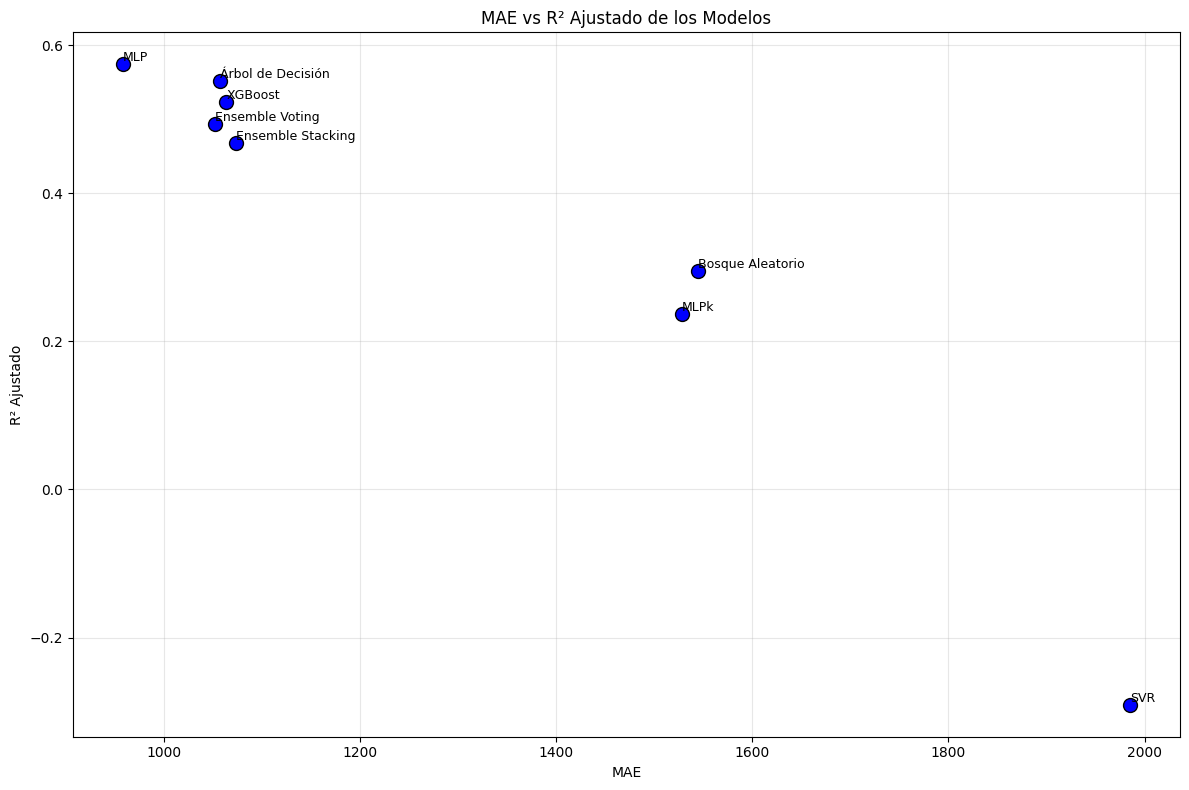

In [ ]:
import matplotlib.pyplot as plt
import warnings

# Ignorar advertencias de fuentes
warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib.font_manager')

# Configurar fuente estándar
plt.rcParams['font.family'] = 'DejaVu Sans'

# Supón que ya tienes estos valores calculados para cada modelo
models = ['Árbol de Decisión', 'Bosque Aleatorio', 'XGBoost', 'SVR', 'Ensemble Voting', 'Ensemble Stacking', 'MLP', 'MLPk']
r2_adjusted = [r2_adj_tree, r2_adj_RandomForest, r2_adj_XGB, r2_adj_SVR, r2_adj_ensemble, r2_adj_stacking, r2_adj_MLP, r2_adj_MLPk]
mae = [MAE_tree, MAE_RandomForest, MAE_XGB, MAE_SVR, MAE_ensemble, MAE_stacking, MAE_MLP, MAE_MLPk]

# Crear el gráfico de dispersión
plt.figure(figsize=(12, 8))
plt.scatter(mae, r2_adjusted, color='blue', s=100, edgecolor='black')

# Añadir etiquetas y título
for i, model in enumerate(models):
    # Ajustamos las posiciones de las etiquetas para que no se solapen con los puntos
    plt.text(mae[i] + 0.1, r2_adjusted[i], model, fontsize=9, ha='left', va='bottom')

plt.title('MAE vs R² Ajustado de los Modelos')
plt.xlabel('MAE')
plt.ylabel('R² Ajustado')
plt.grid(True, alpha=0.3)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

#### R2 ajustado vs RMSE

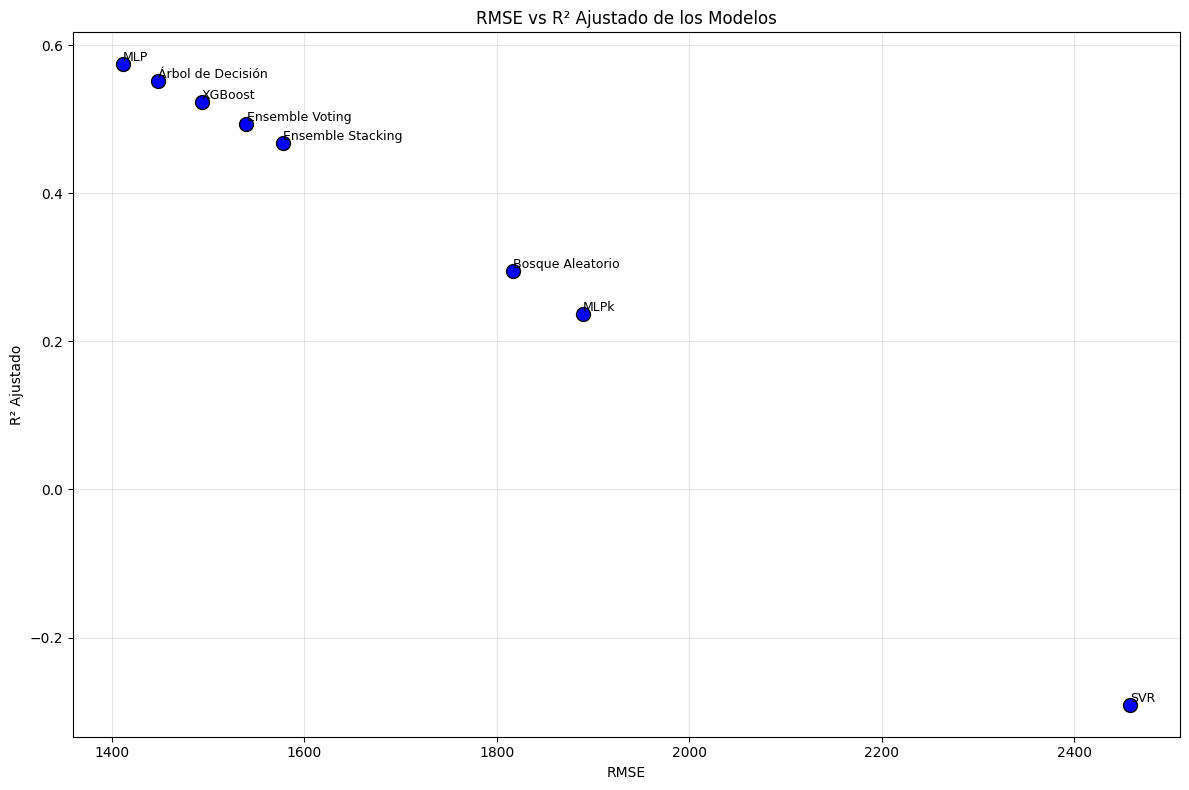

In [ ]:
import matplotlib.pyplot as plt
import warnings

# Ignorar advertencias de fuentes
warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib.font_manager')

# Configurar fuente estándar
plt.rcParams['font.family'] = 'DejaVu Sans'

# Supón que ya tienes estos valores calculados para cada modelo
models = ['Árbol de Decisión', 'Bosque Aleatorio', 'XGBoost', 'SVR', 'Ensemble Voting', 'Ensemble Stacking', 'MLP', 'MLPk']
r2_adjusted = [r2_adj_tree, r2_adj_RandomForest, r2_adj_XGB, r2_adj_SVR, r2_adj_ensemble, r2_adj_stacking, r2_adj_MLP, r2_adj_MLPk]
rmse = [rmse_tree, rmse_RandomForest, rmse_XGB, rmse_SVR, rmse_ensemble, rmse_stacking, rmse_MLP, rmse_MLPk]

# Crear el gráfico de dispersión
plt.figure(figsize=(12, 8))
plt.scatter(rmse, r2_adjusted, color='blue', s=100, edgecolor='black')

# Añadir etiquetas y título
for i, model in enumerate(models):
    # Ajustamos las posiciones de las etiquetas para que no se solapen con los puntos
    plt.text(rmse[i] + 0.1, r2_adjusted[i], model, fontsize=9, ha='left', va='bottom')

plt.title('RMSE vs R² Ajustado de los Modelos')
plt.xlabel('RMSE')
plt.ylabel('R² Ajustado')
plt.grid(True, alpha=0.3)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

### Graficas de puntos


=== VERIFICANDO MODELOS DISPONIBLES ===
✅ y_pred_tree
✅ y_pred_RandomForest
✅ y_pred_XGB
✅ y_pred_SVR
✅ y_pred_ensemble
✅ y_pred_stacking
✅ y_pred_MLPk
✅ y_pred_MLP

Total de modelos encontrados: 8/8

=== RECOPILANDO RESULTADOS DE LOS MODELOS ===
Modelos cargados: 8

Esperando 109 muestras en y_test...
Árbol de Decisión: 109 predicciones
Bosque Aleatorio: 109 predicciones
XGBoost: 109 predicciones
SVR: 109 predicciones
Ensemble Voting: 109 predicciones
Ensemble Stacking: 109 predicciones
MLP Keras: 109 predicciones
MLP Sklearn: 109 predicciones

Recalculando métricas con data compatible...

Métricas Recalculadas:
  Árbol de Decisión: R²-adj=0.5519, MAE=1057.20, RMSE=1448.25
  Bosque Aleatorio: R²-adj=0.2948, MAE=1544.68, RMSE=1816.74
  XGBoost: R²-adj=0.5236, MAE=1063.83, RMSE=1493.20
  SVR: R²-adj=-0.2907, MAE=1984.73, RMSE=2457.79
  Ensemble Voting: R²-adj=0.4934, MAE=1052.38, RMSE=1539.80
  Ensemble Stacking: R²-adj=0.4681, MAE=1073.43, RMSE=1577.80
  MLP Keras: R²-adj=0.2372, MAE=1

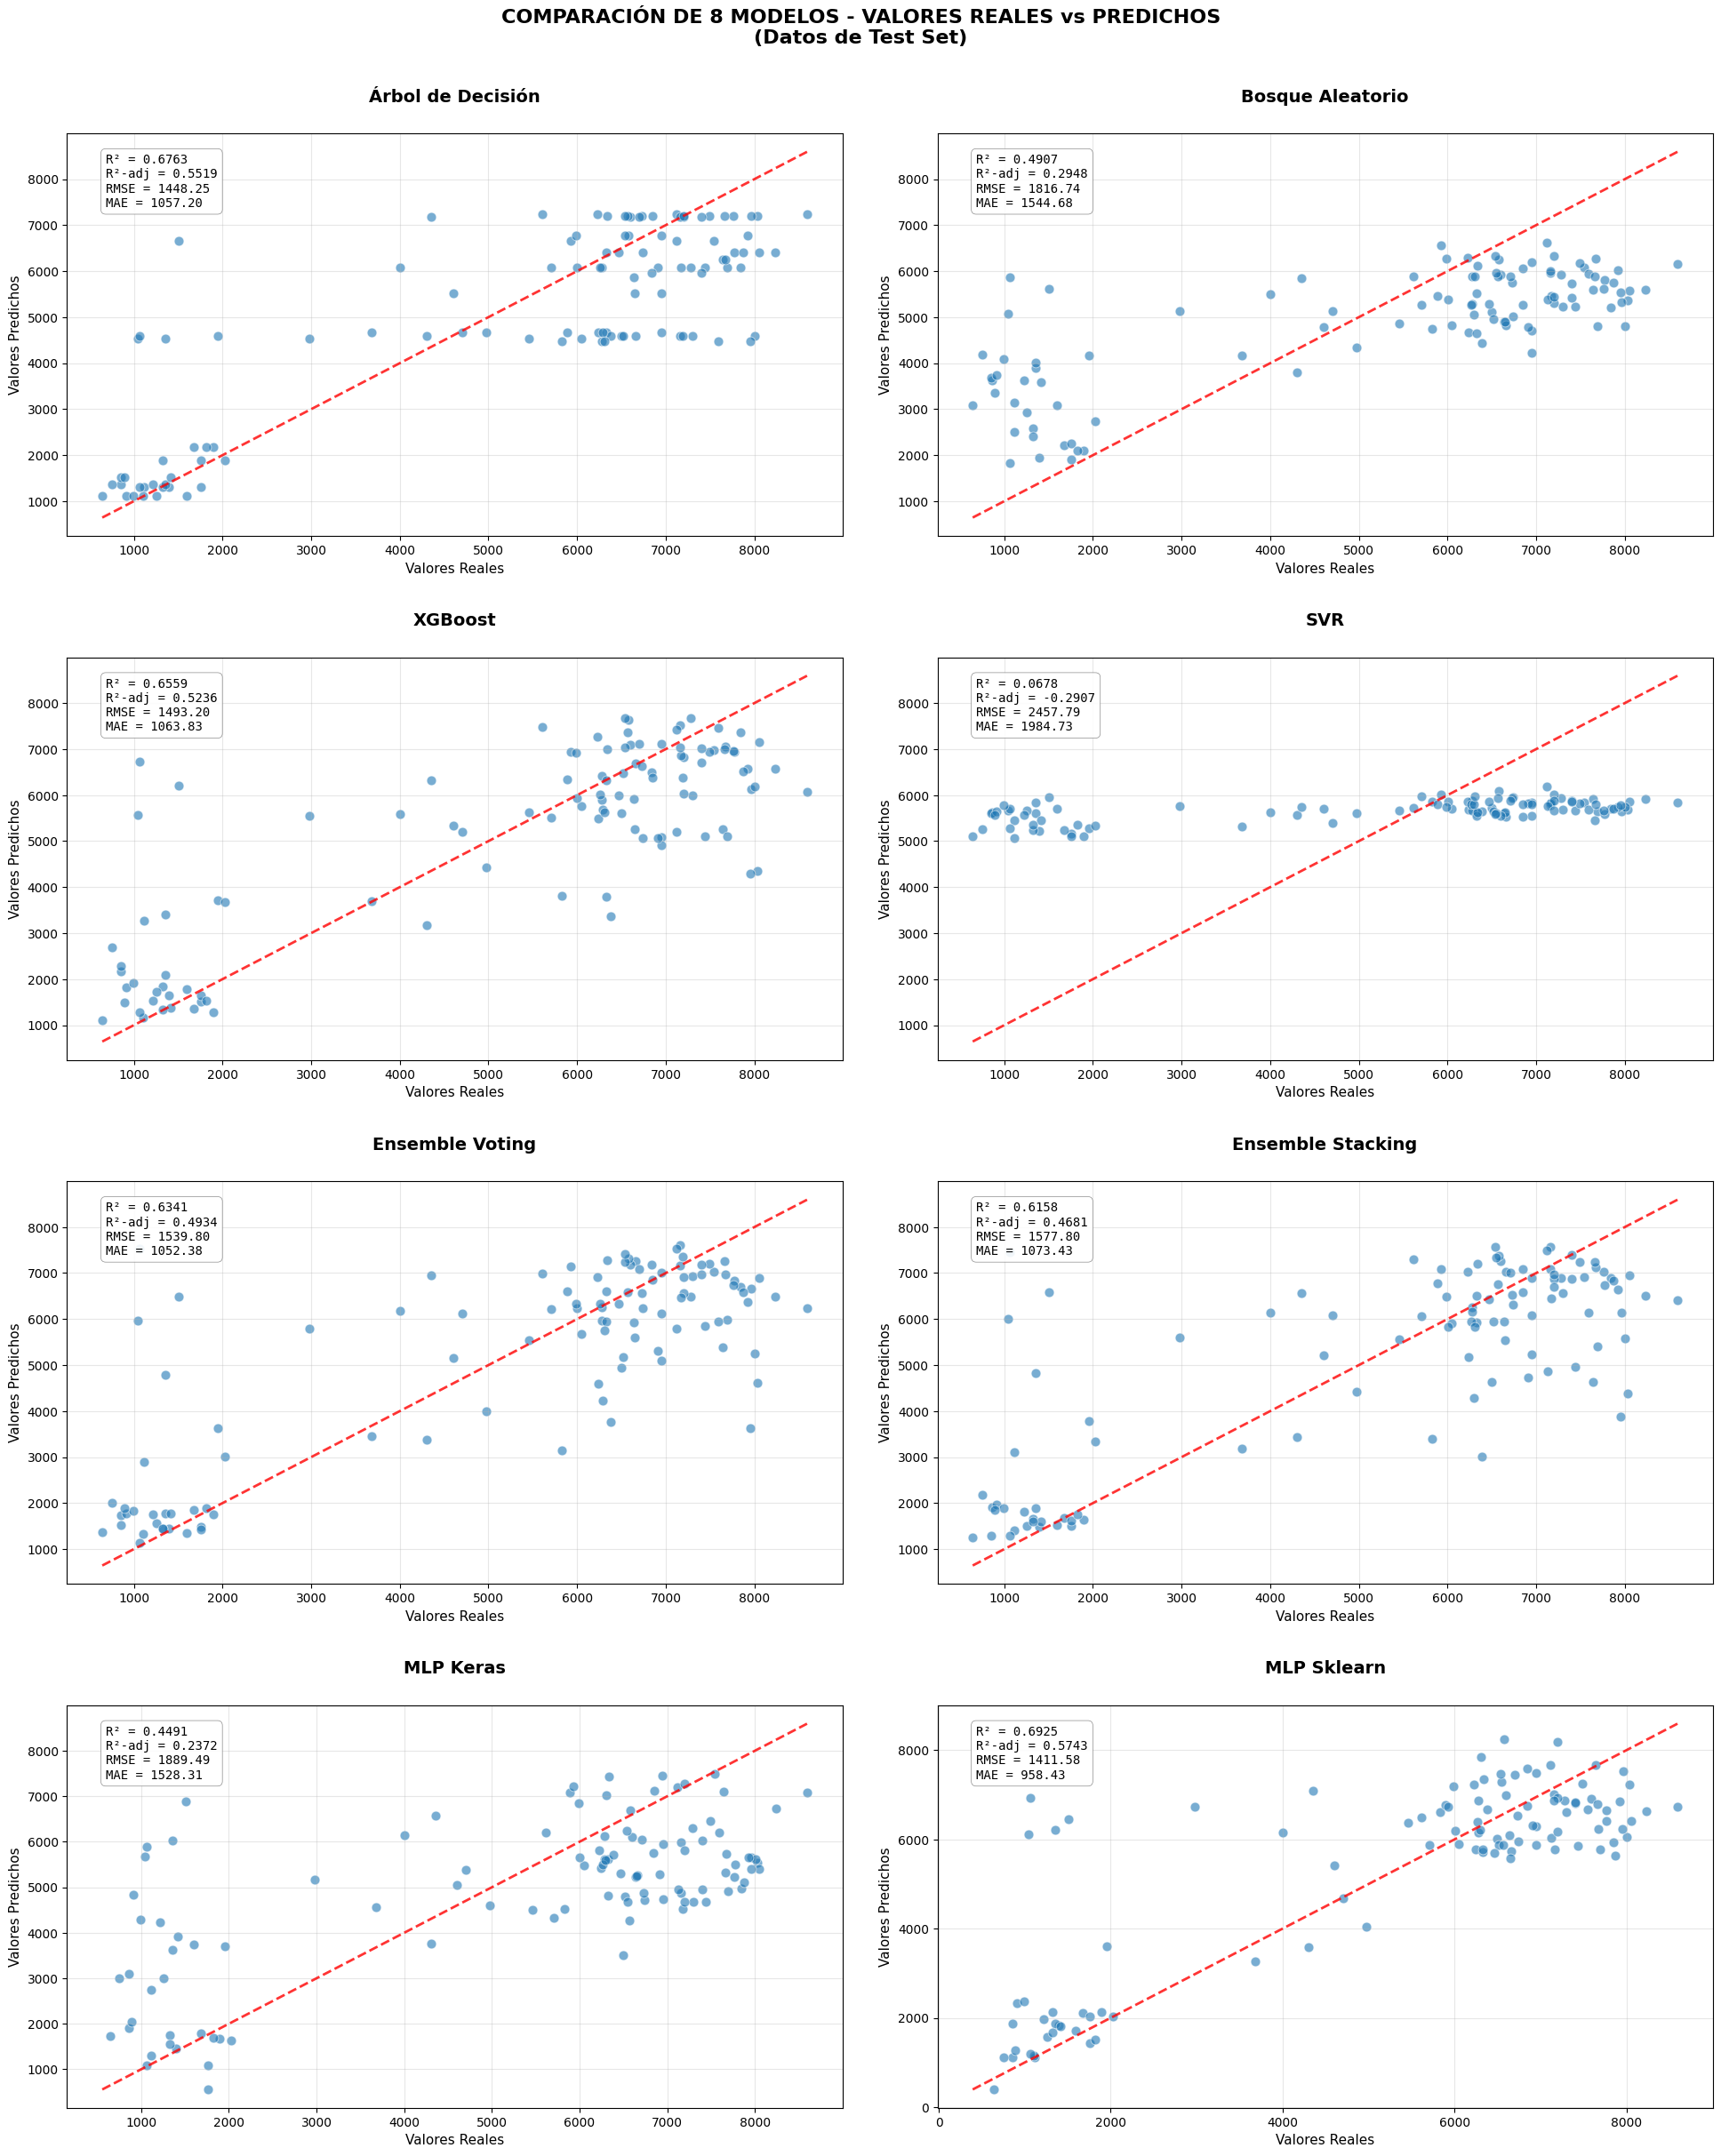


TABLA COMPARATIVA FINAL - 8 MODELOS
Pos Modelo               R² Ajustado  RMSE     MAE      Muestras  
----------------------------------------------------------------------
1   MLP Sklearn          0.5743     1411.58     958.43     109       
2   Árbol de Decisión    0.5519     1448.25     1057.20     109       
3   XGBoost              0.5236     1493.20     1063.83     109       
4   Ensemble Voting      0.4934     1539.80     1052.38     109       
5   Ensemble Stacking    0.4681     1577.80     1073.43     109       
6   Bosque Aleatorio     0.2948     1816.74     1544.68     109       
7   MLP Keras            0.2372     1889.49     1528.31     109       
8   SVR                  -0.2907     2457.79     1984.73     109       

RANKING FINAL POR R² AJUSTADO


,Modelo,R² Ajustado,RMSE,MAE,Muestras Test
7,MLP Sklearn,0.5743,1411.58,958.43,109
0,Árbol de Decisión,0.5519,1448.25,1057.20,109
2,XGBoost,0.5236,1493.20,1063.83,109
4,Ensemble Voting,0.4934,1539.80,1052.38,109
5,Ensemble Stacking,0.4681,1577.80,1073.43,109
1,Bosque Aleatorio,0.2948,1816.74,1544.68,109
6,MLP Keras,0.2372,1889.49,1528.31,109
3,SVR,-0.2907,2457.79,1984.73,109



ANÁLISIS COMPARATIVO
MEJOR MODELO: MLP Sklearn
   • R² Ajustado: 0.5743
   • RMSE: 1411.58
   • MAE: 958.43

RANGO DE R² AJUSTADO: -0.2907 - 0.5743
DIFERENCIA ENTRE MEJOR/PEOR: 0.8650

TOP 3 MODELOS:
   1. MLP Sklearn: R²-adj = 0.5743
   2. Árbol de Decisión: R²-adj = 0.5519
   3. XGBoost: R²-adj = 0.5236


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd

# Ignorar advertencias
warnings.filterwarnings('ignore')

# Función R² Ajustado CORREGIDA
def adjusted_r2(r2, n, p):
    if n - p - 1 <= 0:
        return r2
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

# ============================================================================
# VERIFICACIÓN DE MODELOS EXISTENTES
# ============================================================================

print("=== VERIFICANDO MODELOS DISPONIBLES ===")

modelos_requeridos = [
    'y_pred_tree', 'y_pred_RandomForest', 'y_pred_XGB', 'y_pred_SVR',
    'y_pred_ensemble', 'y_pred_stacking', 'y_pred_MLPk', 'y_pred_MLP'
]

modelos_existentes = []
for modelo in modelos_requeridos:
    if modelo in locals() or modelo in globals():
        modelos_existentes.append(modelo)
        print(f"✅ {modelo}")
    else:
        print(f"❌ {modelo} - NO ENCONTRADO")

print(f"\nTotal de modelos encontrados: {len(modelos_existentes)}/8")

# ============================================================================
# RECOPILACIÓN DE RESULTADOS DE TODOS LOS MODELOS
# ============================================================================

print("\n=== RECOPILANDO RESULTADOS DE LOS MODELOS ===")

# Usar el número correcto de características
n_features = X_train.shape[1]
n_test_samples = len(y_test)

modelos_completos = []

# Decision Tree
if 'y_pred_tree' in locals() or 'y_pred_tree' in globals():
    modelos_completos.append({
        'nombre': 'Árbol de Decisión',
        'y_pred': y_pred_tree,
        'r2': r2_tree,
        'r2_adj': adjusted_r2(r2_tree, n_test_samples, n_features),
        'rmse': rmse_tree,
        'mae': MAE_tree
    })

# Random Forest
if 'y_pred_RandomForest' in locals() or 'y_pred_RandomForest' in globals():
    modelos_completos.append({
        'nombre': 'Bosque Aleatorio',
        'y_pred': y_pred_RandomForest,
        'r2': r2_RandomForest,
        'r2_adj': adjusted_r2(r2_RandomForest, n_test_samples, n_features),
        'rmse': rmse_RandomForest,
        'mae': MAE_RandomForest
    })

# XGBoost
if 'y_pred_XGB' in locals() or 'y_pred_XGB' in globals():
    modelos_completos.append({
        'nombre': 'XGBoost',
        'y_pred': y_pred_XGB,
        'r2': r2_XGB,
        'r2_adj': adjusted_r2(r2_XGB, n_test_samples, n_features),
        'rmse': rmse_XGB,
        'mae': MAE_XGB
    })

# SVR
if 'y_pred_SVR' in locals() or 'y_pred_SVR' in globals():
    modelos_completos.append({
        'nombre': 'SVR',
        'y_pred': y_pred_SVR,
        'r2': r2_SVR,
        'r2_adj': adjusted_r2(r2_SVR, n_test_samples, n_features),
        'rmse': rmse_SVR,
        'mae': MAE_SVR
    })

# Ensemble Voting
if 'y_pred_ensemble' in locals() or 'y_pred_ensemble' in globals():
    modelos_completos.append({
        'nombre': 'Ensemble Voting',
        'y_pred': y_pred_ensemble,
        'r2': r2_ensemble,
        'r2_adj': adjusted_r2(r2_ensemble, n_test_samples, n_features),
        'rmse': rmse_ensemble,
        'mae': MAE_ensemble
    })

# Ensemble Stacking
if 'y_pred_stacking' in locals() or 'y_pred_stacking' in globals():
    modelos_completos.append({
        'nombre': 'Ensemble Stacking',
        'y_pred': y_pred_stacking,
        'r2': r2_stacking,
        'r2_adj': adjusted_r2(r2_stacking, n_test_samples, n_features),
        'rmse': rmse_stacking,
        'mae': MAE_stacking
    })

# MLP Keras
if 'y_pred_MLPk' in locals() or 'y_pred_MLPk' in globals():
    modelos_completos.append({
        'nombre': 'MLP Keras',
        'y_pred': y_pred_MLPk,
        'r2': r2_MLPk,
        'r2_adj': adjusted_r2(r2_MLPk, n_test_samples, n_features),
        'rmse': rmse_MLPk,
        'mae': MAE_MLPk
    })

# MLP Sklearn
if 'y_pred_MLP' in locals() or 'y_pred_MLP' in globals():
    modelos_completos.append({
        'nombre': 'MLP Sklearn',
        'y_pred': y_pred_MLP,
        'r2': r2_MLP,
        'r2_adj': adjusted_r2(r2_MLP, n_test_samples, n_features),
        'rmse': rmse_MLP,
        'mae': MAE_MLP
    })

print(f"Modelos cargados: {len(modelos_completos)}")

# ============================================================================
# VERIFICACIÓN Y AJUSTE DE CONSISTENCIA
# ============================================================================

print(f"\nEsperando {len(y_test)} muestras en y_test...")

for modelo in modelos_completos:
    print(f"{modelo['nombre']}: {len(modelo['y_pred'])} predicciones")

# Encontrar longitud mínima compatible
min_len = min([len(m['y_pred']) for m in modelos_completos] + [len(y_test)])

# Ajustar y_test para consistencia
if len(y_test) > min_len:
    print(f"\nTruncando y_test a {min_len} muestras para consistencia...")
    y_test_compatible = y_test[:min_len]
else:
    y_test_compatible = y_test

# Recalcular métricas con datos compatibles
print("\nRecalculando métricas con data compatible...")
for modelo in modelos_completos:
    # Ajustar y_pred si es necesario
    y_pred_compatible = modelo['y_pred'][:min_len] if len(modelo['y_pred']) > min_len else modelo['y_pred']

    # Recalcular todas las métricas
    modelo['y_pred'] = y_pred_compatible
    modelo['r2'] = r2_score(y_test_compatible, modelo['y_pred'])
    modelo['r2_adj'] = adjusted_r2(modelo['r2'], len(y_test_compatible), n_features)
    modelo['rmse'] = np.sqrt(mean_squared_error(y_test_compatible, modelo['y_pred']))
    modelo['mae'] = mean_absolute_error(y_test_compatible, modelo['y_pred'])
    modelo['Muestras Test'] = len(y_test_compatible)

print("\nMétricas Recalculadas:")
for modelo in modelos_completos:
    print(f"  {modelo['nombre']}: R²-adj={modelo['r2_adj']:.4f}, MAE={modelo['mae']:.2f}, RMSE={modelo['rmse']:.2f}")

# ============================================================================
# GRÁFICA CONJUNTA
# ============================================================================

print("\n=== GENERANDO GRÁFICA CONJUNTA ===")

# Configurar figura según número de modelos
n_modelos = len(modelos_completos)
filas = (n_modelos + 1) // 2  # Calcula filas necesarias
plt.figure(figsize=(20, 6 * filas))

# Crear subplots
for i, modelo in enumerate(modelos_completos, 1):
    plt.subplot(filas, 2, i)

    # Scatter plot
    sns.scatterplot(x=y_test_compatible, y=modelo['y_pred'], alpha=0.6, s=60)

    # Línea de perfecta predicción
    min_val = min(y_test_compatible.min(), modelo['y_pred'].min())
    max_val = max(y_test_compatible.max(), modelo['y_pred'].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, alpha=0.8)

    # Configurar gráfico
    plt.title(f"{modelo['nombre']}\n", fontsize=14, fontweight='bold', pad=10)
    plt.xlabel("Valores Reales", fontsize=11)
    plt.ylabel("Valores Predichos", fontsize=11)
    plt.grid(True, alpha=0.3)

    # Texto con métricas
    metric_text = f'R² = {modelo["r2"]:.4f}\nR²-adj = {modelo["r2_adj"]:.4f}\nRMSE = {modelo["rmse"]:.2f}\nMAE = {modelo["mae"]:.2f}'

    plt.text(0.05, 0.95, metric_text,
             transform=plt.gca().transAxes,
             bbox=dict(boxstyle="round,pad=0.4", facecolor="white", alpha=0.9,
                      edgecolor='gray', linewidth=0.5),
             fontsize=10,
             verticalalignment='top',
             fontfamily='monospace')

# Ajustar layout
plt.tight_layout(pad=3.0)
plt.suptitle(f"COMPARACIÓN DE {n_modelos} MODELOS - VALORES REALES vs PREDICHOS\n(Datos de Test Set)",
             fontsize=16, fontweight='bold', y=1.02)
plt.show()

# ============================================================================
# TABLA COMPARATIVA FINAL
# ============================================================================

print("\n" + "="*80)
print(f"TABLA COMPARATIVA FINAL - {n_modelos} MODELOS")
print("="*80)

# Crear DataFrame comparativo
comparacion_final = []
for modelo in modelos_completos:
    comparacion_final.append({
        'Modelo': modelo['nombre'],
        'R²': modelo['r2'],
        'R² Ajustado': modelo['r2_adj'],
        'RMSE': modelo['rmse'],
        'MAE': modelo['mae'],
        'Muestras Test': modelo['Muestras Test']
    })

df_comparacion = pd.DataFrame(comparacion_final)
df_comparacion = df_comparacion.sort_values('R² Ajustado', ascending=False)

# Mostrar tabla formateada
print(f"{'Pos':<3} {'Modelo':<20} {'R² Ajustado':<12} {'RMSE':<8} {'MAE':<8} {'Muestras':<10}")
print("-" * 70)
for i, (_, row) in enumerate(df_comparacion.iterrows(), 1):
    print(f"{i:<3} {row['Modelo']:<20} {row['R² Ajustado']:.4f}     {row['RMSE']:.2f}     {row['MAE']:.2f}     {row['Muestras Test']:<10}")

# ============================================================================
# TABLA BONITA CON PANDAS
# ============================================================================

print("\n" + "="*80)
print("RANKING FINAL POR R² AJUSTADO")
print("="*80)

# Preparar datos para display
df_display = df_comparacion[['Modelo', 'R² Ajustado', 'RMSE', 'MAE', 'Muestras Test']].copy()
df_display['R² Ajustado'] = df_display['R² Ajustado'].round(4)
df_display['RMSE'] = df_display['RMSE'].round(2)
df_display['MAE'] = df_display['MAE'].round(2)

# Mostrar tabla con colores
styled_table = df_display.style.format({
    'R² Ajustado': '{:.4f}',
    'RMSE': '{:.2f}',
    'MAE': '{:.2f}'
}).background_gradient(subset=['R² Ajustado'], cmap='YlGnBu')

display(styled_table)

# ============================================================================
# ANÁLISIS COMPARATIVO
# ============================================================================

print("\n" + "="*80)
print("ANÁLISIS COMPARATIVO")
print("="*80)

if len(df_comparacion) > 0:
    mejor_modelo = df_comparacion.iloc[0]
    peor_modelo = df_comparacion.iloc[-1]

    print(f"MEJOR MODELO: {mejor_modelo['Modelo']}")
    print(f"   • R² Ajustado: {mejor_modelo['R² Ajustado']:.4f}")
    print(f"   • RMSE: {mejor_modelo['RMSE']:.2f}")
    print(f"   • MAE: {mejor_modelo['MAE']:.2f}")

    print(f"\nRANGO DE R² AJUSTADO: {df_comparacion['R² Ajustado'].min():.4f} - {df_comparacion['R² Ajustado'].max():.4f}")
    print(f"DIFERENCIA ENTRE MEJOR/PEOR: {mejor_modelo['R² Ajustado'] - peor_modelo['R² Ajustado']:.4f}")

    print(f"\nTOP 3 MODELOS:")
    for i in range(min(3, len(df_comparacion))):
        modelo = df_comparacion.iloc[i]
        print(f"   {i+1}. {modelo['Modelo']}: R²-adj = {modelo['R² Ajustado']:.4f}")
else:
    print("❌ No hay modelos para comparar")

### Diagrama de barras R2 ajustado, MAE y RMSE


GRÁFICAS DE BARRAS COMPARATIVAS - ESTILO ACADÊMICO


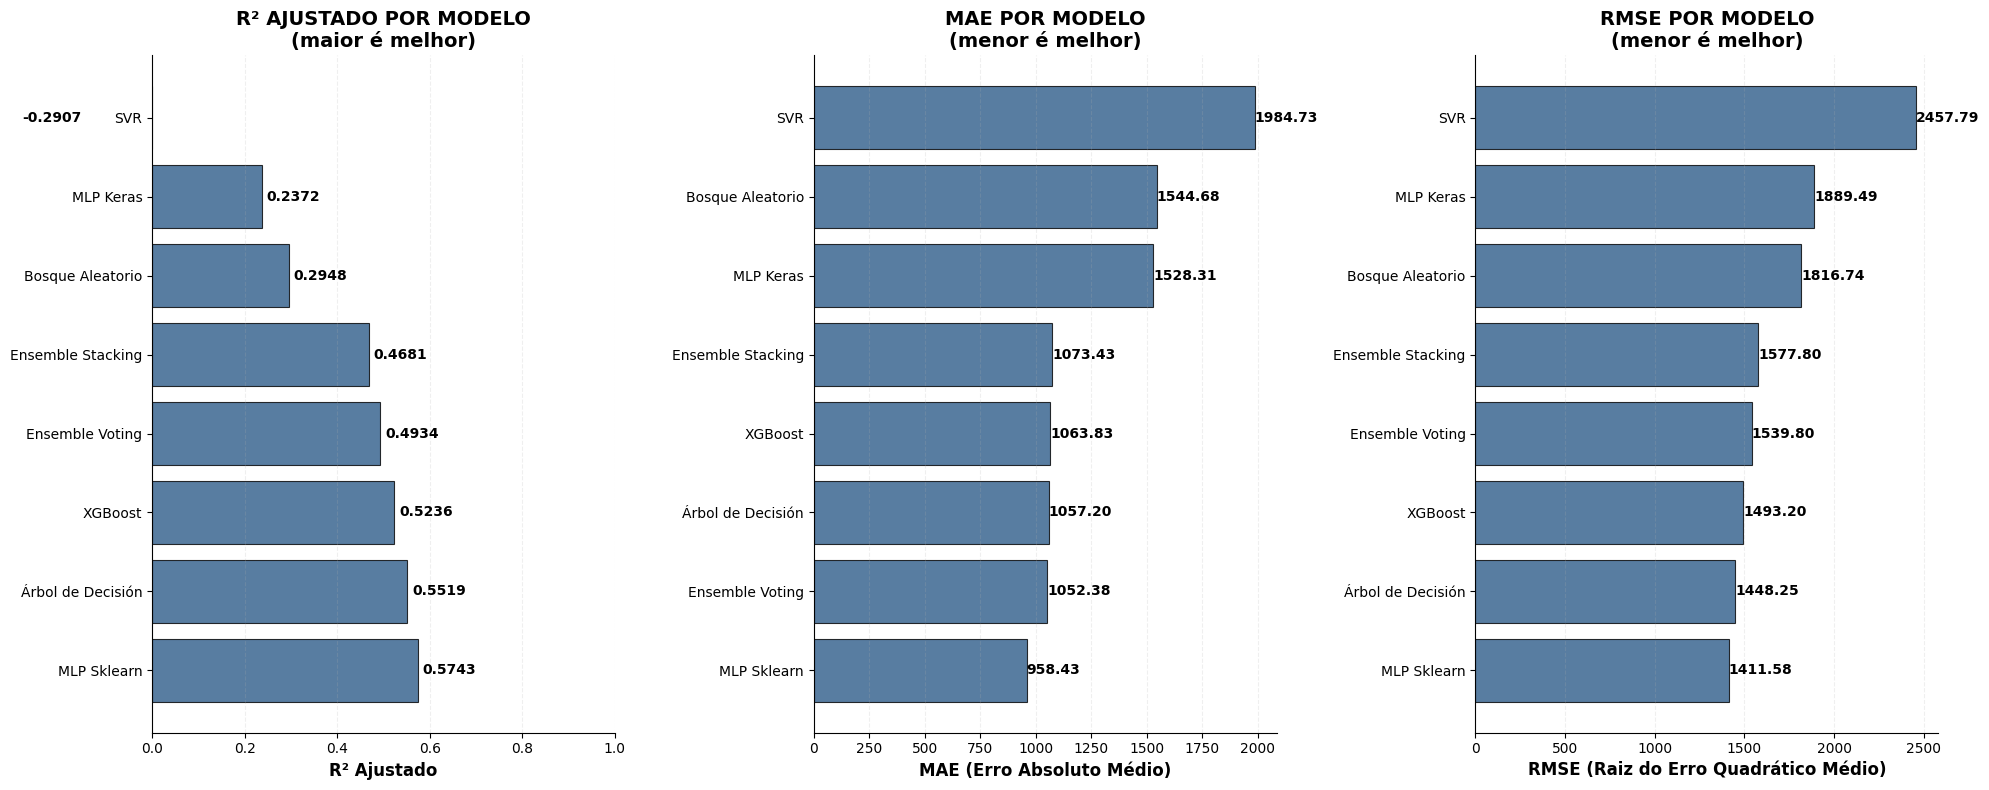

In [ ]:
# ============================================================================
# GRÁFICAS DE BARRAS COMPARATIVAS - ESTILO ACADÉMICO (PORTUGUÊS)
# ============================================================================

print("\n" + "="*80)
print("GRÁFICAS DE BARRAS COMPARATIVAS - ESTILO ACADÊMICO")
print("="*80)

# Configurar subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

# Cor profissional azul (mais usado em papers)
color_paper = '#2E5C8A'

# ============================================================================
# GRÁFICA 1: R² AJUSTADO
# ============================================================================
ax1 = axes[0]
bars1 = ax1.barh(df_comparacion['Modelo'], df_comparacion['R² Ajustado'],
                color=color_paper, alpha=0.8, edgecolor='black', linewidth=0.8)

# Añadir valores en las barras
for bar, valor in zip(bars1, df_comparacion['R² Ajustado']):
    ax1.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
             f'{valor:.4f}', ha='left', va='center', fontweight='bold', fontsize=10)

ax1.set_xlabel('R² Ajustado', fontsize=12, fontweight='bold')
ax1.set_title('R² AJUSTADO POR MODELO\n(maior é melhor)', fontsize=14, fontweight='bold')
ax1.grid(True, axis='x', alpha=0.2, linestyle='--')
ax1.set_xlim(0, 1.0)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# ============================================================================
# GRÁFICA 2: MAE (Mean Absolute Error)
# ============================================================================
ax2 = axes[1]
# Ordenar por MAE (ascendente - menor es mejor)
df_mae_sorted = df_comparacion.sort_values('MAE')
bars2 = ax2.barh(df_mae_sorted['Modelo'], df_mae_sorted['MAE'],
                color=color_paper, alpha=0.8, edgecolor='black', linewidth=0.8)

# Añadir valores en las barras
for bar, valor in zip(bars2, df_mae_sorted['MAE']):
    ax2.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
             f'{valor:.2f}', ha='left', va='center', fontweight='bold', fontsize=10)

ax2.set_xlabel('MAE (Erro Absoluto Médio)', fontsize=12, fontweight='bold')
ax2.set_title('MAE POR MODELO\n(menor é melhor)', fontsize=14, fontweight='bold')
ax2.grid(True, axis='x', alpha=0.2, linestyle='--')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# ============================================================================
# GRÁFICA 3: RMSE (Root Mean Square Error)
# ============================================================================
ax3 = axes[2]
# Ordenar por RMSE (ascendente - menor es mejor)
df_rmse_sorted = df_comparacion.sort_values('RMSE')
bars3 = ax3.barh(df_rmse_sorted['Modelo'], df_rmse_sorted['RMSE'],
                color=color_paper, alpha=0.8, edgecolor='black', linewidth=0.8)

# Añadir valores en las barras
for bar, valor in zip(bars3, df_rmse_sorted['RMSE']):
    ax3.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
             f'{valor:.2f}', ha='left', va='center', fontweight='bold', fontsize=10)

ax3.set_xlabel('RMSE (Raiz do Erro Quadrático Médio)', fontsize=12, fontweight='bold')
ax3.set_title('RMSE POR MODELO\n(menor é melhor)', fontsize=14, fontweight='bold')
ax3.grid(True, axis='x', alpha=0.2, linestyle='--')
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

# Ajustar layout
plt.tight_layout()
plt.show()



## Reporte cuadricula




In [ ]:
import pandas as pd
from IPython.display import HTML
import numpy as np

# ============================================================================
# TABLA DINÁMICA COMPLETA - 8 ALGORITMOS
# ============================================================================

def criar_tabela_dinamica_completa():
    """Crea tabla dinámica completa con las métricas actuales de los 8 algoritmos"""

    # Diccionario dinámico que toma las variables de la ejecución
    dados_algoritmos_dinamico = {
        'Árvore de Decisão': {
            'hiperparametros': {
                'max_depth': [3, 5, 10, 15, 20, None],
                'min_samples_split': [2, 5, 10, 20],
                'min_samples_leaf': [1, 2, 4, 8]
            },
            'combinacoes': 96,
            'parametros_otimos': {
                'max_depth': 10,
                'min_samples_split': 5,
                'min_samples_leaf': 4
            },
            'metricas_teste': {
                'R² ajustado': round(r2_adj_tree, 4) if 'r2_adj_tree' in globals() else 'Ejecutar modelo',
                'MAE': round(MAE_tree, 2) if 'MAE_tree' in globals() else 'Ejecutar modelo',
                'RMSE': round(rmse_tree, 2) if 'rmse_tree' in globals() else 'Ejecutar modelo'
            },
            'validacao_cruzada': {
                'R² ajustado': round(cv_r2_adj_tree, 4) if 'cv_r2_adj_tree' in globals() else 'Ejecutar modelo',
                'MAE': round(cv_mae_mean_tree, 2) if 'cv_mae_mean_tree' in globals() else 'Ejecutar modelo',
                'RMSE': round(cv_rmse_tree, 2) if 'cv_rmse_tree' in globals() else 'Ejecutar modelo'
            }
        },
        'Random Forest': {
            'hiperparametros': {
                'n_estimators': [100, 200, 300],
                'max_depth': [3, 5, 8, 10, 15, 20, None],
                'min_samples_split': [5, 10, 15, 20],
                'min_samples_leaf': [2, 4, 8, 12],
                'max_features': ['sqrt'],
                'max_samples': [0.6, 0.7, 0.8, 1.0]
            },
            'combinacoes': 1008,
            'parametros_otimos': {
                'n_estimators': 200,
                'max_depth': 20,
                'min_samples_split': 5,
                'min_samples_leaf': 2,
                'max_samples': 1.0
            },
            'metricas_teste': {
                'R² ajustado': round(r2_adj_RandomForest, 4) if 'r2_adj_RandomForest' in globals() else 'Ejecutar modelo',
                'MAE': round(MAE_RandomForest, 2) if 'MAE_RandomForest' in globals() else 'Ejecutar modelo',
                'RMSE': round(rmse_RandomForest, 2) if 'rmse_RandomForest' in globals() else 'Ejecutar modelo'
            },
            'validacao_cruzada': {
                'R² ajustado': round(cv_r2_adj_rf, 4) if 'cv_r2_adj_rf' in globals() else 'Ejecutar modelo',
                'MAE': round(cv_mae_mean_rf, 2) if 'cv_mae_mean_rf' in globals() else 'Ejecutar modelo',
                'RMSE': round(cv_rmse_rf, 2) if 'cv_rmse_rf' in globals() else 'Ejecutar modelo'
            }
        },
        'XGBoost': {
            'hiperparametros': {
                'n_estimators': [100, 200, 300],
                'max_depth': [3, 5, 7, 8],
                'learning_rate': [0.05, 0.1, 0.2],
                'subsample': [0.7, 0.8, 1.0],
                'colsample_bytree': [0.7, 0.8, 1.0],
                'reg_alpha': [0, 1, 10],
                'reg_lambda': [1, 10]
            },
            'combinacoes': 1296,
            'parametros_otimos': {
                'n_estimators': 100,
                'max_depth': 5,
                'learning_rate': 0.2,
                'subsample': 1.0,
                'colsample_bytree': 0.7,
                'reg_alpha': 1.0,
                'reg_lambda': 1.0
            },
            'metricas_teste': {
                'R² ajustado': round(r2_adj_XGB, 4) if 'r2_adj_XGB' in globals() else 'Ejecutar modelo',
                'MAE': round(MAE_XGB, 2) if 'MAE_XGB' in globals() else 'Ejecutar modelo',
                'RMSE': round(rmse_XGB, 2) if 'rmse_XGB' in globals() else 'Ejecutar modelo'
            },
            'validacao_cruzada': {
                'R² ajustado': round(cv_r2_adj_xgb, 4) if 'cv_r2_adj_xgb' in globals() else 'Ejecutar modelo',
                'MAE': round(cv_mae_mean_xgb, 2) if 'cv_mae_mean_xgb' in globals() else 'Ejecutar modelo',
                'RMSE': round(cv_rmse_xgb, 2) if 'cv_rmse_xgb' in globals() else 'Ejecutar modelo'
            }
        },
        'SVM': {
            'hiperparametros': {
                'kernel': ['linear', 'rbf'],
                'C': [0.1, 1, 10],
                'epsilon': [0.05, 0.1, 0.2],
                'gamma': ['scale', 'auto']
            },
            'combinacoes': 36,
            'parametros_otimos': {
                'kernel': 'linear',
                'C': 10.0,
                'epsilon': 0.2,
                'gamma': 'auto'
            },
            'metricas_teste': {
                'R² ajustado': round(r2_adj_SVR, 4) if 'r2_adj_SVR' in globals() else 'Ejecutar modelo',
                'MAE': round(MAE_SVR, 2) if 'MAE_SVR' in globals() else 'Ejecutar modelo',
                'RMSE': round(rmse_SVR, 2) if 'rmse_SVR' in globals() else 'Ejecutar modelo'
            },
            'validacao_cruzada': {
                'R² ajustado': round(cv_r2_adj_svm, 4) if 'cv_r2_adj_svm' in globals() else 'Ejecutar modelo',
                'MAE': round(cv_mae_mean_svm, 2) if 'cv_mae_mean_svm' in globals() else 'Ejecutar modelo',
                'RMSE': round(cv_rmse_svm, 2) if 'cv_rmse_svm' in globals() else 'Ejecutar modelo'
            }
        },
        'Ensemble (Voto)': {
            'hiperparametros': {
                'combinações_testadas': '10 combinações de pesos entre Árvore, RF e XGBoost'
            },
            'combinacoes': 10,
            'parametros_otimos': {
                'combinação': 'Todos_Iguales',
                'modelos': 'Árvore, RF, XGBoost',
                'pesos': [1, 1, 1]
            },
            'metricas_teste': {
                'R² ajustado': round(r2_adj_ensemble, 4) if 'r2_adj_ensemble' in globals() else 'Ejecutar modelo',
                'MAE': round(MAE_ensemble, 2) if 'MAE_ensemble' in globals() else 'Ejecutar modelo',
                'RMSE': round(rmse_ensemble, 2) if 'rmse_ensemble' in globals() else 'Ejecutar modelo'
            },
            'validacao_cruzada': {
                'R² ajustado': round(cv_r2_adj_ensemble, 4) if 'cv_r2_adj_ensemble' in globals() else 'Ejecutar modelo',
                'MAE': round(cv_mae_mean_ensemble, 2) if 'cv_mae_mean_ensemble' in globals() else 'Ejecutar modelo',
                'RMSE': round(cv_rmse_ensemble, 2) if 'cv_rmse_ensemble' in globals() else 'Ejecutar modelo'
            }
        },
        'Ensemble (Stacking)': {
            'hiperparametros': {
                'configuração': 'Stacking com 3 modelos base + meta-modelo'
            },
            'combinacoes': 1,
            'parametros_otimos': {
                'modelos_base': 'Árvore, RF, XGBoost',
                'meta_modelo': 'LinearRegression'
            },
            'metricas_teste': {
                'R² ajustado': round(r2_adj_stacking, 4) if 'r2_adj_stacking' in globals() else 'Ejecutar modelo',
                'MAE': round(MAE_stacking, 2) if 'MAE_stacking' in globals() else 'Ejecutar modelo',
                'RMSE': round(rmse_stacking, 2) if 'rmse_stacking' in globals() else 'Ejecutar modelo'
            },
            'validacao_cruzada': {
                'R² ajustado': round(cv_r2_adj_stacking, 4) if 'cv_r2_adj_stacking' in globals() else 'Ejecutar modelo',
                'MAE': round(cv_mae_mean_stacking, 2) if 'cv_mae_mean_stacking' in globals() else 'Ejecutar modelo',
                'RMSE': round(cv_rmse_stacking, 2) if 'cv_rmse_stacking' in globals() else 'Ejecutar modelo'
            }
        },
        'MLP (Keras)': {
            'hiperparametros': {
                'hidden_layers': [[32, 16], [64, 32]],
                'activation': ['relu', 'leaky_relu'],
                'learning_rate': [0.001, 0.0005],
                'batch_size': [16, 32],
                'dropout_rate': [0.2, 0.3],
                'l2_regularization': [0.001, 0.01],
                'epochs': [150, 200],
                'use_batch_norm': [True, False]
            },
            'combinacoes': 256,
            'parametros_otimos': {
                'capas_ocultas': [64, 32],
                'ativação': 'relu',
                'learning_rate': 0.001,
                'batch_size': 16,
                'dropout': 0.2,
                'l2_regularization': 0.01,
                'batch_norm': False
            },
            'metricas_teste': {
                'R² ajustado': round(r2_adj_MLPk, 4) if 'r2_adj_MLPk' in globals() else 'Ejecutar modelo',
                'MAE': round(MAE_MLPk, 2) if 'MAE_MLPk' in globals() else 'Ejecutar modelo',
                'RMSE': round(rmse_MLPk, 2) if 'rmse_MLPk' in globals() else 'Ejecutar modelo'
            },
            'validacao_cruzada': {
                'R² ajustado': round(cv_r2_adj_mean_mlpk, 4) if 'cv_r2_adj_mean_mlpk' in globals() else 'Ejecutar modelo',
                'MAE': round(cv_mae_mean_mlpk, 2) if 'cv_mae_mean_mlpk' in globals() else 'Ejecutar modelo',
                'RMSE': round(cv_rmse_mean_mlpk, 2) if 'cv_rmse_mean_mlpk' in globals() else 'Ejecutar modelo'
            }
        },
        'MLP (Sklearn)': {
            'hiperparametros': {
                'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50), (100, 100), (50, 25, 10)],
                'activation': ['relu', 'tanh'],
                'alpha': [0.0001, 0.001, 0.01],
                'learning_rate_init': [0.01, 0.005],
                'max_iter': [1500, 2000],
                'batch_size': ['auto', 32]
            },
            'combinacoes': 144,
            'parametros_otimos': {
                'arquitetura': '(50, 50)',
                'ativação': 'relu',
                'alpha': 0.001,
                'learning_rate': 0.01,
                'batch_size': 32
            },
            'metricas_teste': {
                'R² ajustado': round(r2_adj_MLP, 4) if 'r2_adj_MLP' in globals() else 'Ejecutar modelo',
                'MAE': round(MAE_MLP, 2) if 'MAE_MLP' in globals() else 'Ejecutar modelo',
                'RMSE': round(rmse_MLP, 2) if 'rmse_MLP' in globals() else 'Ejecutar modelo'
            },
            'validacao_cruzada': {
                'R² ajustado': round(cv_r2_adj_mlp, 4) if 'cv_r2_adj_mlp' in globals() else 'Ejecutar modelo',
                'MAE': round(cv_mae_mean_mlp, 2) if 'cv_mae_mean_mlp' in globals() else 'Ejecutar modelo',
                'RMSE': round(cv_rmse_mlp, 2) if 'cv_rmse_mlp' in globals() else 'Ejecutar modelo'
            }
        }
    }

    return dados_algoritmos_dinamico

# Función para formatear los diccionarios como texto
def formatar_dict(dicionario):
    return '<br>'.join([f"{k}: {v}" for k, v in dicionario.items()])

# Crear y mostrar tabla dinámica
def mostrar_tabela_dinamica():
    """Muestra la tabla dinámica actualizada"""

    dados_algoritmos = criar_tabela_dinamica_completa()

    # Crear DataFrame
    tabela_data = []
    for algoritmo, dados in dados_algoritmos.items():
        tabela_data.append({
            'Algoritmo': algoritmo,
            'Hiperparâmetros': formatar_dict(dados['hiperparametros']),
            'Combinações': dados['combinacoes'],
            'Parâmetros Ótimos': formatar_dict(dados['parametros_otimos']),
            'Métricas (Teste)': formatar_dict(dados['metricas_teste']),
            'Validação Cruzada (K=5)': formatar_dict(dados['validacao_cruzada'])
        })

    df = pd.DataFrame(tabela_data)

    # Crear HTML con alineación izquierda
    html_tabela = df.to_html(escape=False, index=False)

    # Aplicar estilo de alineación izquierda a todas las células
    html_tabela_esquerda = html_tabela.replace('<th>', '<th style="text-align: left; padding: 8px; border: 1px solid #ddd;">').replace('<td>', '<td style="text-align: left; padding: 8px; border: 1px solid #ddd;">')

    # Adicionar estilo CSS para mejor apariencia
    html_final = f"""
    <style>
        table {{
            border-collapse: collapse;
            width: 100%;
            font-family: Arial, sans-serif;
            font-size: 12px;
            margin: 20px 0;
        }}
        th {{
            background-color: #2c3e50;
            color: white;
            font-weight: bold;
            padding: 12px 8px;
            border: 1px solid #34495e;
        }}
        td {{
            padding: 8px;
            border: 1px solid #bdc3c7;
            vertical-align: top;
        }}
        tr:nth-child(even) {{
            background-color: #f8f9fa;
        }}
        tr:hover {{
            background-color: #e8f4f8;
        }}
        .destaque {{
            background-color: #e74c3c !important;
            color: white;
            font-weight: bold;
        }}
    </style>
    <div style="overflow-x: auto;">
    {html_tabela_esquerda}
    </div>
    """

    return HTML(html_final)

# ============================================================================
# MOSTRAR TABLA DINÁMICA
# ============================================================================

print("GENERANDO TABLA DINÁMICA - 8 ALGORITMOS")
print("="*60)

# Mostrar tabla
tabela_final = mostrar_tabela_dinamica()
display(tabela_final)

# También guardar como archivo HTML para referencia
dados_algoritmos = criar_tabela_dinamica_completa()
tabela_data = []
for algoritmo, dados in dados_algoritmos.items():
    tabela_data.append({
        'Algoritmo': algoritmo,
        'Hiperparâmetros': formatar_dict(dados['hiperparametros']),
        'Combinações': dados['combinacoes'],
        'Parâmetros Ótimos': formatar_dict(dados['parametros_otimos']),
        'Métricas (Teste)': formatar_dict(dados['metricas_teste']),
        'Validação Cruzada (K=5)': formatar_dict(dados['validacao_cruzada'])
    })

df_final = pd.DataFrame(tabela_data)
html_tabela_final = df_final.to_html(escape=False, index=False)

with open('tabela_comparativa_algoritmos_dinamica.html', 'w', encoding='utf-8') as f:
    f.write(html_tabela_final)

print("Tabla dinámica generada exitosamente!")
print("Resumen de algoritmos disponibles:")
for i, algoritmo in enumerate(dados_algoritmos.keys(), 1):
    combinacoes = dados_algoritmos[algoritmo]['combinacoes']
    print(f"  {i}. {algoritmo}: {combinacoes} combinaciones")

print("\n La tabla se actualiza automáticamente al ejecutar los modelos")
print(" Tabla guardada como: 'tabela_comparativa_algoritmos_dinamica.html'")

| Algoritmo | Hiperparámetros | Combinações | Parámetros Ótimos | Métricas (Teste) | Validação Cruzada (K=5) |
|-----------|----------------|-------------|-------------------|------------------|------------------------|
| **Árvore de Decisão** | max_depth: [3, 5, 10, 15, 20, None]<br>min_samples_split: [2, 5, 10, 20]<br>min_samples_leaf: [1, 2, 4, 8] | 96 | max_depth: 10<br>min_samples_split: 5<br>min_samples_leaf: 4 | R² ajustado: 0.5519<br>MAE: 1057.2<br>RMSE: 1448.25 | R² ajustado: 0.4944<br>MAE: 1143.84<br>RMSE: 1673.24 |
| **Random Forest** | n_estimators: [100, 200, 300]<br>max_depth: [3, 5, 8, 10, 15, 20, None]<br>min_samples_split: [5, 10, 15, 20]<br>min_samples_leaf: [2, 4, 8, 12]<br>max_features: ['sqrt']<br>max_samples: [0.6, 0.7, 0.8, 1.0] | 1008 | n_estimators: 200<br>max_depth: 20<br>min_samples_split: 5<br>min_samples_leaf: 2<br>max_samples: 1.0 | R² ajustado: 0.2948<br>MAE: 1544.68<br>RMSE: 1816.74 | R² ajustado: 0.2746<br>MAE: 1709.65<br>RMSE: 2006.64 |
| **XGBoost** | n_estimators: [100, 200, 300]<br>max_depth: [3, 5, 7, 8]<br>learning_rate: [0.05, 0.1, 0.2]<br>subsample: [0.7, 0.8, 1.0]<br>colsample_bytree: [0.7, 0.8, 1.0]<br>reg_alpha: [0, 1, 10]<br>reg_lambda: [1, 10] | 1296 | n_estimators: 100<br>max_depth: 5<br>learning_rate: 0.2<br>subsample: 1.0<br>colsample_bytree: 0.7<br>reg_alpha: 1.0<br>reg_lambda: 1.0 | R² ajustado: 0.5236<br>MAE: 1063.83<br>RMSE: 1493.2 | R² ajustado: 0.4593<br>MAE: 1256.77<br>RMSE: 1725.28 |
| **SVM** | kernel: ['linear', 'rbf']<br>C: [0.1, 1, 10]<br>epsilon: [0.05, 0.1, 0.2]<br>gamma: ['scale', 'auto'] | 36 | kernel: linear<br>C: 10.0<br>epsilon: 0.2<br>gamma: auto | R² ajustado: -0.2907<br>MAE: 1984.73<br>RMSE: 2457.79 | R² ajustado: -0.2279<br>MAE: 2163.24<br>RMSE: 2616.3 |
| **Ensemble (Voto)** | combinações_testadas: 10 combinações de pesos entre Árvore, RF y XGBoost | 10 | combinación: Todos_Iguales<br>modelos: Árvore, RF, XGBoost<br>pesos: [1, 1, 1] | R² ajustado: 0.4934<br>MAE: 1052.38<br>RMSE: 1539.8 | R² ajustado: 0.4974<br>MAE: 1205.11<br>RMSE: 1663.76 |
| **Ensemble (Stacking)** | configuración: Stacking con 3 modelos base + meta-modelo | 1 | modelos_base: Árvore, RF, XGBoost<br>meta_modelo: LinearRegression | R² ajustado: 0.4681<br>MAE: 1073.43<br>RMSE: 1577.8 | R² ajustado: 0.4962<br>MAE: 1220.7<br>RMSE: 1663.99 |
| **MLP (Keras)** | hidden_layers: [[32, 16], [64, 32]]<br>activation: ['relu', 'leaky_relu']<br>learning_rate: [0.001, 0.0005]<br>batch_size: [16, 32]<br>dropout_rate: [0.2, 0.3]<br>l2_regularization: [0.001, 0.01]<br>epochs: [150, 200]<br>use_batch_norm: [True, False] | 256 | capas_ocultas: [64, 32]<br>activación: relu<br>learning_rate: 0.001<br>batch_size: 16<br>dropout: 0.2<br>l2_regularization: 0.01<br>batch_norm: False | R² ajustado: 0.2372<br>MAE: 1528.31<br>RMSE: 1889.49 | R² ajustado: -0.825<br>MAE: 1861.31<br>RMSE: 2141.43 |
| **MLP (Sklearn)** | hidden_layer_sizes: [(50,), (100,), (50, 50), (100, 50), (100, 100), (50, 25, 10)]<br>activation: ['relu', 'tanh']<br>alpha: [0.0001, 0.001, 0.01]<br>learning_rate_init: [0.01, 0.005]<br>max_iter: [1500, 2000]<br>batch_size: ['auto', 32] | 144 | arquitectura: (50, 50)<br>activación: relu<br>alpha: 0.001<br>learning_rate: 0.01<br>batch_size: 32 | R² ajustado: 0.5743<br>MAE: 958.43<br>RMSE: 1411.58 | R² ajustado: 0.4989<br>MAE: 1205.33<br>RMSE: 1664.46 |

